In [94]:
import emcee
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks,argrelmin
from scipy.stats import median_absolute_deviation
import eleanor
from astropy.table import setdiff
import urllib
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import TessTargetPixelFile
import eleanor
from astropy.io import ascii,fits
from astropy.table import Table,join,Column
import astropy.units as u
import bokeh
import sys
from scipy.signal import savgol_filter
from requests.exceptions import HTTPError
import matplotlib.gridspec as gridspec
plt.rcParams['font.size']=12
import glob
from PyPDF2 import PdfFileMerger,PdfFileReader
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
import pandas as pd
from astroquery.gaia import Gaia
from uncertainties.umath import *
from uncertainties import ufloat
from uncertainties import unumpy
import statsmodels.distributions.empirical_distribution as emp
from astroquery.gaia import Gaia
from astroquery.mast import Catalogs
from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
from collections import Counter
plt.rcParams['font.size']= 18

def true_sini_distrib(alpha,lamda,n=20000):
    alpha *= np.pi/180
    lamda *= np.pi/180
    
    Rn = np.random.random(n)
    Rnp = np.random.random(n)
    
    theta_n = np.arccos(1 - Rn*(1-np.cos(lamda)))
    Ptheta = (1 - np.cos(theta_n))/(1 - np.cos(lamda))
    phi_n = 2*np.pi*Rnp
    
    cosi_n = np.sin(alpha)*np.sin(theta_n)*np.cos(phi_n) + np.cos(alpha)*np.cos(theta_n)
    sini_n = np.sin(np.arccos(np.abs(cosi_n)))
    
    return sini_n



def obs_sini_distrib(alpha,lamda,deltap=0.1,deltav=0.1,deltar=0.1,cutoff=0,n=20000):
    sini_n_true = true_sini_distrib(alpha,lamda)
    
    U1 = np.random.normal(size=n)
    U2 = np.random.normal(size=n)
    
    deltapv = np.sqrt(deltap**2+deltav**2)
    
    sini_n_obs = sini_n_true * ((1 + deltapv*U1)/(1 + deltar*U2))
    
    cutoffmask = np.zeros(len(sini_n_obs),dtype=bool)
    for i in range(len(sini_n_obs)):
        if sini_n_obs[i] > cutoff:
            cutoffmask[i] = True
    
    sini_n_obs = sini_n_obs[cutoffmask]
    
    return sini_n_obs

#deltap = 0.02, deltar = 0.035, deltav = 0.05


In [135]:
ges_galah_targets_updated = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/ges_galah_targets_updated.dat')
allmems = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_allCGmems.dat')
allmems.sort(keys='bp_rp')
highprob = (allmems['proba'] > 0.68) & (~np.isnan(allmems['bp_rp']))# & ~((allmems['bp_rp'] > 1) & (allmems['phot_g_mean_mag'] < 8))
#ges_galah_targets.sort(keys='teff')
#goodvetperiods = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/vetperiods_corrunc_good.dat')
vetperiods = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_ptbl_cdips_vetted.dat')
goodp = vetperiods['classification'] == 'C'
goodvetperiods = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/final_verified_periods_68conf.dat')#vetperiods[goodp]
ssmemtbl=ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_papertbls_singlestars.dat')


In [155]:
finalperiods = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/final_verified_periods_68conf.dat')

In [137]:
join(onesig_mems_nosbs,vetperiods[goodp])

<Table length=173>
        ra                 dec         ... CDIPS classification
     float64             float64       ... int64      str1     
------------------ ------------------- ... ----- --------------
119.49936785349912  -61.45191965058128 ...     1              C
119.98416898329307  -61.32024360559023 ...     1              C
121.13929660975464  -61.34479131354677 ...     1              C
121.15734269335677 -61.250432702202865 ...     1              C
121.28565505123679  -61.18736195636068 ...     1              C
 120.9091449058326 -61.202491894163856 ...     1              C
 121.0151174118653 -61.120031234540335 ...     1              C
120.78885177123001 -61.110000051400604 ...     1              C
120.20560823917725  -61.20429651502134 ...     1              C
120.17938856509484  -61.10317052582211 ...     1              C
               ...                 ... ...   ...            ...
118.00026430448358  -60.13156244985544 ...     1              C
119.23334771535194 -60.328402022867124 ...     1              C
119.23937225765353 -60.298828098950274 ...     1              C
119.16704795584373 -60.245400137869524 ...     1              C
119.25403743603239  -60.19601543927814 ...     1              C
119.39598933406903   -60.1163724564806 ...     1              C
119.62697416831926 -60.157774012693494 ...     1              C
119.65314123565898  -60.03608363317619 ...     1              C
119.69235773707965  -60.02099349085033 ...     1              C
 119.1273398371943  -60.17093400484393 ...     1              C

In [90]:
finalresults = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/joinedfinalresults_ultimate_cdips.dat')


In [30]:
join(gestbl1,galahdata,join_type='inner',keys='source_id')['vsini_1']

<Column name='vsini_1' dtype='float64' length=3>
39.2
28.1
70.3

In [127]:
join(goodvetperiods,onesig_mems_nosbs)

<Table length=148>
     source_id             period       ...         e_gmag       
       int64              float64       ...        float64       
------------------- ------------------- ... ---------------------
5289890495822656640   1.989866134025422 ...  0.000440631920524295
5289898020605414016  2.2345069945390725 ... 0.0004839284347933976
5289930181318610432   2.046413995219128 ... 0.0003652915051445631
5289934751163440000  1.5833218432962897 ... 0.0006345287457064957
5289958425026796288 0.33868801078892175 ... 0.0013279169134911642
5289982713061723008   3.833304915577174 ... 0.0006163450442448862
5289987115408111360  1.4696316665570648 ... 0.0003491691883971841
5289992990923208704 0.41666348464787006 ... 0.0012223164981554555
5289994502751632384   4.604136650916189 ... 0.0010564375788265914
5289995494884385280  1.7755814400235452 ... 0.0005464759480486018
                ...                 ... ...                   ...
5291010004818471680  3.8089374114027503 ... 0.0006901138477029096
5291027390845814912   3.385427891043946 ... 0.0006943819054641683
5291030448862535808  1.9744112639288813 ... 0.0004990225899219339
5291031582733905408  1.9535776436594976 ... 0.0005222230180501185
5291032132489758208  1.4226235576373123 ... 0.0005780143346185977
5291034194074141568  4.3119183834109975 ... 0.0007634910914940926
5291035912061108992   5.456268395134247 ... 0.0006530842493839127
5291040103949259264   0.530358853843063 ... 0.0004025972336846383
5291041547058288896   4.062512137279555 ... 0.0005436535299762439
5291043917879994880   5.156563447788357 ... 0.0008322954642416206

In [130]:
onesig_mems_nosbs

<Table length=569>
        ra                 dec         ...       proba        cluster 
     float64             float64       ...      float64         str8  
------------------ ------------------- ... ------------------ --------
120.92347226164134  -60.90750623116792 ...  0.699999988079071 NGC_2516
119.02007429823331 -60.242650314474844 ... 0.8999999761581421 NGC_2516
119.62801458151493 -60.729014545974856 ...  0.800000011920929 NGC_2516
119.18789627550726  -60.81503064475218 ... 0.8999999761581421 NGC_2516
119.83869142894031 -60.815619059384105 ...  0.699999988079071 NGC_2516
 118.3718083148051  -61.05443958533375 ... 0.8999999761581421 NGC_2516
119.59272824743998 -60.856155075718064 ... 0.8999999761581421 NGC_2516
118.96086835234338 -61.169145797709746 ...  0.699999988079071 NGC_2516
119.61366160338302  -60.80200477723087 ...                1.0 NGC_2516
119.33799286051837  -60.76745521211992 ... 0.8999999761581421 NGC_2516
               ...                 ... ...                ...      ...
119.71733136904545 -61.399736561744774 ...  0.699999988079071 NGC_2516
120.16115235798104  -61.10671579276989 ...                1.0 NGC_2516
118.99314722588028 -60.322609814371184 ... 0.8999999761581421 NGC_2516
120.40889647173576  -60.41888185470601 ... 0.8999999761581421 NGC_2516
120.42174774469711  -60.74515285966203 ...  0.800000011920929 NGC_2516
120.43011489808374 -60.257054797345646 ...  0.699999988079071 NGC_2516
120.66891417136276  -60.40556839669539 ...  0.699999988079071 NGC_2516
119.06339117109313  -60.39068739243173 ...  0.800000011920929 NGC_2516
120.23387305196745 -60.746427364138206 ...  0.800000011920929 NGC_2516
119.54954188795023  -61.02826735416334 ...  0.800000011920929 NGC_2516

In [36]:
highprobmems = allmems[highprob]

In [131]:
join(onesig_mems_nosbs,finalresults)

<Table length=33>
        ra                 dec         ...  bayes_sini_hi_err  
     float64             float64       ...       float64       
------------------ ------------------- ... --------------------
 118.7091202133573  -60.84460613454599 ...  0.06303151575787891
118.77460824476587 -61.074813094956916 ... 0.061030515257628815
 118.8322405603062  -61.07213912553202 ...  0.09804902451225617
118.96424957852149   -60.9670225989847 ...  0.03701850925462724
119.00514621335617   -60.9573786495814 ...  0.07803901950975467
 119.0469679352922 -60.849409257488574 ...  0.06403201600800401
119.14194733564472  -60.65159281835851 ... 0.034017008504252155
119.23937225765353 -60.298828098950274 ...   0.0700350175087544
119.24813996671055 -60.832366385545264 ...  0.04502251125562784
119.25998129356094  -61.03465617585395 ...  0.10905452726363163
               ...                 ... ...                  ...
119.80580283220925 -60.673281263545306 ...  0.06003001500750371
 119.9654316150975  -60.36926980260596 ... 0.030015007503751856
119.96923296451449  -60.68772763255449 ...   0.0640320160080039
120.11979893793894  -61.12912072833813 ...  0.11005502751375684
120.12015586964222  -61.01335054460787 ...   0.0600300150075036
120.12958796129628 -60.463474414749854 ...  0.07903951975987988
120.13826831046497  -60.52314393476707 ...  0.07803901950975489
120.25893515927606  -60.75072932871493 ...   0.0740370185092547
120.30332781353981  -60.89803478262781 ...  0.04902451225612814
120.35195969813897  -60.58772334905382 ...   0.0690345172586293

In [92]:
join(onesig_mems_nosbs,SSMgrv2)

<Table length=236>
        ra                 dec         ...       e_eu_fe       flag_eu_fe
     float64             float64       ...       float64         int64   
------------------ ------------------- ... ------------------- ----------
117.99855641382302  -60.78941325596245 ...                  --         --
118.01619581164788 -60.836473321308524 ...                  --         --
118.11328646879662  -61.02373484248838 ...  0.1039837808747985          7
118.12745201718678  -60.82032195921853 ...                  --         --
118.19181270664559  -60.66487919860261 ...                  --         --
118.24960410301536  -61.08444077426584 ... 0.11478090716147939          7
118.24967790974463  -60.89129975872747 ...                  --         --
118.25283684556908  -61.21775460697855 ... 0.11448564333097008          7
 118.3400837046244  -61.03688877951317 ...                  --         --
118.52494354243255  -61.02361102351018 ...                  --         --
               ...                 ... ...                 ...        ...
120.36491698845077  -60.69461938824408 ...                  --         --
120.38568956279128  -61.02094792875571 ...                  --         --
120.39132695347004 -60.860565590323546 ...                  --         --
120.40889647173576  -60.41888185470601 ...                  --         --
120.41737748816388  -60.78519199939722 ...                  --         --
120.44696016428436   -60.5836336744805 ...                  --         --
120.48248209311991  -60.71546490049718 ...                  --         --
120.54146332498883  -60.71166749415453 ...                  --         --
120.57805474887596   -60.7551238449648 ...                  --         --
120.64714932207069  -60.67208171402578 ...                  --         --

In [96]:
setdiff(SSMgrv2,onesig_mems_nosbs,keys='source_id')

<Table length=2>
        ra                 dec         ... e_eu_fe flag_eu_fe
     float64             float64       ... float64   int64   
------------------ ------------------- ... ------- ----------
119.13985296658065   -61.0154601889874 ...      --         --
119.06029229768161 -60.908680837889335 ...      --         --

In [100]:
new_GES_stars = setdiff(join(onesig_mems_nosbs,gestbl1,keys='source_id'),SSMgrv2,keys='source_id')

In [101]:
new_GALAH_stars = setdiff(join(onesig_mems_nosbs,galahdata,keys='source_id'),SSMgrv2,keys='source_id')

In [106]:
new_GES_stars.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/new_GES_stars.dat',format='ascii')
new_GALAH_stars.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/new_GALAH_stars.dat',format='ascii')

In [125]:
newGES_periods =join(new_GES_stars[new_GES_stars['vsini'] > 5],goodvetperiods)

newGES_periods.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/new_GES_periods.dat',format='ascii')

In [126]:
newGALAH_periods=join(new_GALAH_stars[new_GALAH_stars['vsini'] > 5],goodvetperiods)

newGALAH_periods.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/new_GALAH_periods.dat',format='ascii')

(18.5, 7)

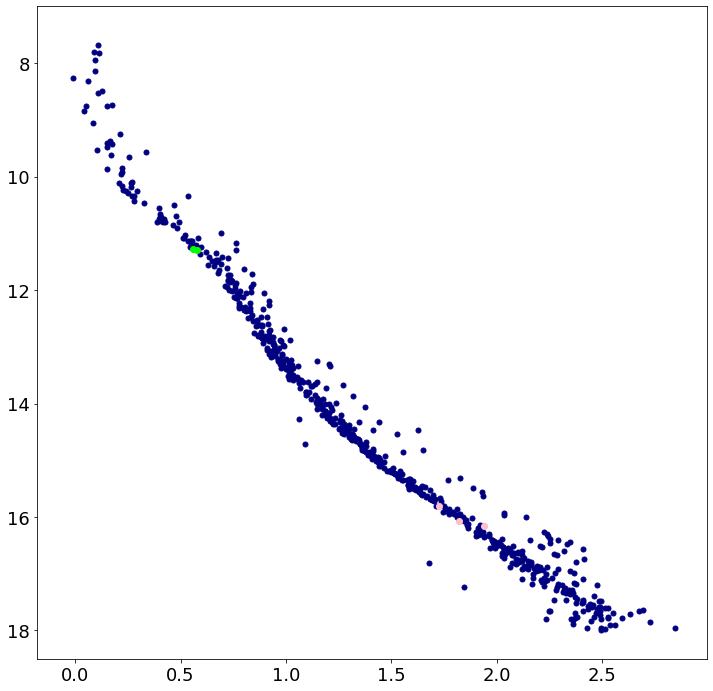

In [124]:
f1 = plt.figure(figsize=(12,12))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='navy',s=25,label='Members (n=650)')
plt.scatter(newGALAH_periods['bp_rp'],newGALAH_periods['phot_g_mean_mag'],color='lime')
plt.scatter(newGES_periods['bp_rp_1'],newGES_periods['phot_g_mean_mag_1'],color='pink')

plt.ylim(18.5,7)

In [110]:
join(new_GES_stars,new_GALAH_stars,keys='source_id')

<Table length=0>
  ra_1   dec_1  source_id   l_1   ... flag_la_fe  eu_fe  e_eu_fe flag_eu_fe
float64 float64   int64   float64 ...   int64    float64 float64   int64   
------- ------- --------- ------- ... ---------- ------- ------- ----------

In [105]:
vstack(SSMgrv2,new_GES_stars)

<Table length=238>
        ra                 dec         ...       e_eu_fe       flag_eu_fe
     float64             float64       ...       float64         int64   
------------------ ------------------- ... ------------------- ----------
117.99855641382302  -60.78941325596245 ...                  --         --
118.01619581164788 -60.836473321308524 ...                  --         --
118.11328646879662  -61.02373484248838 ...  0.1039837808747985          7
118.12745201718678  -60.82032195921853 ...                  --         --
118.19181270664559  -60.66487919860261 ...                  --         --
118.24960410301536  -61.08444077426584 ... 0.11478090716147939          7
118.24967790974463  -60.89129975872747 ...                  --         --
118.25283684556908  -61.21775460697855 ... 0.11448564333097008          7
 118.3400837046244  -61.03688877951317 ...                  --         --
118.52494354243255  -61.02361102351018 ...                  --         --
               ...                 ... ...                 ...        ...
120.36491698845077  -60.69461938824408 ...                  --         --
120.38568956279128  -61.02094792875571 ...                  --         --
120.39132695347004 -60.860565590323546 ...                  --         --
120.40889647173576  -60.41888185470601 ...                  --         --
120.41737748816388  -60.78519199939722 ...                  --         --
120.44696016428436   -60.5836336744805 ...                  --         --
120.48248209311991  -60.71546490049718 ...                  --         --
120.54146332498883  -60.71166749415453 ...                  --         --
120.57805474887596   -60.7551238449648 ...                  --         --
120.64714932207069  -60.67208171402578 ...                  --         --

In [104]:
from astropy.table import vstack

In [4]:
tbl = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CGmems_GES_Gaia_table.dat')

In [5]:
gestbl1 = tbl[tbl['proba']>0.68]

In [668]:
join(goodvetperiods,SSMgrv2[SSMgrv2['vsini']>5])

<Table length=46>
     source_id             period       ... e_eu_fe flag_eu_fe
       int64              float64       ... float64   int64   
------------------- ------------------- ... ------- ----------
5290652938419483904   2.536884877617869 ...      --         --
5290653075858442752  0.4744010329113474 ...      --         --
5290655687198404864  0.9976122763007879 ...      --         --
5290661253475851392  1.2084844329614035 ...      --         --
5290664861248309760  1.6403000651935007 ...      --         --
5290664929967787264  1.4791637021116912 ...      --         --
5290667472588665600  4.2213947289756355 ...      --         --
5290667541308087168   3.060392063437029 ...      --         --
5290667713106775040   3.373782401159405 ...      --         --
5290669534172838528  1.0386882667496264 ...      --         --
                ...                 ... ...     ...        ...
5290771032840440832  1.5624966763425614 ...      --         --
5290777522534884864  1.4083394192159173 ...      --         --
5290814807146918016  2.6041365053970367 ...      --         --
5290817212328531072 0.33332941681146616 ...      --         --
5290817281048004736   4.141001298824057 ...      --         --
5290824320493640576  1.3119235826124036 ...      --         --
5290826936134381440  1.6636972007275155 ...      --         --
5290830097230075904  1.9095311435737778 ...      --         --
5290838962037067648  0.8071457677653855 ...      --         --
5291030448862535808  1.9744112639288813 ...      --         --

In [677]:
np.sum((joinperiods2['vsini'] > 5))# & (joinperiods2['teff']>4000) & (joinperiods2['teff']<10000))

46

In [661]:
join(ssmemtbl,gestbl1)

<Table length=241>
        ra                 dec         ...     parallax_err    
     float64             float64       ...       float64       
------------------ ------------------- ... --------------------
117.99855641382302  -60.78941325596245 ...  0.03552214757155324
118.01619581164788 -60.836473321308524 ...  0.03335740319877301
118.12745201718678  -60.82032195921853 ...  0.08527571688695179
118.19181270664559  -60.66487919860261 ...  0.03377484378882417
118.24967790974463  -60.89129975872747 ...  0.05616468469458247
 118.2607296948317  -60.84050260866884 ...  0.03143321330195845
 118.3400837046244  -61.03688877951317 ...  0.06279543015405506
118.52494354243255  -61.02361102351018 ...  0.04007616923063741
118.53923517870679  -61.13202733746846 ... 0.025556185855304423
 118.5485039558298  -60.79997209857641 ... 0.015736682430034014
               ...                 ... ...                  ...
120.36491698845077  -60.69461938824408 ... 0.031021317772506395
120.38568956279128  -61.02094792875571 ...  0.08699994195328958
120.39132695347004 -60.860565590323546 ...  0.02621820508325254
120.40889647173576  -60.41888185470601 ...  0.09254531782381017
120.41737748816388  -60.78519199939722 ...   0.0214790690307545
120.44696016428436   -60.5836336744805 ...  0.06738449682354154
120.48248209311991  -60.71546490049718 ...  0.04423635360254398
120.54146332498883  -60.71166749415453 ...  0.04484125423802022
120.57805474887596   -60.7551238449648 ...  0.05203843851915669
120.64714932207069  -60.67208171402578 ... 0.044349198317726574

In [662]:
join(ssmemtbl,galahtbl1)

<Table length=14>
        ra                dec         ...       e_eu_fe       flag_eu_fe
     float64            float64       ...       float64         int64   
------------------ ------------------ ... ------------------- ----------
118.11328646879662 -61.02373484248838 ...  0.1039837808747985          7
118.24960410301536 -61.08444077426584 ... 0.11478090716147939          7
118.25283684556908 -61.21775460697855 ... 0.11448564333097008          7
118.54025239558801 -60.97421706363469 ... 0.10153449676608076          7
118.66327238651151  -60.6981630949537 ... 0.06524960688087068          7
119.15218131873883 -60.55636061753096 ... 0.13125547831993753          7
119.25403743603239 -60.19601543927814 ... 0.10102453028828545          7
119.31743340645221 -60.42717907081204 ...  0.1957287486249709          7
 119.3177268629025 -60.78705110901915 ... 0.06661193960678256          5
119.35428362253285 -60.65477258818015 ... 0.08144717860732015          7
119.39433047854344  -60.2066996923345 ... 0.14870115554443364          7
 119.4210732231115 -60.72733767006693 ... 0.18686674817108304          7
119.52183700587412 -60.79447557489121 ... 0.06535778566677174          5
119.65745693005316 -60.56080167137329 ...  0.1012956801017546          7

In [5]:
ssmemtbl = ssmemtbl[ssmemtbl['proba']>0.68]

In [6]:
joinallperiods_ss = join(ssmemtbl,goodvetperiods)

In [5]:
SSMpers['teff']

NameError: name 'SSMpers' is not defined

In [5]:
gestbl=ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CGmems_GES_Gaia_table.dat')

In [6]:
gestbl1=gestbl[(gestbl['proba']>0.5) & (~np.isnan(gestbl['bp_rp']))]

In [7]:
allmems[highprob]

<Table length=650>
        ra                 dec         ...       proba        cluster 
     float64             float64       ...      float64         str8  
------------------ ------------------- ... ------------------ --------
119.91698179846047  -60.20730290913189 ...                1.0 NGC_2516
120.92347226164134  -60.90750623116792 ...  0.699999988079071 NGC_2516
119.02007429823331 -60.242650314474844 ... 0.8999999761581421 NGC_2516
119.62801458151493 -60.729014545974856 ...  0.800000011920929 NGC_2516
119.18789627550726  -60.81503064475218 ... 0.8999999761581421 NGC_2516
119.83869142894031 -60.815619059384105 ...  0.699999988079071 NGC_2516
 118.3718083148051  -61.05443958533375 ... 0.8999999761581421 NGC_2516
119.59272824743998 -60.856155075718064 ... 0.8999999761581421 NGC_2516
118.96086835234338 -61.169145797709746 ...  0.699999988079071 NGC_2516
 119.8488177590863 -60.199399177833655 ...  0.800000011920929 NGC_2516
               ...                 ... ...                ...      ...
120.16115235798104  -61.10671579276989 ...                1.0 NGC_2516
118.99314722588028 -60.322609814371184 ... 0.8999999761581421 NGC_2516
120.40889647173576  -60.41888185470601 ... 0.8999999761581421 NGC_2516
120.42174774469711  -60.74515285966203 ...  0.800000011920929 NGC_2516
120.43011489808374 -60.257054797345646 ...  0.699999988079071 NGC_2516
120.66891417136276  -60.40556839669539 ...  0.699999988079071 NGC_2516
119.06339117109313  -60.39068739243173 ...  0.800000011920929 NGC_2516
120.23387305196745 -60.746427364138206 ...  0.800000011920929 NGC_2516
119.54954188795023  -61.02826735416334 ...  0.800000011920929 NGC_2516
  119.351190251099 -61.162441506704496 ...  0.699999988079071 NGC_2516

In [470]:
O = Observations.query_criteria(objectname='NGC_2516',radius=5*u.deg,provenance_name='CDIPS')

In [468]:
O = Observations.query_criteria(coordinates=SkyCoord(allmems[highprob]['ra'][1]*u.deg,allmems[highprob]['dec'][1]*u.deg),radius=60*u.arcmin,provenance_name='CDIPS')




In [479]:
O

<Table masked=True length=11674>
dataproduct_type calib_level obs_collection ...    objID1        distance     
     str10          int64         str4      ...    str11         float64      
---------------- ----------- -------------- ... ----------- ------------------
      timeseries           4           HLSP ... 18004351241 2820.8661185828723
      timeseries           4           HLSP ... 18004174204  2012.400360814256
      timeseries           4           HLSP ... 18004328461 2657.3746916321907
      timeseries           4           HLSP ... 18004119356  17378.04666365202
      timeseries           4           HLSP ... 18004298200  809.2471380553129
      timeseries           4           HLSP ... 18004454621 1374.9298819570006
      timeseries           4           HLSP ... 18004336986 16357.850924536444
      timeseries           4           HLSP ... 18004238592 14739.191084755867
      timeseries           4           HLSP ... 18004443895  2153.826561991284
      timeseries           4           HLSP ... 18004239720 2150.0393809467373
             ...         ...            ... ...         ...                ...
      timeseries           4           HLSP ... 18004518524  13254.67063539547
      timeseries           4           HLSP ... 18004519503  5057.547781350251
      timeseries           4           HLSP ... 18004519749  10211.84259056776
      timeseries           4           HLSP ... 18004519832  700.3073816434529
      timeseries           4           HLSP ... 18004520796  4726.828339010114
      timeseries           4           HLSP ... 18004523536 3047.4908524141506
      timeseries           4           HLSP ... 18004524298 17121.424486280095
      timeseries           4           HLSP ... 18004525623  4426.976957885509
      timeseries           4           HLSP ... 18004528345  9401.348369441463
      timeseries           4           HLSP ... 18004528436  6738.811740900338

In [498]:
Observations.query_criteria(objectname='Gaia DR2 5290024533163062144',provenance_name='CDIPS',radius=1*u.arcsec)

<Table masked=True length=4>
dataproduct_type calib_level obs_collection ...    objID       objID1   distance
     str10          int64         str4      ...    str11       str11    float64 
---------------- ----------- -------------- ... ----------- ----------- --------
      timeseries           4           HLSP ... 18004096988 18004096988      0.0
      timeseries           4           HLSP ... 18004493332 18004493332      0.0
      timeseries           4           HLSP ... 18004246723 18004246723      0.0
      timeseries           4           HLSP ... 18004372950 18004372950      0.0

In [492]:
#np.str(5292560277555970944) in allmems['source_id']
np.in1d(5290847861214655616,allmems[highprob]['source_id'])

array([ True])

In [489]:
SkyCoord(allmems[highprob]['ra'][1]*u.deg,allmems[highprob]['dec'][1]*u.deg)

<SkyCoord (ICRS): (ra, dec) in deg
    (119.9169818, -60.20730291)>

In [455]:
allmems[highprob]['ra'][1],allmems[highprob]['dec'][1]

(119.91698179846047, -60.20730290913189)

In [450]:
cdips_indx = O['provenance_name'] == 'CDIPS'

In [1038]:
ngc2516mems = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_allCGmems.dat')
ngc2516mems = ngc2516mems[(ngc2516mems['proba'] > 0.5) & (~np.isnan(ngc2516mems['bp_rp']))]
gaia_ids = ngc2516mems['source_id']
gmags = ngc2516mems['phot_g_mean_mag']
ra = ngc2516mems['ra']*u.deg
dec = ngc2516mems['dec']*u.deg

SC = SkyCoord(ra,dec)

#close = np.zeros(len(SC),dtype=bool)
count = np.zeros(len(SC))
#inds = np.zeros(len(SC),dtype=int)
closeids = []
closemags = []
closeseps = []
for i in range(len(SC)):
    print(i)
#for i in range(496,len(SC)):
#for i in range(93,94):
#####
    df = pd.read_csv('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/close_stars/'+np.str(gaia_ids[i])+'.csv')
    closeids += [df['closeids'].values.tolist()]
    closemags += [df['closemags'].values.tolist()]
    closeseps += [df['closeseps'].values.tolist()]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [1041]:
closeids

[[5289890014786360960],
 [5289891389176023296, 5289891354816285440, 5289891423535762432],
 [-1],
 [5289873315953700480],
 [5289872972356316032, 5289872869277099776, 5289872903636838272],
 [5289933101899680896],
 [-1],
 [5289885582380236032],
 [5289885651099647232, 5289886407013891840, 5289886475729737984],
 [5289888399878612992,
  5289888399878612864,
  5289888777835735552,
  5289888331159170944,
  5289888331155557760,
  5289888777835735680],
 [5290638850926917376, 5290638850926918016],
 [-1],
 [5289895473687453440, 5289895546704312064],
 [5289890530182395264],
 [-1],
 [5289932277266018688, 5289932277265953664, 5289932071107523200],
 [-1],
 [5289876992445789952],
 [5289924099648208512, 5289924030928732032, 5289970931971736064],
 [-1],
 [5290001065461752320, 5290001061164151424, 5290001065461752064],
 [5290003298844601216],
 [5289978010077507456, 5289978010077508352, 5289978727335894144],
 [5289996633055418112],
 [5289976085932146816, 5289976085932357760, 5289976292090787840],
 [5290000

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


KeyboardInterrupt: 

In [496]:
'Gaia DR2 '+np.str(allmems[highprob]['source_id'][2])

'Gaia DR2 5290024533163062144'

In [541]:
from astroquery import exceptions

In [604]:
n_lc = np.zeros(len(allmems[highprob]))
for i in range(len(allmems[highprob])):
#for i in range(2,3):
    print(i)
    for x in range(5):
        try:
            obstbl = Observations.query_criteria(objectname='Gaia DR2 '+np.str(allmems[highprob]['source_id'][i]),provenance_name='CDIPS',radius=1*u.arcsec)
            starindx = np.array([j for j in range(len(obstbl)) if np.str(allmems[highprob]['source_id'][i]) in obstbl['obs_id'][j]])
            obstbl = obstbl[starindx]
            if len(obstbl) > 0:
                #print('Downloading products.')
                products = Observations.get_product_list(obstbl)
                Observations.download_products(products,download_dir='/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS')
            n_lc[i] = len(obstbl) 
            break
        except ConnectionError:
            continue
        except exceptions.ResolverError:
            n_lc[i] = 0
            break
                                  

0
1
2
INFO: Found cached file /Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0007-cam4-ccd1_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0007-cam4-ccd1_tess_v01_llc.fits with expected size 334080. [astroquery.query]
INFO: Found cached file /Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0008-cam3-ccd4_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0008-cam3-ccd4_tess_v01_llc.fits with expected size 279360. [astroquery.query]
INFO: Found cached file /Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0010-cam3-ccd3_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0010-cam3-ccd3_tess_v01_llc.fits with expected size 322560. [astroquery.query]
INFO: Found cached file /Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_

15
16
17
18
19
20
21
22
23
24


25
26
27
28
29
30
31
32
33
34


35
36
37
38
39
40
41
42
43


44
45
46
47
48
49
50
51
52
53
54
55
56
57


58
59
60
61
62
63
64
65
66
67
68


69
70
71
72
73
74
75
76


77
78
79
80
81
82
83
84
85


86
87
88
89
90
91
92
93
94
95


96
97
98
99
100
101
102
103
104
105


106
107
108
109
110
111
112
113
114
115
116


117
118
119
120
121
122
123
124
125


126
127
128
129
130
131
132
133
134
135
136
137


138
139
140
141
142
143
144
145
146


147
148
149
150
151
152
153
154


155
156
157
158
159
160
161
162
163
164
165


166
167
168
169
170
171
172
173
174
175


176
177
178
179
180
181
182
183
184


185
186
187
188
189
190
191
192


193
194
195
196
197
198
199
200
201


202
203
204
205
206
207
208
209
210
211
212


213
214
215
216
217
218
219
220
221
222


223
224
225
226
227
228
229
230
231


232
233
234
235
236
237
238
239
240
241
242


243
244
245
246
247
248
249
250
251
252
253


254
255
256
257
258
259
260
261
262
263


264
265
266
267
268
269
270
271
272
273


274
275
276
277
278
279
280
281
282
283


284
285
286
287
288
289
290
291
292


293
294
295
296
297
298
299
300


301
302
303
304
305
306
307
308
309
310
311
312


313
314
315
316
317
318
319
320
321


322
323
324
325
326
327
328
329
330
331
332


333
334
335
336
337
338
339
340
341
342


343
344
345
346
347
348
349
350
351
352
353


354
355
356
357
358
359
360
361
362
363
364


365
366
367
368
369
370
371
372
373
374


375
376
377
378
379
380
381
382
383
384


385
386
387
388
389
390
391
392
393
394
395
396
397


398
399
400
401
402
403
404
405
406


407
408
409
410
411
412
413
414
415


416
417
418
419
420
421
422
423
424


425
426
427
428
429
430
431
432
433
434


435
436
437
438
439
440
441
442
443
444


445
446
447
448
449
450
451
452
453


454
455
456
457
458
459
460
461
462


463
464
465
466
467
468
469
470
471
472


473
474
475
476
477
478
479
480


481
482
483
484
485
486
487
488
489
490


491
492
493
494
495
496
497
498
499


500
501
502
503
504
505
506
507
508


509
510
511
512
513
514
515
516
517


518
519
520
521
522
523
524
525
526
527
528


529
530
531
532
533
534
535
536
537


538
539
540
541
542
543
544
545
546


547
548
549
550
551
552
553
554


555
556
557
558
559
560
561
562
563
564


565
566
567
568
569
570
571
572
573
574


575
576
577
578
579
580
581
582
583


584
585
586
587
588
589
590
591
592
593
594


595
596
597
598
599
600
601
602
603
604
605
606


607
608
609
610
611
612
613
614
615
616


617
618
619
620
621
622
623
624
625
626
627
628
629
630
631


632
633
634
635
636
637
638
639
640
641


642
643
644
645
646
647
648
649
650
651
652
653
654


655
656
657
658
659
660
661
662
663
664
665
666
667
668


669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698


699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793


In [614]:
lcdirs = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/*'+np.str(allmems[highprob]['source_id'][2])+'*')
lcdirs


['/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0010-cam3-ccd3_tess_v01_llc',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0011-cam4-ccd2_tess_v01_llc',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0007-cam4-ccd1_tess_v01_llc',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0008-cam3-ccd4_tess_v01_llc']

In [667]:
secs = []
for d in lcdirs:
    secs += [np.int(d.split('-')[1][2:])]
secs = np.array(secs)

lctbl = Table(data=[lcdirs,secs],names=['lcdirs','secs'])
lctbl.sort('secs')

for i in range(len(lctbl)):
    lcfile = glob.glob(lctbl['lcdirs'][i]+'/*.fits')
    hdul=fits.open(lcfile[0])

In [1018]:
lcfile = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/*5290000137748809856*/*.fits')
lcfile

['/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290000137748809856-0008-cam3-ccd4_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290000137748809856-0008-cam3-ccd4_tess_v01_llc.fits',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290000137748809856-0010-cam3-ccd3_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290000137748809856-0010-cam3-ccd3_tess_v01_llc.fits',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290000137748809856-0011-cam4-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290000137748809856-0011-cam4-ccd2_tess_v01_llc.fits',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290000137748809856-0007-cam4-ccd1_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290000137748809856-0007-cam4-ccd1_tess_v01_llc.fits']

In [950]:
ngc2516mems = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_allCGmems.dat')
ngc2516mems = ngc2516mems[(ngc2516mems['proba'] > 0.5) & (~np.isnan(ngc2516mems['bp_rp']))]
gaia_ids = ngc2516mems['source_id']
ra = ngc2516mems['ra']*u.deg
dec = ngc2516mems['dec']*u.deg

SC = SkyCoord(ra,dec)
count = np.zeros(len(SC))
closeids = []
closemags = []
closeseps = []
for i in range(0,4):
    for attempt in range(10):
        try:
            qry = Gaia.query_object_async(SC[i],radius=21*2*u.arcsec)
            break
        except:
            print('Continuing.')
            continue
    qry['dist'] = qry['dist'] / (21./3600)
    nearby_bright = qry[qry['phot_g_mean_mag'] <= 17][1:]
    #sep = SC[i].separation(SC).arcsec
    #indx = sep != 0
    #close = (sep <= 21*2) & (sep != 0)
    count[i] = len(nearby_bright)
    if count[i] != 0:
        #inds[i] = ngc2516mems['source_id'][close].data
        closeids += [nearby_bright['source_id'].data.tolist()] #[ngc2516mems['source_id'][close].data]
        cm1=[]
        for i in range(len(nearby_bright)):
            cm1 += [np.float(format(nearby_bright['phot_g_mean_mag'].data[i],'.1f'))]
        #closemags += [np.round(nearby_bright['phot_g_mean_mag'].data,0).tolist()]
        closemags += [cm1]
        closeseps += [np.round(nearby_bright['dist'].data,1).tolist()]

        #closeinds += [i]
        #print(i,ngc2516mems['source_id'][close].data)
    else:
        closeids += [[0]]
        closemags += [[0]]
        closeseps += [[0]]

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [955]:
closeids[1]

[5289891389176023296, 5289891354816285440, 5289891423535762432]

In [971]:
with open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/cdips_lcgen/closeids.txt', 'w') as filehandle:
    for listitem in closeids:
        filehandle.write('%s\n' % listitem)

In [972]:
with open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/cdips_lcgen/closeids.txt', 'r') as filehandle:
    closeids_read = [current_place.rstrip() for current_place in filehandle.readlines()]

In [976]:
closeids_read[1]

'[5289891389176023296, 5289891354816285440, 5289891423535762432]'

In [974]:
len(closeids_read)

4

In [997]:
df = pd.DataFrame(data={'closeids':closeids[1],'closemags':closemags[1],'closeseps':closeseps[1]})
df#,columns=['closeids','closemags','closeseps'])

closeids  closemags  closeseps
0  5289891389176023296       16.8        0.7
1  5289891354816285440       16.6        0.8
2  5289891423535762432       16.9        1.8

In [1000]:
df.to_csv('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/close_stars/'+np.str(gaia_ids[1])+'.csv',index=False)

In [1002]:
df=pd.read_csv('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/close_stars/'+np.str(gaia_ids[1])+'.csv')

In [1010]:
cs = df['closeseps']
cs

0    0.7
1    0.8
2    1.8
Name: closeseps, dtype: float64

In [1014]:
cs.values.tolist()


[0.7, 0.8, 1.8]

In [1044]:
eleanor.Source(gaia=5289932277266018688,sector=7,tc=False)

INFO: Found cached file /Users/bhealy/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0007-4-1-cal-0118-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0007-4-1-cal-0118-0592_tess_v2_bkg.fits with expected size 67317120. [astroquery.query]
INFO: Found cached file /Users/bhealy/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0007-4-1-cal-0118-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0007-4-1-cal-0118-0592_tess_v2_pc.fits with expected size 134729280. [astroquery.query]
INFO: Found cached file /Users/bhealy/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0007-4-1-cal-0118-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0007-4-1_tess_v2_pm.txt with expected size 203974. [astroquery.query]


In [1016]:
lc.estimate_cdpp()

/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/lightkurve/lightcurve.py:454: RuntimeWarning: invalid value encountered in less_equal
  mask &= np.nan_to_num(np.abs(self.flux - np.nanmedian(self.flux))) <= (np.nanstd(self.flux) * sigma)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

# 

In [1019]:
hdul=fits.open(lcfile[-1])

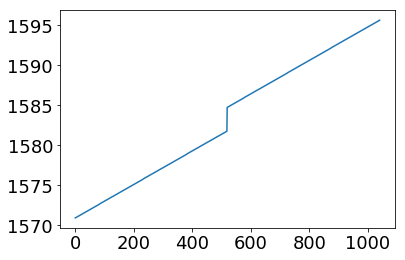

In [1020]:
plt.plot(lc.time-2457000)

In [1021]:
time = hdul[1].data['TMID_BJD']
flux = 2.512**(-hdul[1].data['PCA1'])
flux /= np.nanmedian(flux)
iflflux = hdul[1].data['IFL1']
err = hdul[1].data['IFE1']#/flux
qual = hdul[1].data['IRQ1']

In [896]:
iflflux

array([60.99, 59.83, 63.9 , ..., 67.04, 68.27, 68.49])

In [894]:
err

array([4.98, 4.97, 5.07, ..., 3.63, 3.65, 3.65])

In [892]:
(err/iflflux)

array([0.08165273, 0.08306869, 0.07934272, ..., 0.05414678, 0.05346419,
       0.05329245])

In [749]:
np.sum(qual == 'X')

0

In [1022]:
lc = lk.lightcurve.LightCurve(time,flux,(err/iflflux)*flux)
#lc = lk.lightcurve.LightCurve(time,iflflux/np.nanmedian(iflflux),(err/iflflux)*(iflflux/np.nanmedian(iflflux)))

#lc = lc.normalize()

In [929]:
50 in [50,350,350]

True

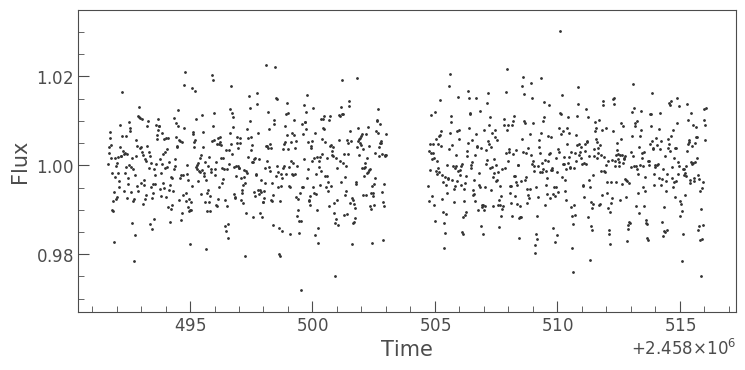

In [1031]:
lc.flatten(31).scatter()
#plt.xlim(2458600+4,2458600+6)

In [1032]:
lc.flatten(31).estimate_cdpp()

3327.186388446928

In [ ]:
lc.estimate_cdpp()

In [940]:
len(lc)

1041

In [937]:
lc.remove_nans().to_periodogram().period_at_max_power.value

/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index -1 is out of bounds for axis 0 with size 0

In [791]:
np.nanmedian(err)

95.26

In [828]:
diffs = np.array([1.35415262, 1.3333195,  1.35415262, 1.31248638, 1.35415262])

In [829]:
np.std(diffs)

0.01666649600000003

In [831]:
from scipy.stats import median_absolute_deviation
median_absolute_deviation(diffs)

0.0

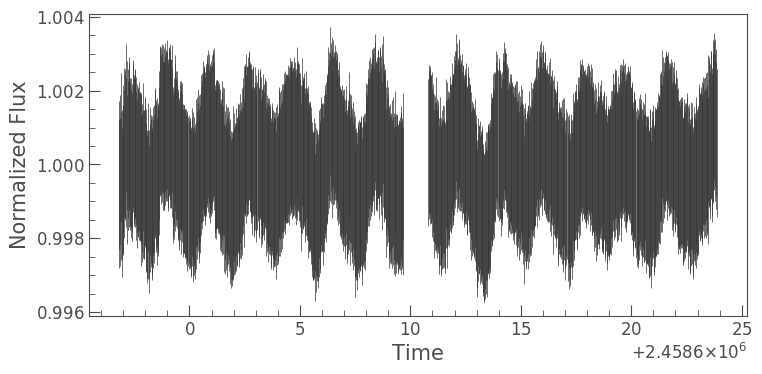

In [797]:

lc.errorbar(linestyle='none')
#plt.ylim(.9925,1.0075)

In [820]:
lc.time - 2457000

array([1596.80368951, 1596.82452258, 1596.84535555, ..., 1623.82398089,
       1623.84481372, 1623.86564655])

In [798]:
lc.flux_err

array([0.00201091, 0.00200991, 0.00201191, ..., 0.00199426, 0.00199405,
       0.00199391])

In [793]:
lc.flux_err

array([0.00201091, 0.00200991, 0.00201191, ..., 0.00199426, 0.00199405,
       0.00199391])

In [690]:
2.512**flux

array([2022.85205181, 2023.85528658, 2023.77664082, ..., 2019.97793785,
       2020.68569999, 2021.08785211])

In [807]:
hdul[1].columns

ColDefs(
    name = 'BGE'; format = 'D'; unit = 'ADU'
    name = 'BGV'; format = 'D'; unit = 'ADU'
    name = 'FDV'; format = 'D'; unit = 'unitless'
    name = 'FKV'; format = 'D'; unit = 'unitless'
    name = 'FSV'; format = 'D'; unit = 'unitless'
    name = 'IFE1'; format = 'D'; unit = 'ADU'
    name = 'IFE2'; format = 'D'; unit = 'ADU'
    name = 'IFE3'; format = 'D'; unit = 'ADU'
    name = 'IFL1'; format = 'D'; unit = 'ADU'
    name = 'IFL2'; format = 'D'; unit = 'ADU'
    name = 'IFL3'; format = 'D'; unit = 'ADU'
    name = 'IRE1'; format = 'D'; unit = 'mag'
    name = 'IRE2'; format = 'D'; unit = 'mag'
    name = 'IRE3'; format = 'D'; unit = 'mag'
    name = 'IRM1'; format = 'D'; unit = 'mag'
    name = 'IRM2'; format = 'D'; unit = 'mag'
    name = 'IRM3'; format = 'D'; unit = 'mag'
    name = 'IRQ1'; format = '1A'; unit = 'unitless'
    name = 'IRQ2'; format = '1A'; unit = 'unitless'
    name = 'IRQ3'; format = '1A'; unit = 'unitless'
    name = 'RSTFC'; format = '48A'; unit = 

In [809]:
star = eleanor.multi_sectors(tic=38846515, sectors=[1,2])





Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  2...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector  2 now available.


In [810]:
s0 = star[0]

In [812]:
s0.sector

1

In [814]:
gaia_ids = allmems[highprob]['source_id']

lcdirs = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/*'+np.str(gaia_ids)+'*')


In [815]:
lcdirs

[]

In [817]:

S = eleanor.Source(gaia=5289889946066884480, sector = 7, tc=False)

INFO: Found cached file /Users/bhealy/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0007-4-1-cal-0216-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0007-4-1-cal-0216-0646_tess_v2_bkg.fits with expected size 67317120. [astroquery.query]
INFO: Found cached file /Users/bhealy/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0007-4-1-cal-0216-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0007-4-1-cal-0216-0646_tess_v2_pc.fits with expected size 134729280. [astroquery.query]
INFO: Found cached file /Users/bhealy/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0007-4-1-cal-0216-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0007-4-1_tess_v2_pm.txt with expected size 203974. [astroquery.query]


In [818]:
S.position_on_chip

array([221.00203108, 619.46224594])

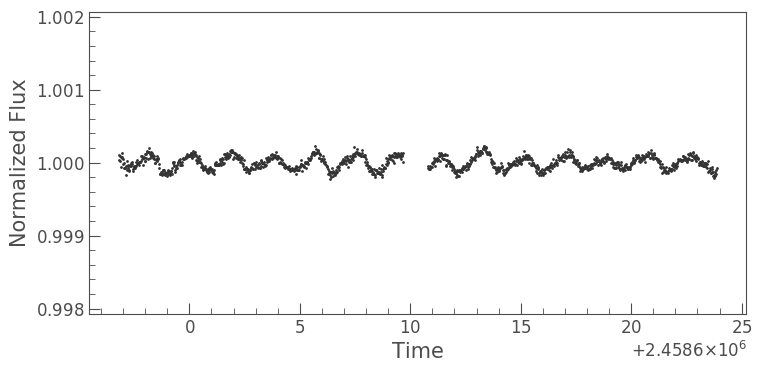

In [681]:
lc.scatter()

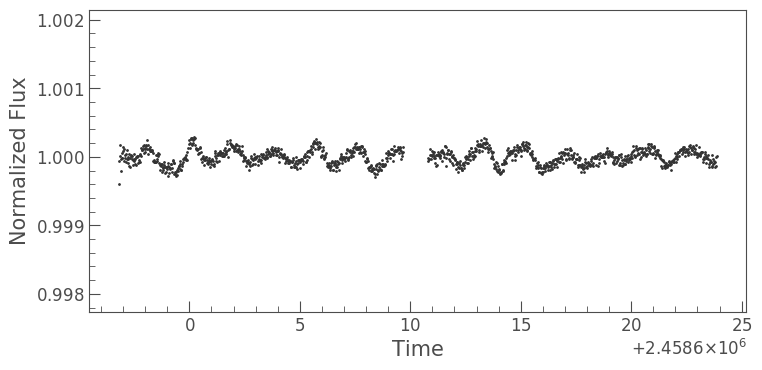

In [678]:
lc.scatter()

In [632]:
np.int(d.split('-')[1][2:])

8

In [626]:
n_lc = np.array(n_lc)

In [606]:
n_lc

array([0., 0., 4., 4., 5., 5., 5., 1., 5., 1., 5., 1., 1., 5., 5., 4., 5.,
       5., 5., 5., 0., 5., 4., 1., 4., 1., 4., 5., 5., 1., 1., 5., 4., 5.,
       5., 4., 5., 5., 3., 4., 4., 5., 3., 4., 0., 5., 5., 4., 5., 2., 1.,
       5., 0., 4., 1., 4., 1., 4., 5., 4., 4., 3., 4., 5., 1., 4., 4., 0.,
       5., 4., 5., 5., 4., 4., 4., 5., 4., 4., 5., 5., 5., 5., 5., 2., 4.,
       5., 5., 4., 1., 4., 4., 4., 5., 4., 2., 5., 5., 5., 5., 4., 1., 4.,
       4., 5., 1., 4., 1., 4., 4., 1., 3., 4., 5., 5., 4., 3., 4., 3., 5.,
       5., 5., 5., 0., 4., 5., 4., 5., 4., 0., 1., 4., 5., 4., 1., 5., 3.,
       4., 4., 4., 4., 4., 4., 5., 4., 5., 4., 4., 5., 5., 5., 2., 5., 5.,
       5., 3., 4., 5., 5., 4., 5., 1., 4., 2., 5., 1., 4., 4., 5., 4., 4.,
       1., 4., 4., 4., 5., 5., 3., 3., 4., 5., 4., 4., 5., 4., 5., 5., 5.,
       4., 5., 4., 5., 5., 4., 5., 5., 4., 4., 5., 5., 5., 1., 4., 4., 0.,
       1., 5., 4., 4., 4., 5., 4., 4., 5., 1., 0., 4., 4., 4., 4., 5., 5.,
       4., 4., 5., 3., 4.

In [682]:
nonzero_n = n_lc != 0

In [685]:
np.max(allmems[highprob][nonzero_n]['phot_g_mean_mag'])

17.130314

In [607]:
np.sum(n_lc != 0)/794

0.818639798488665

In [578]:
obstbl = Observations.query_criteria(objectname='Gaia DR2 '+np.str(allmems[highprob]['source_id'][2]),provenance_name='CDIPS',radius=1*u.arcsec)


In [579]:
obstbl

<Table masked=True length=4>
dataproduct_type calib_level obs_collection ...    objID       objID1   distance
     str10          int64         str4      ...    str11       str11    float64 
---------------- ----------- -------------- ... ----------- ----------- --------
      timeseries           4           HLSP ... 18004246723 18004246723      0.0
      timeseries           4           HLSP ... 18004096988 18004096988      0.0
      timeseries           4           HLSP ... 18004493332 18004493332      0.0
      timeseries           4           HLSP ... 18004372950 18004372950      0.0

In [580]:
np.str(allmems[highprob]['source_id'][2])

'5290024533163062144'

In [535]:
'5290024533163062144' in obstbl['obs_id'].filled().data[0]

False

In [594]:
starindx = np.array([i for i in range(len(obstbl)) if np.str(allmems[highprob]['source_id'][2]) in obstbl['obs_id'][i]])

In [595]:
obstbl[starindx]

<Table masked=True length=4>
dataproduct_type calib_level obs_collection ...    objID       objID1   distance
     str10          int64         str4      ...    str11       str11    float64 
---------------- ----------- -------------- ... ----------- ----------- --------
      timeseries           4           HLSP ... 18004246723 18004246723      0.0
      timeseries           4           HLSP ... 18004096988 18004096988      0.0
      timeseries           4           HLSP ... 18004493332 18004493332      0.0
      timeseries           4           HLSP ... 18004372950 18004372950      0.0

In [574]:
prods = Observations.get_product_list(obstbl[starindx])

In [575]:
prods

<Table masked=True length=4>
   obsID    obs_collection dataproduct_type ...  size  parent_obsid dataRights
   str11         str4           str10       ... int64     str11        str6   
----------- -------------- ---------------- ... ------ ------------ ----------
18003320028           HLSP       timeseries ... 334080  18003320028     PUBLIC
18003469763           HLSP       timeseries ... 279360  18003469763     PUBLIC
18003595991           HLSP       timeseries ... 322560  18003595991     PUBLIC
18003716367           HLSP       timeseries ... 380160  18003716367     PUBLIC

In [576]:
Observations.download_products(prods,download_dir='/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS')


INFO: Found cached file /Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0011-cam4-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0011-cam4-ccd2_tess_v01_llc.fits with expected size 380160. [astroquery.query]


<Table length=4>
                                                                                                             Local Path                                                                                                              ...
                                                                                                               str228                                                                                                                ...
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ ...
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0007-cam4-ccd1_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0007-cam4-ccd1_tess_v01_llc.fits ...
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0008-cam3-ccd4_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0008-cam3-ccd4_tess_v01_llc.fits ...
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0010-cam3-ccd3_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0010-cam3-ccd3_tess_v01_llc.fits ...
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CDIPS/mastDownload/HLSP/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0011-cam4-ccd2_tess_v01_llc/hlsp_cdips_tess_ffi_gaiatwo0005290024533163062144-0011-cam4-ccd2_tess_v01_llc.fits ...

In [401]:
#goodvetperiods.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/vetperiods_corrunc_good.dat',format='ascii')

In [30]:
np.sum(goodvetperiods['period_unc'] == 0)

0

In [11]:
joinallperiods = join(allmems[highprob],goodvetperiods)

In [12]:
joinallperiods2

<Table length=245>
        ra                 dec         ... CDIPS classification
     float64             float64       ... int64      str1     
------------------ ------------------- ... ----- --------------
119.22520690444166 -61.566462151161225 ...     1              C
119.49936785349912  -61.45191965058128 ...     1              C
119.98416898329307  -61.32024360559023 ...     1              C
121.13929660975464  -61.34479131354677 ...     1              C
 120.8427489599831  -61.36651762040685 ...     0              C
121.15734269335677 -61.250432702202865 ...     1              C
121.28565505123679  -61.18736195636068 ...     1              C
 120.4673702071265 -61.448401815032604 ...     1              C
120.60754413916358 -61.251825720989636 ...     1              C
 120.9091449058326 -61.202491894163856 ...     1              C
               ...                 ... ...   ...            ...
119.23937225765353 -60.298828098950274 ...     1              C
119.16704795584373 -60.245400137869524 ...     1              C
119.25403743603239  -60.19601543927814 ...     1              C
119.39598933406903   -60.1163724564806 ...     1              C
119.62697416831926 -60.157774012693494 ...     1              C
119.65314123565898  -60.03608363317619 ...     1              C
119.58748798560315  -60.01077111578304 ...     1              C
119.69235773707965  -60.02099349085033 ...     1              C
 119.1273398371943  -60.17093400484393 ...     1              C
120.06660913859132   -60.0071478066477 ...     1              C

In [64]:
joinperiods2

<Table length=86>
        ra                 dec         ... CDIPS classification
     float64             float64       ... int64      str1     
------------------ ------------------- ... ----- --------------
120.17938856509484  -61.10317052582211 ...     1              C
119.57602414533608  -61.35245976984503 ...     1              C
119.58680314089415 -61.196060838358804 ...     1              C
119.62662452597256 -61.168576005207235 ...     1              C
119.71094648064117   -61.1140488112489 ...     1              C
119.69352745414736  -61.09960558716263 ...     1              C
119.62997956802782  -61.08969061592808 ...     1              C
119.33371932380165  -61.12049818566914 ...     1              C
118.96634354343598  -61.22241062296897 ...     1              C
119.05529519298108  -61.13499095367798 ...     1              C
               ...                 ... ...   ...            ...
 119.9654316150975  -60.36926980260596 ...     1              C
119.54578810711885  -60.41739304924166 ...     1              C
118.25228534656472  -60.80257277804617 ...     1              C
118.19181270664559  -60.66487919860261 ...     1              C
118.82244990533124  -60.64201044286442 ...     1              C
119.13311338979422  -60.46808812731028 ...     1              C
118.71507656825491 -60.425062330986215 ...     1              C
118.97026410311324  -60.41473278210773 ...     1              C
119.23334771535194 -60.328402022867124 ...     1              C
119.23937225765353 -60.298828098950274 ...     1              C

In [63]:
joinperiods = join(SSMgrv2,goodvetperiods)

<Table length=86>
        ra                 dec         ... CDIPS classification
     float64             float64       ... int64      str1     
------------------ ------------------- ... ----- --------------
120.17938856509484  -61.10317052582211 ...     1              C
119.57602414533608  -61.35245976984503 ...     1              C
119.58680314089415 -61.196060838358804 ...     1              C
119.62662452597256 -61.168576005207235 ...     1              C
119.71094648064117   -61.1140488112489 ...     1              C
119.69352745414736  -61.09960558716263 ...     1              C
119.62997956802782  -61.08969061592808 ...     1              C
119.33371932380165  -61.12049818566914 ...     1              C
118.96634354343598  -61.22241062296897 ...     1              C
119.05529519298108  -61.13499095367798 ...     1              C
               ...                 ... ...   ...            ...
 119.9654316150975  -60.36926980260596 ...     1              C
119.54578810711885  -60.41739304924166 ...     1              C
118.25228534656472  -60.80257277804617 ...     1              C
118.19181270664559  -60.66487919860261 ...     1              C
118.82244990533124  -60.64201044286442 ...     1              C
119.13311338979422  -60.46808812731028 ...     1              C
118.71507656825491 -60.425062330986215 ...     1              C
118.97026410311324  -60.41473278210773 ...     1              C
119.23334771535194 -60.328402022867124 ...     1              C
119.23937225765353 -60.298828098950274 ...     1              C

In [6]:
SSMgrv

<Table length=276>
        ra                 dec         ...       e_eu_fe       flag_eu_fe
     float64             float64       ...       float64         int64   
------------------ ------------------- ... ------------------- ----------
117.99855641382302  -60.78941325596245 ...                  --         --
118.01619581164788 -60.836473321308524 ...                  --         --
 118.0416635684228  -60.74010996453281 ...                  --         --
118.11328646879662  -61.02373484248838 ...  0.1039837808747985          7
118.12745201718678  -60.82032195921853 ...                  --         --
118.19181270664559  -60.66487919860261 ...                  --         --
118.24960410301536  -61.08444077426584 ... 0.11478090716147939          7
118.24967790974463  -60.89129975872747 ...                  --         --
118.25228534656472  -60.80257277804617 ...                  --         --
118.25283684556908  -61.21775460697855 ... 0.11448564333097008          7
               ...                 ... ...                 ...        ...
120.39132695347004 -60.860565590323546 ...                  --         --
120.40889647173576  -60.41888185470601 ...                  --         --
120.41737748816388  -60.78519199939722 ...                  --         --
120.44696016428436   -60.5836336744805 ...                  --         --
120.48248209311991  -60.71546490049718 ...                  --         --
120.54146332498883  -60.71166749415453 ...                  --         --
120.57805474887596   -60.7551238449648 ...                  --         --
120.64714932207069  -60.67208171402578 ...                  --         --
120.72979871981326  -60.65676218309254 ...                  --         --
120.82428814028738   -60.8327930050643 ...                  --         --

In [40]:
joinallperiods['source_id','ra','dec','proba','period','period_unc'].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/joinallperiods.tex',format='latex')



In [49]:
Table(data=[joinallperiods['source_id'],joinallperiods['ra'],joinallperiods['dec'],joinallperiods['proba'],joinallperiods['period'],joinallperiods['period_unc'],joinallperiods['bp_rp']],names=['sourceid','ra','dec','prob','period','e_period','bp_rp']).write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/table1_bprp.dat',format='ascii')


In [255]:
import sigfig as sf


In [709]:
#periodius_err = np.array([np.mean((finalresults['r_hi_err'][i],finalresults['r_lo_err'][i])) for i in range(len(joinallperiods))])
import sigfig as sf


periodtbl = []
for i in range(len(joinallperiods_ss)):
    #periodiunc = np.str(sf.round(periodius_err[i],sigfigs=2))
    periodiuncDec = sf.round(sf.Decimal(joinallperiods_ss['e_period'][i]),sigfigs=2)
    periodiunc = periodiuncDec.to_eng_string()
    decplaces = len(periodiunc)-2
    periodiDec = sf.round(sf.Decimal(joinallperiods_ss['period'][i]),decimals=decplaces)
    periodi = periodiDec.to_eng_string()
    periodtbl += [periodi + ' plusminus ' + periodiunc]
periodtbl = np.array(periodtbl)



In [710]:
periodtbl

array(['2.492 plusminus 0.010', '3.765 plusminus 0.060',
       '2.687 plusminus 0.021', '3.809 plusminus 0.057',
       '6.108 plusminus 0.081', '3.674 plusminus 0.085',
       '3.95 plusminus 0.23', '4.521 plusminus 0.075',
       '2.2869 plusminus 0.0083', '3.69 plusminus 0.13',
       '2.514 plusminus 0.024', '2.0179 plusminus 0.0083',
       '3.747 plusminus 0.044', '2.0655 plusminus 0.0083',
       '5.11 plusminus 0.17', '1.906 plusminus 0.017',
       '4.88 plusminus 0.25', '3.67 plusminus 0.12',
       '1.923 plusminus 0.060', '2.934 plusminus 0.055',
       '2.260 plusminus 0.021', '0.846 plusminus 0.010',
       '3.707 plusminus 0.062', '2.61 plusminus 0.11',
       '2.074 plusminus 0.017', '3.539 plusminus 0.072',
       '5.07 plusminus 0.29', '1.115 plusminus 0.021',
       '5.3 plusminus 1.0', '3.239 plusminus 0.048',
       '0.2548 plusminus 0.0083', '0.2661 plusminus 0.0083',
       '0.221 plusminus 0.010', '1.208 plusminus 0.023',
       '0.3125 plusminus 0.0031', '3.62

In [711]:
bprptbl = []
for i in range(len(joinallperiods_ss)):
    #bprpiunc = np.str(sf.round(bprpius_err[i],sigfigs=2))
    #bprpiuncDec = sf.round(sf.Decimal(deltaM[i]),sigfigs=2)
    bprpiuncDec = sf.round(sf.Decimal(joinallperiods_ss['e_bp_rp'][i]),sigfigs=2)
    bprpiunc = bprpiuncDec.to_eng_string()
    decplaces = len(bprpiunc)-2
    bprpiDec = sf.round(sf.Decimal(joinallperiods_ss['bp_rp'][i]),decimals=decplaces)
    bprpi = bprpiDec.to_eng_string()
    bprptbl += [bprpi + ' plusminus ' + bprpiunc]
bprptbl = np.array(bprptbl)

In [712]:
textbl1 = Table(data=[joinallperiods_ss['source_id'],np.round(joinallperiods_ss['ra'],2),np.round(joinallperiods_ss['dec'],2),np.round(joinallperiods_ss['proba'],1),bprptbl,periodtbl],names=['sourceid','ra','dec','prob','bp_rp','period'])
                   
#tbl1 = Table(data=[joinallperiods_ss['source_id'],joinallperiods_ss['ra'],joinallperiods_ss['dec'],joinallperiods_ss['proba'],joinallperiods_ss['bp_rp'],deltaM.data,joinallperiods_ss['period'],joinallperiods_ss['period_unc']],names=['source_id','ra','dec','proba','bp_rp','e_bp_rp','period','e_period'])
tbl1 = Table(data=[joinallperiods_ss['source_id'],joinallperiods_ss['ra'],joinallperiods_ss['dec'],joinallperiods_ss['proba'],joinallperiods_ss['bp_rp'],joinallperiods_ss['e_bp_rp'],joinallperiods_ss['period'],joinallperiods_ss['e_period']],names=['source_id','ra','dec','proba','bp_rp','e_bp_rp','period','e_period'])

                   
                   

In [713]:
textbl1sort = textbl1.sort('bp_rp')

In [714]:
tbl1.sort('bp_rp')

In [715]:
tbl1.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/tbl1/tbl1_cdips.txt',format='ascii')

In [716]:
textbl1[0:10].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/tbl1_cdips10.tex',format='latex')

In [719]:
tbl1

<Table length=150>
     source_id              ra         ...       e_period      
       int64             float64       ...       float64       
------------------- ------------------ ... --------------------
5290024533163062144 120.92347226164134 ... 0.022821593331864384
5289930181318610432 121.13929660975464 ...  0.04082453826112902
5290671286515023744 119.38225580226509 ... 0.013176128742572775
5290868820655092992 120.21154427209193 ...   0.0625002330634743
5290739147002207232 119.26231707080545 ... 0.008333311043679714
5290771204639131648   120.228700819357 ... 0.010206185665620355
5290738356723303936 119.35428362253285 ... 0.009820902125930463
5290740929411321216 119.04806504267103 ... 0.024295220358423353
5291032132489758208 119.25403743603239 ... 0.038640199562189524
5289934751163440000 121.15734269335677 ...  0.22916500363498926
                ...                ... ...                  ...
5290741449104650112 118.88633000457749 ... 0.008333310391753912
5290642046382523008 119.57602414533608 ...  0.16319173703138473
5290730350909320704 118.86533058171912 ... 0.047507189210716526
5290655687198404864 119.62997956802782 ... 0.015590133293138702
5289999862870907776 120.85807466127473 ... 0.010206127721486975
5289958425026796288 121.28565505123679 ...  0.00833327267318964
5290716675733528960 119.06029229768161 ... 0.008333314489573241
5290717156769863296 118.96738202201645 ... 0.003124992828816175
5289992990923208704 120.20560823917725 ... 0.031249761348590255
5290713686436348800 118.74796896100209 ... 0.010206187490632429

In [718]:
np.mean(joinallperiods['period_unc']/joinallperiods['period'])

NameError: name 'joinallperiods' is not defined

In [31]:
#for i in range(len(joinallperiods)):
np.array(['Gaia DR2 ' + np.str(joinallperiods['source_id'][i]) for i in range(len(joinallperiods))]).tofile('/Users/bhealy/Downloads/names_ssperiods.txt',sep='\n')

In [32]:
names = joinallperiods['source_id'].data
rns = names.astype(str)
rns = ['Gaia DR2 ' + x +'\n' for x in rns]
with open('/Users/bhealy/Downloads/names_ssperiods.txt',mode='a+') as file:
    file.writelines(rns)
file.close()

In [ ]:
plt.scatter(joinallperiods['vsini'])

In [122]:
SSMpers = join(SSMgrv2,joinallperiods_ss)

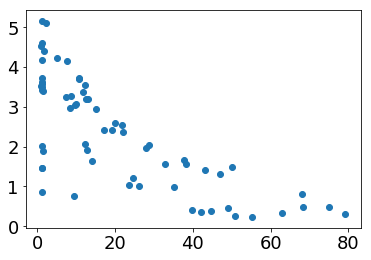

In [123]:
plt.scatter(SSMpers['vsini'],SSMpers['period'])
#plt.scatter(SSMpers['vsini'],SSMpers['period'])

In [88]:
bprp_errors=pd.read_csv('/Users/bhealy/Downloads/bprp_errors_cdips.csv')

In [119]:
JAP_pd = joinallperiods_ss.to_pandas()

In [120]:
JAP_merge=pd.merge(JAP_pd,bprp_errors,on='source_id')

In [121]:
joinallperiods_merge=Table(data=JAP_merge.values,names=JAP_merge.columns,dtype=JAP_merge.dtypes)

In [122]:
#deltaM = log(F+deltaF)/0.4
deltaF = np.sqrt((1/joinallperiods_merge['phot_bp_mean_flux_over_error'])**2 + (1/joinallperiods_merge['phot_rp_mean_flux_over_error'])**2)
deltaM = np.log10(1+deltaF)/0.4



In [123]:
deltaM

<Column name='phot_bp_mean_flux_over_error' dtype='float64' length=194>
0.0015301764488046433
0.0015751867543111239
0.0013426194989962054
0.0014166488568545035
 0.010213779517166942
0.0016218296748859626
 0.002815318382629387
0.0030095624993939983
 0.004302874096340326
 0.011841648701365828
0.0011828880773659025
 0.012988573597252511
                  ...
0.0035496769291536367
 0.003515413071404375
0.0021389491350700474
0.0018440947105750546
0.0015351771125935918
 0.004321686925756517
  0.00246677739835125
0.0011841568071301203
 0.006268851105253305
0.0026934122708492407
 0.005136064400665435
 0.006918470825306689

In [48]:
np.max(joinallperiods['period'])

5.972800361481495

In [16]:
joinallperiods_ss['bp_rp']

<Column name='bp_rp' dtype='float64' length=150>
   0.91643524
   0.86011696
    1.0594654
    0.9818678
    1.1193619
    0.9109278
   0.99221325
   0.98701096
   0.97792053
    1.9942207
     1.466156
    1.9184017
          ...
   0.86971855
    0.9367199
    0.9114685
-0.0077381134
    1.6290855
   0.77696323
    0.8867407
    0.4116087
    1.0116549
   0.59317017
    2.1946259
    1.0114918

In [150]:
from scipy.optimize import brentq
def bprp_to_bv(bv,bprp):
    #return -.1103 * bv**2 + 1.315 * bv - 0.01146 - bprp
    return 0.1117 * bv**3 -.3357 * bv**2 + 1.6814 * bv + 0.0187 - bprp

def bv_to_bprp(bv):
    return 0.1117 * bv**3 -.3357 * bv**2 + 1.6814 * bv + 0.0187

In [153]:
ebprp_tbl = ascii.read('/Users/bhealy/Downloads/e_bp_rp_tbl.csv')

In [154]:
new_joinallperiods = join(joinallperiods_ss,ebprp_tbl['source_id','e_bp_min_rp_val'])

NameError: name 'joinallperiods_ss' is not defined

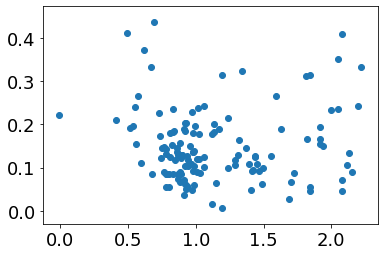

In [11]:
plt.scatter(new_joinallperiods['bp_rp'],new_joinallperiods['e_bp_min_rp_val'])

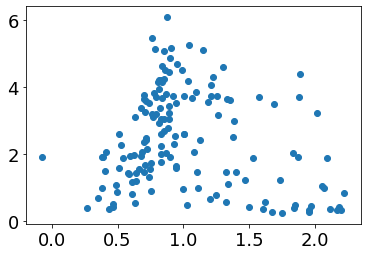

In [12]:
plt.scatter(joinallperiods_ss['bp_rp'] - new_joinallperiods['e_bp_min_rp_val'].filled(0),joinallperiods_ss['period'])

In [13]:
np.mean(new_joinallperiods['e_bp_min_rp_val'])

0.14736131386861312

In [14]:
np.std(new_joinallperiods['e_bp_min_rp_val'])

0.08359063375060924

In [151]:
#brentq(bprp_to_bv,-5,5,args=joinallperiods_ss['bp_rp'])

b_v = np.array([brentq(bprp_to_bv,-5,5,args=x) for x in joinallperiods_ss['bp_rp']-new_joinallperiods['e_bp_min_rp_val'].filled(0.122)])

b_v_test = np.array([brentq(bprp_to_bv,-5,5,args=x) - 0.07096774194 for x in joinallperiods_ss['bp_rp']])

b_v_final = np.array([brentq(bprp_to_bv,-5,5,args=x) - 0.07096774194 for x in finalresults['bp_rp']])

#b_v = np.array([brentq(bprp_to_bv,-5,5,args=x) for x in joinallperiods_ss['bp_rp']-new_joinallperiods['e_bp_min_rp_val'].filled(0.)])

#b_v = np.array([brentq(bprp_to_bv,-5,5,args=x) for x in joinallperiods_ss['bp_rp']-0.2])



NameError: name 'joinallperiods_ss' is not defined

In [24]:
brentq(bprp_to_bv,-5,5,args=0.092)

0.043975068396398025

In [25]:
bv_to_bprp(0.07096774194)

0.1363743591628355

In [233]:
##f_bv = np.sqrt(b_v - 0.5) - 0.15*(b_v - 0.5)

##p_isochrone = np.sqrt(100) * f_bv

bvarr = np.arange(0,3,0.01)
#age = 251.2
age = 140
p_isochrone_450 = 450**0.55 * 0.4*(bvarr - 0.45)**0.31
p_isochrone_350 = 350**0.55 * 0.4*(bvarr - 0.45)**0.31

p_isochrone_age = age**0.55 * 0.4*(bvarr - 0.45)**0.31
#p_isochrone_age = age**0.55 * 0.4*(bvarr - 0.45)**0.31

p_isochrone_age_a = age**0.57 * 0.7*(bvarr - 0.45)**0.36
p_isochrone_age_b = age**0.46 * 0.35*(bvarr - 0.45)**0.29


p_isochrone_140 = 140**0.55 * 0.4*(bvarr - 0.45)**0.31
p_isochrone_140_a = 140**0.57 * 0.7*(bvarr - 0.45)**0.36
p_isochrone_140_b = 140**0.46 * 0.35*(bvarr - 0.45)**0.29

p_isochrone_140 = 140**0.55 * 0.4*(bvarr - 0.45)**0.31

cseq_isochrone = 0.2*np.exp(age/(100*(bvarr +0.1-(1/3000)*age)**3))
#cseq_isochrone = 0.2*np.exp(age/100*(bvarr +0.1-(1/3000)*age)**3)


kc = 0.646
ki = 452

#p0 = 1.1
p0 = 0.12

tauarr = np.arange(p0,1000.0,0.1)

cseq_tau = p0*np.exp(kc*age/tauarr)
#cseq_tau = np.exp(kc*age/tauarr)

iseq_tau = np.sqrt(p0**2 + (2*tauarr*age)/ki)

xarr = np.arange(1,100,0.1)
#sol_plus = (0.65*age + np.sqrt((0.65*age)**2 - 23.4*(xarr**2-1)*np.log(xarr)))/(2*np.log(xarr))
#sol_minus = (0.65*age - np.sqrt((0.65*age)**2 - 23.4*(xarr**2-1)*np.log(xarr)))/(2*np.log(xarr))

sol_plus = (kc*age + np.sqrt((kc*age)**2 - 2*ki*kc*0.12**2*(xarr**2-1)*np.log(xarr)))/(2*np.log(xarr))
sol_minus = (kc*age - np.sqrt((kc*age)**2 - 2*ki*kc*1.1**2*(xarr**2-1)*np.log(xarr)))/(2*np.log(xarr))
#sol_minus_2 = (kc*150 - np.sqrt((kc*150)**2 - 2*ki*kc*3.4**2*(xarr**2-1)*np.log(xarr)))/(2*np.log(xarr))

divider = tauarr/(p0 * np.sqrt(ki*kc))

#sol_plus = (kc*age + np.sqrt((kc*age)**2 - 2*ki*kc*0.12**2*(xarr**2-1)*np.log(xarr)))/(2*np.log(xarr))
#sol_minus = (kc*age - np.sqrt((kc*age)**2 - 2*ki*kc*1.1**2*(xarr**2-1)*np.log(xarr)))/(2*np.log(xarr))

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  
/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  
/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power
/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py

(1, 400)

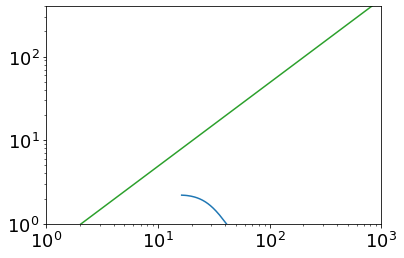

In [234]:
plt.plot(sol_plus,xarr*p0)
plt.plot(sol_minus,xarr*p0)
plt.plot(tauarr,divider)

plt.yscale('log')
plt.xscale('log')

plt.xlim(1,1000)
plt.ylim(1,400)

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """


(1.5620694876548213e-10, 1000)

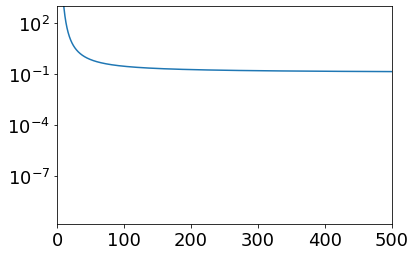

In [235]:

plt.plot(tauarr,cseq_tau)
plt.yscale('log')
plt.xlim(0,500)
plt.ylim(0,1000)

In [163]:
bk10 = ascii.read('/Users/bhealy/Downloads/barnes_kim_10.txt')
bk10

<Table length=28>
  col1    col2    col3     col4    col5  ...  col20   col21   col22   col23 
float64 float64 float64  float64 float64 ... float64 float64 float64 float64
------- ------- -------- ------- ------- ... ------- ------- ------- -------
   0.15 3.50961 -2.53866     0.5   339.8 ...  14.982   13.42  12.265  10.819
    0.2 3.52474 -2.28585     0.5   367.9 ...  14.095  12.563  11.471  10.129
   0.25 3.53505 -2.10378     0.5   408.6 ...  13.434  11.939  10.896   9.634
    0.3 3.54339 -1.95807     0.5   493.0 ...  12.916  11.442  10.436   9.238
   0.35 3.55082 -1.81901     0.5   358.4 ...   12.44  10.986  10.004   8.864
    0.4 3.55929 -1.69122     0.5   222.1 ...  11.983  10.545   9.588   8.515
   0.45  3.5695 -1.55867     0.5   176.9 ...   11.47  10.061   9.135   8.148
    0.5 3.58154 -1.42169     0.5   146.8 ...  10.937   9.561   8.671   7.768
   0.55 3.59551 -1.28094     0.5   125.4 ...   10.37   9.039   8.188   7.376
    0.6 3.61129 -1.13877     0.5   106.8 ...    9.79   8.514   7.711   6.984
    ...     ...      ...     ...     ... ...     ...     ...     ...     ...
   1.05 3.76739 -0.02597     0.5   28.64 ...   5.515   4.888   4.538   4.209
    1.1 3.77903  0.07324     0.5   21.93 ...   5.186   4.615   4.291   3.983
   1.15 3.78948  0.16746     0.5   14.67 ...   4.901   4.369   4.066   3.774
    1.2 3.79899  0.25725     0.5   8.141 ...   4.627   4.134   3.849   3.573
   1.25 3.80807  0.34281     0.5   2.394 ...   4.368   3.911   3.644   3.383
    1.3  3.8176  0.42605     0.5     0.0 ...   4.115   3.693   3.445     3.2
   1.35 3.82645   0.5053     0.5     0.0 ...   3.884    3.49   3.257   3.027
    1.4 3.83525  0.58081     0.5     0.0 ...   3.659   3.294   3.077   2.862
   1.45 3.84458  0.65226     0.5     0.0 ...   3.446   3.109    2.91   2.711
    1.5 3.85476  0.72048     0.5     0.0 ...   3.242   2.934   2.752   2.569

In [223]:
bk_b_v = bk10['col12'] - bk10['col13']
#bk_b_v = bk10['col20'] - bk10['col21']

bk_tau = bk10['col5']

#bkTbl = Table(data=[bk_tau[5:-5],bk_b_v[5:-5]],names=['tau','b-v'])
bkTbl = Table(data=[bk_tau,bk_b_v],names=['tau','b-v'])

In [224]:
bkTbl.sort('tau')

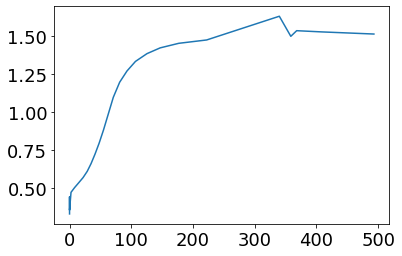

In [225]:
plt.plot(bkTbl['tau'],bkTbl['b-v'])

In [236]:
bv_interp_plus = np.interp(sol_plus,bkTbl['tau'],bkTbl['b-v'])
bv_interp_minus = np.interp(sol_minus,bkTbl['tau'],bkTbl['b-v'])
#bv_interp_minus_2 = np.interp(sol_minus_2,bkTbl['tau'],bkTbl['b-v'])

In [237]:
bv_interp = np.interp(tauarr,bkTbl['tau'],bkTbl['b-v'])

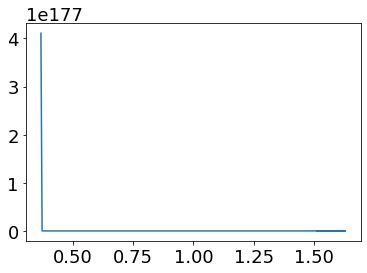

In [238]:
plt.plot(bv_interp,cseq_tau)

In [170]:
tauarr

array([1.2000e-01, 2.2000e-01, 3.2000e-01, ..., 9.9972e+02, 9.9982e+02,
       9.9992e+02])

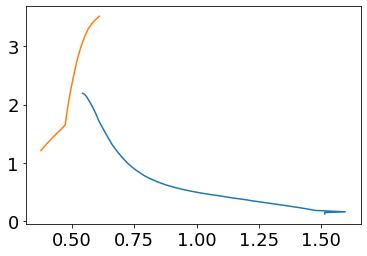

In [239]:
plt.plot(bv_interp_plus,xarr*0.12)
plt.plot(bv_interp_minus,xarr*1.1)

In [172]:
plt.plot(bvarr,p_iso)

NameError: name 'p_iso' is not defined

In [721]:
print()

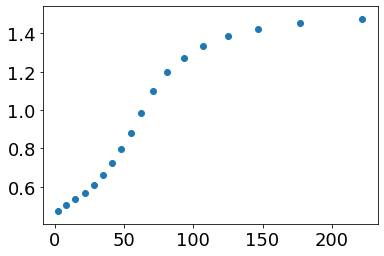

In [173]:
plt.scatter(bk_tau[5:-5],bk_b_v[5:-5])
#plt.scatter(sol_plus,np.zeros(len(sol_minus)))

(array([13.,  5.,  3.,  1.,  1.,  0.,  1.,  2.,  1.,  1.]),
 array([  0. ,  49.3,  98.6, 147.9, 197.2, 246.5, 295.8, 345.1, 394.4,
        443.7, 493. ]),
 <a list of 10 Patch objects>)

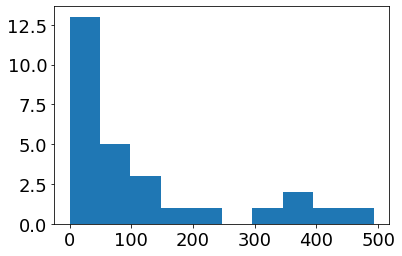

In [174]:
plt.hist(bk_tau)

(0, 2)

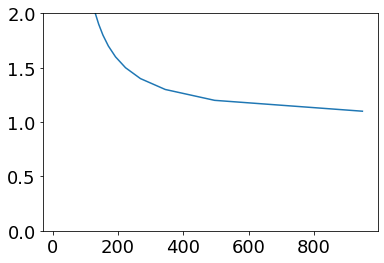

In [175]:
plt.plot(sol_plus,xarr)
plt.ylim(0,2)

In [366]:
np.nanargmin(sol_plus)

7

In [367]:
xarr[7]

0.9000000000000001

(0, 500)

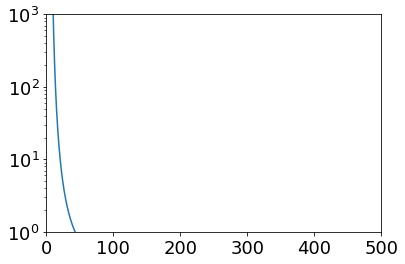

In [176]:
plt.plot(tauarr,cseq_tau)
plt.yscale('log')
plt.ylim(1,1000)
plt.xlim(0,500)

In [178]:
plt.scatter(finalperiods['bp_rp'],b_v_test)
plt.plot([0,2.5],[0,2.5])

NameError: name 'b_v_test' is not defined

(-0.1, 7.5)

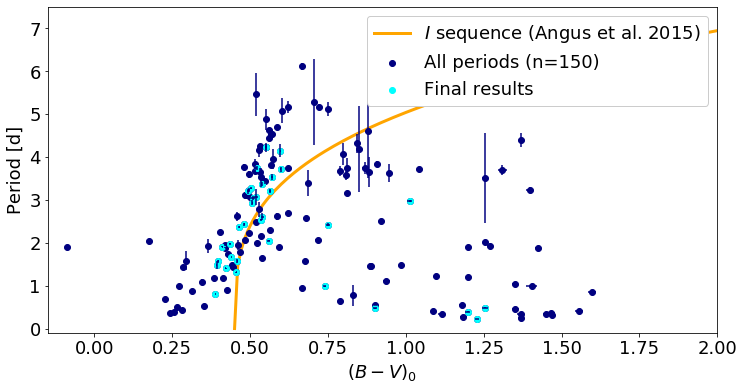

In [44]:
plt.figure(figsize=(12,6))
plt.scatter(b_v_test,joinallperiods_ss['period'],color='navy',label='All periods (n=150)')
plt.scatter(b_v_final,finalresults['period'],color='cyan',label='Final results')

#plt.scatter(joinallperiods_ss['bp_rp'],joinallperiods_ss['period'],color='navy')
plt.errorbar(b_v_test,joinallperiods_ss['period'],xerr=joinallperiods_ss['e_bp_rp'],yerr=joinallperiods_ss['e_period'],linestyle='none',color='navy',label='')

#plt.plot(bvarr,p_isochrone_450,color='maroon',linewidth=3)
#plt.plot(bvarr,p_isochrone_350,color='red',linewidth=3)
plt.plot(bvarr,p_isochrone_age,color='orange',linewidth=3,zorder=0,label=r'$I$ sequence (Angus et al. 2015)')
#plt.plot(bvarr,p_isochrone_age_a,color='orange',linewidth=2,linestyle='--',zorder=0)
#plt.plot(bvarr,p_isochrone_age_b,color='orange',linewidth=2,linestyle='--',zorder=0)

#plt.plot(bvarr,p_isochrone_150,color='gold',linewidth=3)

###plt.plot(bvarr,cseq_isochrone,color='firebrick',linewidth=3,zorder=0,linestyle='--',label=r'$C$ sequence (Barnes 2003)')

plt.legend(loc=1,framealpha=1)

plt.xlabel('$(B - V)_{0}$')
plt.ylabel('Period [d]')
plt.xlim(-0.1,2.75)
plt.xlim(-0.15,2.)

plt.ylim(-0.1,7.5)

(-0.1, 7.5)

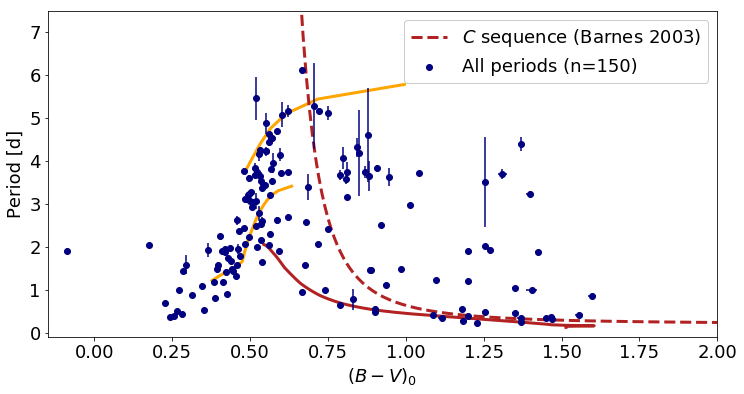

In [847]:
plt.figure(figsize=(12,6))
plt.scatter(b_v_test,joinallperiods_ss['period'],color='navy',label='All periods (n=150)')
#plt.scatter(joinallperiods_ss['bp_rp'],joinallperiods_ss['period'],color='navy')
plt.errorbar(b_v_test,joinallperiods_ss['period'],xerr=joinallperiods_ss['e_bp_rp'],yerr=joinallperiods_ss['e_period'],linestyle='none',color='navy',label='')

#plt.plot(bvarr,p_isochrone_450,color='maroon',linewidth=3)
#plt.plot(bvarr,p_isochrone_350,color='red',linewidth=3)
#plt.plot(bvarr,p_isochrone_age,color='orange',linewidth=3,zorder=0,label=r'$I$ sequence (Angus et al. 2015)')
#plt.plot(bvarr,p_isochrone_age_a,color='orange',linewidth=2,linestyle='--',zorder=0)
#plt.plot(bvarr,p_isochrone_age_b,color='orange',linewidth=2,linestyle='--',zorder=0)

#plt.plot(bv_interp_plus,xarr*p0)
#plt.plot(bv_interp_minus,xarr*p0)

plt.plot(bv_interp_plus,xarr*0.12,linewidth=3,color='firebrick',zorder=0)
plt.plot(bv_interp_minus,xarr*1.1,linewidth=3,color='orange',zorder=0)
plt.plot(bv_interp_minus_2,xarr*3.4,linewidth=3,color='orange',zorder=0)


#plt.plot(bvarr,p_isochrone_150,color='gold',linewidth=3)

plt.plot(bvarr,cseq_isochrone,color='firebrick',linewidth=3,zorder=0,linestyle='--',label=r'$C$ sequence (Barnes 2003)')

plt.legend(loc=1,framealpha=1)

plt.xlabel('$(B - V)_{0}$')
plt.ylabel('Period [d]')
plt.xlim(-0.1,2.75)
plt.xlim(-0.15,2.)

plt.ylim(-0.1,7.5)

In [296]:
joinallperiods_ss[np.argmin(b_v_test)]

<Row index=141>
        ra                dec              source_id              l                  b              parallax        parallax_error          pmra             pmra_error           pmdec            pmdec_error     ra_dec_corr ra_parallax_corr ra_pmra_corr ra_pmdec_corr dec_parallax_corr dec_pmra_corr dec_pmdec_corr parallax_pmra_corr parallax_pmdec_corr pmra_pmdec_corr phot_g_n_obs phot_g_mean_mag     bp_rp           proba       cluster  astrometric_gof_al astrometric_chi2_al astrometric_excess_noise astrometric_excess_noise_sig       period             e_period          e_period_hwhm    e_period_mad     e_period_std     CDIPS classification phot_bp_mean_flux_over_error phot_rp_mean_flux_over_error phot_g_mean_flux_over_error        e_bp_rp               e_gmag       
     float64            float64              int64             float64            float64           float64            float64            float64             float64            float64             float64         float64       float64        float64       float64         float64         float64       float64          float64             float64           float64        int64         float64        float64         float64        str8        float64             float64               float64                    float64                 float64             float64              float64         float64          float64        int64      str1                float64                      float64                      float64                  float64              float64       
------------------ ------------------ ------------------- ----------------- ------------------- ---------------- ------------------- ------------------ ------------------- ------------------ ------------------- ----------- ---------------- ------------ ------------- ----------------- ------------- -------------- ------------------ ------------------- --------------- ------------ --------------- ------------- ----------------- -------- ------------------ ------------------- ------------------------ ---------------------------- ------------------ -------------------- ------------------- ------------ -------------------- ----- -------------- ---------------------------- ---------------------------- --------------------------- --------------------- --------------------
120.92347226164134 -60.90750623116792 5290024533163062144 274.2925144464865 -15.323833878671998 2.38695081266727 0.03733233081021125 -4.322659177281228 0.07563342464480956 11.272285125118083 0.07246332425329853  0.17067564       0.16761108  0.016199568   0.043572016        0.33409497   0.086991735     -0.3497119         0.12214134        -0.060588226      0.16407593          409        8.262502 -0.0077381134 0.699999988079071 NGC_2516          15.810993           693.32874      0.09850280158662086           2.8659240562280126 1.8970088558271523 0.022821593331864384 0.44790764444041997          0.0 0.010206001681590544     1              C                    1141.1287                     670.3808                   2267.0063 0.0018767582904795196 0.000478823905519282

(18, 7)

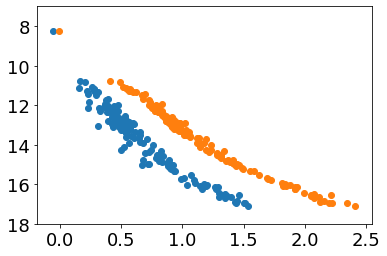

In [45]:
plt.scatter(b_v,joinallperiods_ss['phot_g_mean_mag'])
plt.scatter(joinallperiods_ss['bp_rp'],joinallperiods_ss['phot_g_mean_mag'])

plt.ylim(18,7)

In [231]:
bprp_sim = np.arange(0.5,2.7,0.01)
log10p=np.zeros(len(bprp_sim))
agenew=140*1e6
ca = 0.65
c0 = -4.7 
c1 = 0.72 
c2 = -4.9
c3 = 29 
c4 = -38
b0 = 0.9 
b1 = -13.6

cap = 0.65 + 0.05
c0p = -4.7 + 0.5
c1p = 0.72 + 0.05
c2p = -4.9 + 0.2
c3p = 29 + 2
c4p = -38 + 4
b0p = 0.9 + 0.5
b1p = -13.6 + 1

cam = 0.65 - 0.05
c0m = -4.7 - 0.5
c1m = 0.72 - 0.05
c2m = -4.9 - 0.2
c3m = 29 - 2
c4m = -38 - 4
b0m = 0.9 - 0.5
b1m = -13.6 - 1
exparr=np.array([0,1,2,3,4])
constarr = np.array([c0,c1,c2,c3,c4])
constarr_p = np.array([c0p,c1p,c2p,c3p,c4p])
constarr_m = np.array([c0m,c1m,c2m,c3m,c4m])

log10p = np.array([ca * np.log10(agenew) + np.sum(constarr*(np.log10(x)**exparr)) for x in bprp_sim])
log10p_perr = np.array([cap * np.log10(agenew) + np.sum(constarr_p*(np.log10(x)**exparr)) for x in bprp_sim])

log10p_merr = np.array([cam * np.log10(agenew) + np.sum(constarr_m*(np.log10(x)**exparr)) for x in bprp_sim])

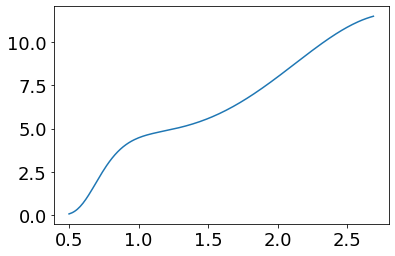

In [201]:
plt.plot(bprp_sim,10**log10p)

In [206]:
av=0.22
#av= 3.1 * 0.12
c1b,c2b,c3b,c4b,c5b,c6b,c7b = 1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043
c1r,c2r,c3r,c4r,c5r,c6r,c7r = 0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006

In [207]:
bprp=finalperiods['bp_rp']

ab = av* (c1b + c2b*bprp + c3b*bprp**2 + c4b*bprp**3 + c5b*av + c6b*av**2 + c7b*bprp*av)
ar = av* (c1r + c2r*bprp + c3r*bprp**2 + c4r*bprp**3 + c5r*av + c6r*av**2 + c7r*bprp*av)


(array([38., 17., 23., 41., 18.,  7.,  4.,  1.,  0.,  1.]),
 array([0.09341748, 0.0959231 , 0.09842873, 0.10093435, 0.10343998,
        0.1059456 , 0.10845122, 0.11095685, 0.11346247, 0.1159681 ,
        0.11847372]),
 <a list of 10 Patch objects>)

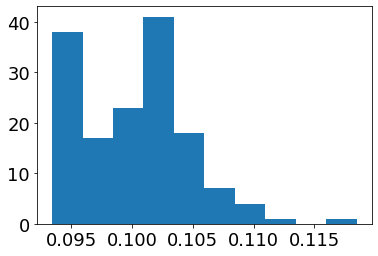

In [208]:
plt.hist(ab-ar)

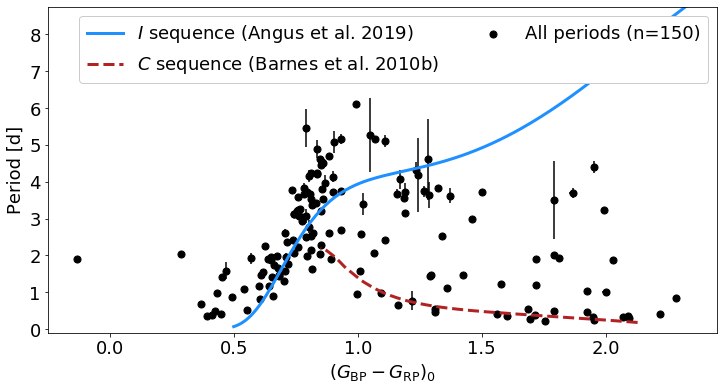

In [284]:
#gvsini = joinperiods['vsini']>5
#bright = joinallperiods['phot_g_mean_mag'] <= 20
rfig,ax = plt.subplots(1,1,figsize=(12,6))
#ax.scatter(finalperiods['bp_rp']-(ab-ar),finalperiods['period'],color='navy',s=50,label='All periods (n=150)')
ax.scatter(finalperiods['bp_rp']-0.126,finalperiods['period'],color='black',s=50,label='All periods (n=150)')

##ax[0].legend(loc=1)

#ax.errorbar(finalperiods['bp_rp']-(ab-ar),finalperiods['period'],xerr=finalperiods['e_bp_rp'],yerr=finalperiods['e_period'],linestyle='none',color='navy',label='')
ax.errorbar(finalperiods['bp_rp']-0.126,finalperiods['period'],xerr=finalperiods['e_bp_rp'],yerr=finalperiods['e_period'],linestyle='none',color='black',label='')

#plt.xlim(3500,8000)
##ax[0].set_ylim(-0.1,7.1)

#ax[0].set_xlabel('$B_{p} - R_{p}$ color')
#ax[0].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ color')
ax.set_ylabel('Period [d]')

###ax[0].scatter(b_v_test,joinallperiods_ss['period'],color='navy',label='All periods (n=150)')
#plt.scatter(joinallperiods_ss['bp_rp'],joinallperiods_ss['period'],color='navy')
###ax[0].errorbar(b_v_test,joinallperiods_ss['period'],xerr=joinallperiods_ss['e_bp_rp'],yerr=joinallperiods_ss['e_period'],linestyle='none',color='navy',label='')

#plt.plot(bvarr,p_isochrone_450,color='maroon',linewidth=3)
#plt.plot(bvarr,p_isochrone_350,color='red',linewidth=3)
#ax[0].plot(bvarr,p_isochrone_age,color='orange',linewidth=3,zorder=0,label=r'$I$ sequence (Angus et al. 2015)')
#ax.plot(bprp_sim,10**log10p,color='dodgerblue',linewidth=3,zorder=0,label=r'$I$ sequence (slow rotators)')
ax.plot(bprp_sim,10**log10p,color='dodgerblue',linewidth=3,zorder=2,label=r'$I$ sequence (Angus et al. 2019)')


#ax[0].plot(bprp_sim,10**log10p_perr,color='orange',linewidth=3,zorder=0,label='')
#ax[0].plot(bprp_sim,10**log10p_merr,color='orange',linewidth=3,zorder=0,label='')

#ax.plot(bv_to_bprp(bv_interp_plus)[5:],xarr[5:]*0.12,linewidth=3,linestyle='--',color='firebrick',zorder=0,label=r'$C$ sequence (rapid rotators)')
ax.plot(bv_to_bprp(bv_interp_plus)[5:],xarr[5:]*0.12,linewidth=3,linestyle='--',color='firebrick',zorder=2,label=r'$C$ sequence (Barnes et al. 2010b)')



ax.plot()
#plt.plot(bvarr,p_isochrone_age_a,color='orange',linewidth=2,linestyle='--',zorder=0)
#plt.plot(bvarr,p_isochrone_age_b,color='orange',linewidth=2,linestyle='--',zorder=0)

#plt.plot(bvarr,p_isochrone_150,color='gold',linewidth=3)

#ax[0].plot(bvarr,cseq_isochrone,color='firebrick',linewidth=3,zorder=0,linestyle='--',label=r'$C$ sequence (Barnes 2003)')
handles, lbls = ax.get_legend_handles_labels()

ax.legend(loc=1,framealpha=1,ncol=2)

ax.set_xlabel(r'$(G_{\rm BP} - G_{\rm RP})_{0}$')
#plt.ylabel('Period [d]')
ax.set_xlim(-0.25,2.45)
#ax[0].set_xlim(-0.15,2.1)

ax.set_ylim(-0.1,8.75)


#ax[0].axvline(.82)
#ax[1].axvline(5800)
rfig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/rotperiods_bprp_cdips_68_iso_140myr_1panel_papers_newcolors.pdf',bbox_inches='tight')


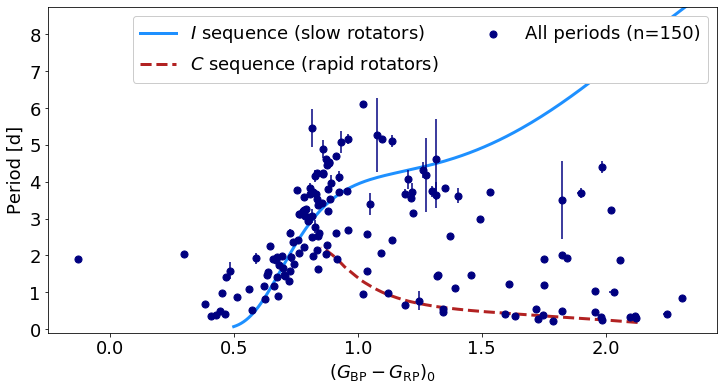

In [57]:
#gvsini = joinperiods['vsini']>5
#bright = joinallperiods['phot_g_mean_mag'] <= 20
rfig,ax = plt.subplots(1,1,figsize=(12,6))
ax.scatter(joinallperiods_ss['bp_rp']-(ab-ar),joinallperiods_ss['period'],color='navy',s=50,label='All periods (n=150)')
##ax[0].legend(loc=1)

ax.errorbar(joinallperiods_ss['bp_rp']-(ab-ar),joinallperiods_ss['period'],xerr=joinallperiods_ss['e_bp_rp'],yerr=joinallperiods_ss['e_period'],linestyle='none',color='navy',label='')
#plt.xlim(3500,8000)
##ax[0].set_ylim(-0.1,7.1)

#ax[0].set_xlabel('$B_{p} - R_{p}$ color')
#ax[0].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ color')
ax.set_ylabel('Period [d]')

###ax[0].scatter(b_v_test,joinallperiods_ss['period'],color='navy',label='All periods (n=150)')
#plt.scatter(joinallperiods_ss['bp_rp'],joinallperiods_ss['period'],color='navy')
###ax[0].errorbar(b_v_test,joinallperiods_ss['period'],xerr=joinallperiods_ss['e_bp_rp'],yerr=joinallperiods_ss['e_period'],linestyle='none',color='navy',label='')

#plt.plot(bvarr,p_isochrone_450,color='maroon',linewidth=3)
#plt.plot(bvarr,p_isochrone_350,color='red',linewidth=3)
#ax[0].plot(bvarr,p_isochrone_age,color='orange',linewidth=3,zorder=0,label=r'$I$ sequence (Angus et al. 2015)')
ax.plot(bprp_sim,10**log10p,color='dodgerblue',linewidth=3,zorder=0,label=r'$I$ sequence (slow rotators)')
#ax.plot(bprp_sim,10**log10p,color='dodgerblue',linewidth=3,zorder=0,label=r'$I$ sequence (Angus et al. 2019)')


#ax[0].plot(bprp_sim,10**log10p_perr,color='orange',linewidth=3,zorder=0,label='')
#ax[0].plot(bprp_sim,10**log10p_merr,color='orange',linewidth=3,zorder=0,label='')

ax.plot(bv_to_bprp(bv_interp_plus)[5:],xarr[5:]*0.12,linewidth=3,linestyle='--',color='firebrick',zorder=0,label=r'$C$ sequence (rapid rotators)')
#ax.plot(bv_to_bprp(bv_interp_plus)[5:],xarr[5:]*0.12,linewidth=3,linestyle='--',color='firebrick',zorder=0,label=r'$C$ sequence (Barnes et al. 2010b)')



ax.plot()
#plt.plot(bvarr,p_isochrone_age_a,color='orange',linewidth=2,linestyle='--',zorder=0)
#plt.plot(bvarr,p_isochrone_age_b,color='orange',linewidth=2,linestyle='--',zorder=0)

#plt.plot(bvarr,p_isochrone_150,color='gold',linewidth=3)

#ax[0].plot(bvarr,cseq_isochrone,color='firebrick',linewidth=3,zorder=0,linestyle='--',label=r'$C$ sequence (Barnes 2003)')
handles, lbls = ax.get_legend_handles_labels()

ax.legend(loc=1,framealpha=1,ncol=2)

ax.set_xlabel(r'$(G_{\rm BP} - G_{\rm RP})_{0}$')
#plt.ylabel('Period [d]')
ax.set_xlim(-0.25,2.45)
#ax[0].set_xlim(-0.15,2.1)

ax.set_ylim(-0.1,8.75)


#ax[0].axvline(.82)
#ax[1].axvline(5800)
#####rfig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/rotperiods_bprp_cdips_68_iso_140myr_1panel.pdf',bbox_inches='tight')


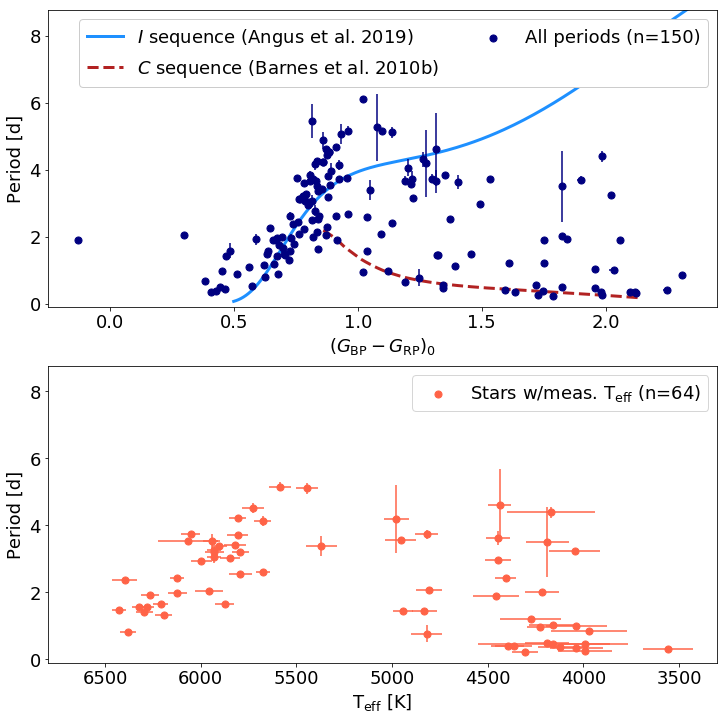

In [962]:
#gvsini = joinperiods['vsini']>5
#bright = joinallperiods['phot_g_mean_mag'] <= 20
rfig,ax = plt.subplots(2,1,figsize=(12,12))
ax[0].scatter(joinallperiods_ss['bp_rp']-(ab-ar),joinallperiods_ss['period'],color='navy',s=50,label='All periods (n=150)')
##ax[0].legend(loc=1)

ax[0].errorbar(joinallperiods_ss['bp_rp']-(ab-ar),joinallperiods_ss['period'],xerr=joinallperiods_ss['e_bp_rp'],yerr=joinallperiods_ss['e_period'],linestyle='none',color='navy',label='')
#plt.xlim(3500,8000)
##ax[0].set_ylim(-0.1,7.1)

#ax[0].set_xlabel('$B_{p} - R_{p}$ color')
#ax[0].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ color')
ax[0].set_ylabel('Period [d]')

###ax[0].scatter(b_v_test,joinallperiods_ss['period'],color='navy',label='All periods (n=150)')
#plt.scatter(joinallperiods_ss['bp_rp'],joinallperiods_ss['period'],color='navy')
###ax[0].errorbar(b_v_test,joinallperiods_ss['period'],xerr=joinallperiods_ss['e_bp_rp'],yerr=joinallperiods_ss['e_period'],linestyle='none',color='navy',label='')

#plt.plot(bvarr,p_isochrone_450,color='maroon',linewidth=3)
#plt.plot(bvarr,p_isochrone_350,color='red',linewidth=3)
#ax[0].plot(bvarr,p_isochrone_age,color='orange',linewidth=3,zorder=0,label=r'$I$ sequence (Angus et al. 2015)')
#ax[0].plot(bprp_sim,10**log10p,color='dodgerblue',linewidth=3,zorder=0,label=r'$I$ sequence (slow rotators)')
ax[0].plot(bprp_sim,10**log10p,color='dodgerblue',linewidth=3,zorder=0,label=r'$I$ sequence (Angus et al. 2019)')


#ax[0].plot(bprp_sim,10**log10p_perr,color='orange',linewidth=3,zorder=0,label='')
#ax[0].plot(bprp_sim,10**log10p_merr,color='orange',linewidth=3,zorder=0,label='')

#ax[0].plot(bv_to_bprp(bv_interp_plus)[5:],xarr[5:]*0.12,linewidth=3,linestyle='--',color='firebrick',zorder=0,label=r'$C$ sequence (rapid rotators)')
ax[0].plot(bv_to_bprp(bv_interp_plus)[5:],xarr[5:]*0.12,linewidth=3,linestyle='--',color='firebrick',zorder=0,label=r'$C$ sequence (Barnes et al. 2010b)')



ax[0].plot()
#plt.plot(bvarr,p_isochrone_age_a,color='orange',linewidth=2,linestyle='--',zorder=0)
#plt.plot(bvarr,p_isochrone_age_b,color='orange',linewidth=2,linestyle='--',zorder=0)

#plt.plot(bvarr,p_isochrone_150,color='gold',linewidth=3)

#ax[0].plot(bvarr,cseq_isochrone,color='firebrick',linewidth=3,zorder=0,linestyle='--',label=r'$C$ sequence (Barnes 2003)')
handles, lbls = ax[0].get_legend_handles_labels()

ax[0].legend(loc=1,framealpha=1,ncol=2)

ax[0].set_xlabel(r'$(G_{\rm BP} - G_{\rm RP})_{0}$')
#plt.ylabel('Period [d]')
ax[0].set_xlim(-0.25,2.45)
#ax[0].set_xlim(-0.15,2.1)

ax[0].set_ylim(-0.1,8.75)

gvsini = joinperiods2['vsini']>0
ax[1].scatter(joinperiods2['teff'],joinperiods2['period'],color='tomato',s=50,label=r'Stars w/meas. T$_{\rm eff}$ (n=64)')
ax[1].legend(loc=1)

ax[1].errorbar(joinperiods2['teff'],joinperiods2['period'],yerr=joinperiods2['e_period'],xerr=joinperiods2['e_teff'],linestyle='none',color='tomato')
ax[1].set_xlim(7400,3365)
ax[1].set_xlim(6800,3300)

ax[1].set_ylim(-0.1,8.75)
ax[1].set_xlabel(r'T$_{\rm eff}$ [K]')
ax[1].set_ylabel('Period [d]')


#ax[0].axvline(.82)
#ax[1].axvline(5800)
#rfig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/rotperiods_bprp_cdips_68_iso_140myr.pdf',bbox_inches='tight')


In [950]:
np.argmax(joinperiods2['period_unc'])

KeyError: 'period_unc'

In [102]:
joinperiods2[66]

<Row index=66>
        ra                dec              source_id              l                  b               parallax        parallax_error           pmra             pmra_error           pmdec            pmdec_error      ra_dec_corr ra_parallax_corr ra_pmra_corr ra_pmdec_corr dec_parallax_corr dec_pmra_corr dec_pmdec_corr parallax_pmra_corr parallax_pmdec_corr pmra_pmdec_corr phot_g_n_obs phot_g_mean_mag   bp_rp         proba        Cluster      Object       Icmag    Jmag    Hmag    Kmag    S/N      RV    vsini  logTeff  Nsp    pRV    pvsini       gaia_r          parallax_err     cluster   astrometric_gof_al astrometric_chi2_al astrometric_excess_noise astrometric_excess_noise_sig Survey star_id sobject_id ndfclass field_id raj2000 dej2000   jmag    hmag    kmag  vmag_jk  e_jmag  e_hmag  e_kmag  snr_c1  snr_c2  snr_c3  snr_c4 rv_synt e_rv_synt rv_obst e_rv_obst rv_nogr_obst e_rv_nogr_obst chi2_cannon sp_label_distance flag_cannon        teff             e_teff         logg   e_logg   fe_h   e_fe_h   vmic   e_vmic      e_vsini       alpha_fe e_alpha_fe  li_fe  e_li_fe flag_li_fe   c_fe   e_c_fe flag_c_fe   o_fe   e_o_fe flag_o_fe  na_fe  e_na_fe flag_na_fe  mg_fe  e_mg_fe flag_mg_fe  al_fe  e_al_fe flag_al_fe  si_fe  e_si_fe flag_si_fe   k_fe   e_k_fe flag_k_fe  ca_fe  e_ca_fe flag_ca_fe  sc_fe  e_sc_fe flag_sc_fe  ti_fe  e_ti_fe flag_ti_fe   v_fe   e_v_fe flag_v_fe  cr_fe  e_cr_fe flag_cr_fe  mn_fe  e_mn_fe flag_mn_fe  co_fe  e_co_fe flag_co_fe  ni_fe  e_ni_fe flag_ni_fe  cu_fe  e_cu_fe flag_cu_fe  zn_fe  e_zn_fe flag_zn_fe   y_fe   e_y_fe flag_y_fe  ba_fe  e_ba_fe flag_ba_fe  la_fe  e_la_fe flag_la_fe  eu_fe  e_eu_fe flag_eu_fe       period          period_unc       e_period_hwhm      e_period_mad       e_period_std    CDIPS classification
     float64            float64              int64             float64            float64            float64            float64             float64             float64            float64             float64          float64       float64        float64       float64         float64         float64       float64          float64             float64           float64        int64         float64      float64       float64         str7       str16       float64 float64 float64 float64 float64 float64 float64 float64 int64 float64 float64      float64            float64          str8         float64             float64               float64                    float64             str5   str16    int64      str8    int64   float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64  float64  float64  float64    float64       float64       float64        float64         int64         float64           float64       float64 float64 float64 float64 float64 float64      float64       float64   float64   float64 float64   int64    float64 float64   int64   float64 float64   int64   float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64   float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64   float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64   float64 float64   int64    float64 float64   int64    float64 float64   int64         float64           float64            float64           float64            float64       int64      str1     
------------------ ------------------ ------------------- ----------------- ------------------- ----------------- -------------------- ------------------ ------------------- ------------------ -------------------- ----------- ---------------- ------------ ------------- ----------------- ------------- -------------- ------------------ ------------------- --------------- ------------ --------------- --------- ------------------ ------- ---------------- --

Text(0,0.5,'Rotation Period [d]')

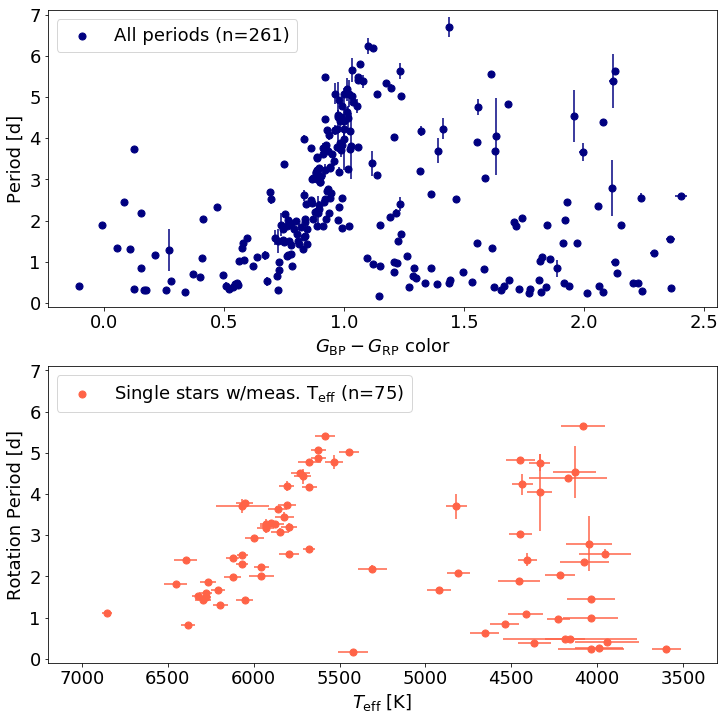

In [205]:
#gvsini = joinperiods['vsini']>5
#bright = joinallperiods['phot_g_mean_mag'] <= 20
rfig,ax = plt.subplots(2,1,figsize=(12,12))
ax[0].scatter(joinallperiods_merge['bp_rp_x'],joinallperiods_merge['period'],color='navy',s=50,label='All periods (n=261)')
ax[0].legend(loc=2)

ax[0].errorbar(joinallperiods_merge['bp_rp_x'],joinallperiods_merge['period'],xerr=deltaM,yerr=joinallperiods_merge['period_unc'],linestyle='none',color='navy')
#plt.xlim(3500,8000)
ax[0].set_ylim(-0.1,7.1)

#ax[0].set_xlabel('$B_{p} - R_{p}$ color')
ax[0].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ color')
ax[0].set_ylabel('Period [d]')

gvsini = joinperiods['vsini']>0
ax[1].scatter(joinperiods[gvsini][pgoodrv]['teff'],joinperiods[gvsini][pgoodrv]['period'],color='tomato',s=50,label=r'Single stars w/meas. T$_{\rm eff}$ (n=75)')
ax[1].legend(loc=2)

ax[1].errorbar(joinperiods[gvsini][pgoodrv]['teff'],joinperiods[gvsini][pgoodrv]['period'],yerr=joinperiods[gvsini][pgoodrv]['period_unc'],xerr=joinperiods[gvsini][pgoodrv]['e_teff'],linestyle='none',color='tomato')
ax[1].set_xlim(7200,3300)
ax[1].set_ylim(-0.1,7.1)
ax[1].set_xlabel(r'$T_{\rm eff}$ [K]')
ax[1].set_ylabel('Rotation Period [d]')

#rfig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/rotperiods_bprp.pdf',bbox_inches='tight')


In [228]:
np.sum(SSMgrv2['Survey']=='Galah')

7

In [129]:
joinallperiods_merge.add_column(Column(deltaM,'e_bp_rp'))

In [130]:
joinallperiods_merge.rename_columns(['ra_x','dec_x','bp_rp_x'],['ra','dec','bp_rp'])

In [733]:
bvtestcol = Column(b_v_test,'dereddened_b-v')

In [737]:
joinallperiods_ss.add_column(bvtestcol)

In [ ]:
joinallperiods_ss

In [131]:
joinallperiods_merge.rename_columns(['period_unc'],['e_period'])

In [738]:
joinallperiods_ss['source_id','ra','dec','proba','dereddened_b-v','period','e_period'].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig7/fig7_upperpanel_cdips.txt',format='ascii')



In [727]:
#joinperiods2.rename_column('period_unc','e_period')
joinperiods2.rename_column('Survey','survey')

In [728]:
joinperiods2['source_id','ra','dec','proba','teff','e_teff','period','e_period','survey'].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig7/fig7_lowerpanel_cdips.txt',format='ascii')




(array([ 2.,  1.,  5., 16., 14., 19., 13.,  6.,  2.,  7.]),
 array([20.9  , 21.485, 22.07 , 22.655, 23.24 , 23.825, 24.41 , 24.995,
        25.58 , 26.165, 26.75 ]),
 <a list of 10 Patch objects>)

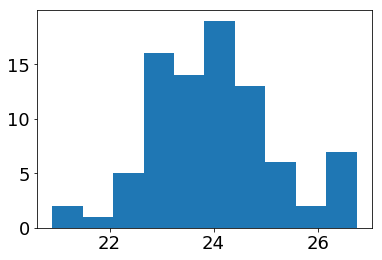

In [139]:
plt.hist(joinperiods2['RV'])

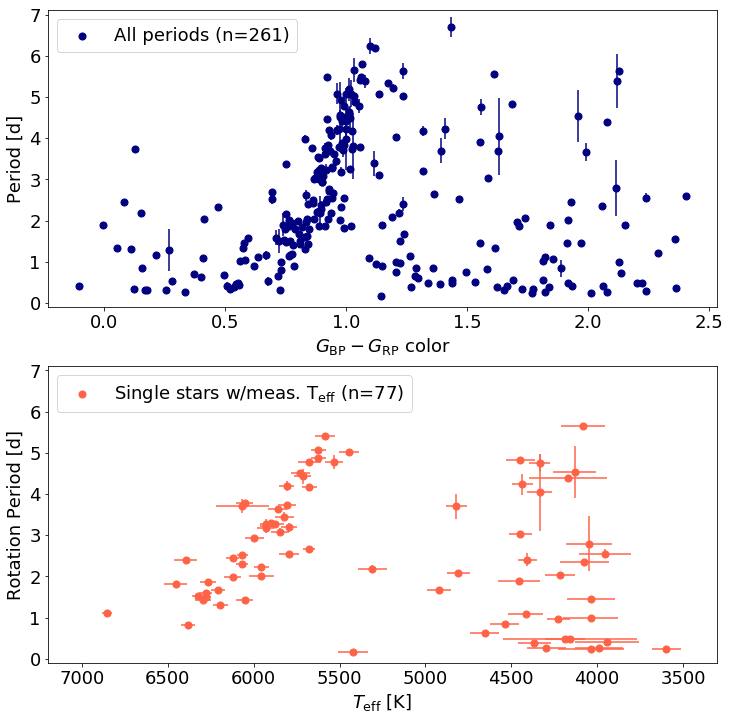

In [86]:
#gvsini = joinperiods['vsini']>5
bright = joinallperiods['phot_g_mean_mag'] <= 20
rfig,ax = plt.subplots(2,1,figsize=(12,12))
ax[0].scatter(joinallperiods[bright]['bp_rp'],joinallperiods[bright]['period'],color='navy',s=50,label='All periods (n=261)')
ax[0].legend(loc=2)

ax[0].errorbar(joinallperiods[bright]['bp_rp'],joinallperiods[bright]['period'],yerr=joinallperiods[bright]['period_unc'],linestyle='none',color='navy')
#plt.xlim(3500,8000)
ax[0].set_ylim(-0.1,7.1)

#ax[0].set_xlabel('$B_{p} - R_{p}$ color')
ax[0].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ color')
ax[0].set_ylabel('Period [d]')

gvsini = joinperiods['vsini']>0
ax[1].scatter(joinperiods[gvsini]['teff'],joinperiods[gvsini]['period'],color='tomato',s=50,label=r'Single stars w/meas. T$_{\rm eff}$ (n=77)')
ax[1].legend(loc=2)

ax[1].errorbar(joinperiods[gvsini]['teff'],joinperiods[gvsini]['period'],yerr=joinperiods[gvsini]['period_unc'],xerr=joinperiods[gvsini]['e_teff'],linestyle='none',color='tomato')
ax[1].set_xlim(7200,3300)
ax[1].set_ylim(-0.1,7.1)
ax[1].set_xlabel(r'$T_{\rm eff}$ [K]')
ax[1].set_ylabel('Rotation Period [d]')

rfig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/rotperiods.pdf',bbox_inches='tight')


In [22]:
joinallperiods[bright]

<Table length=261>
        ra                 dec         ...       period_unc      classification
     float64             float64       ...        float64             str1     
------------------ ------------------- ... --------------------- --------------
119.67760602546025 -61.638058241591146 ...   0.06478093150850794              C
119.72947963777617 -61.628932899579574 ...    0.8050710116478687              C
 119.3190554272407 -61.527369011583474 ... 0.0041667448647331184              C
119.49936785349912  -61.45191965058128 ...  0.032389514656616096              C
119.98416898329307  -61.32024360559023 ...  0.022903523456933028              C
 120.5476940093845  -61.50091466784559 ...  0.022903533214979746              C
121.13929660975464  -61.34479131354677 ...    0.0458070903596456              C
 120.8427489599831  -61.36651762040685 ...  0.022903539758380224              C
121.15734269335677 -61.250432702202865 ...  0.006944585271450402              C
 120.4673702071265 -61.448401815032604 ...  0.022903532560202264              C
               ...                 ... ...                   ...            ...
119.50151861534715   -60.1688639368416 ...   0.02644674280292799              C
119.23937225765353 -60.298828098950274 ...  0.005103198672761402              C
119.16704795584373 -60.245400137869524 ...   0.02290279710373506              C
119.25403743603239  -60.19601543927814 ...  0.022902797010748908              C
119.39433047854344   -60.2066996923345 ...  0.016137466051052846              C
119.62697416831926 -60.157774012693494 ...  0.032389810628648284              C
119.65314123565898  -60.03608363317619 ...    0.1061638851873333              C
119.58748798560315  -60.01077111578304 ...  0.004166660988948934              C
 119.1273398371943  -60.17093400484393 ...   0.09716833232223687              C
119.26348529546712  -59.95901630416561 ...  0.004166659410066132              C

In [11]:
np.sum(bright)


233

Text(0,0.5,'Rotation Period [d]')

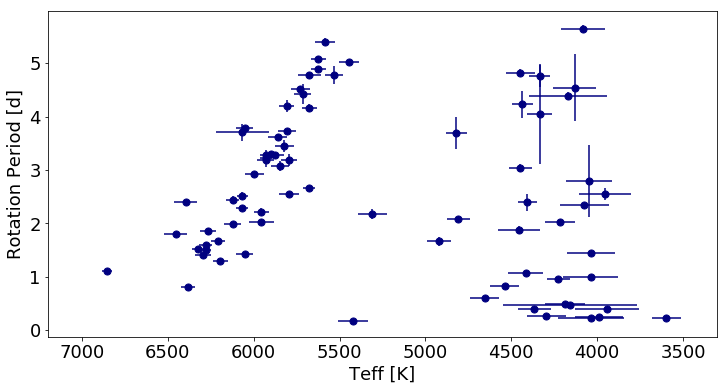

In [158]:
plt.figure(figsize=(12,6))
gvsini = joinperiods['vsini']>0
plt.scatter(joinperiods[gvsini]['teff'],joinperiods[gvsini]['period'],color='navy',s=50)
plt.errorbar(joinperiods[gvsini]['teff'],joinperiods[gvsini]['period'],yerr=joinperiods[gvsini]['period_unc'],xerr=joinperiods[gvsini]['e_teff'],linestyle='none',color='navy')
plt.xlim(7200,3300)
plt.xlabel('Teff [K]')
plt.ylabel('Rotation Period [d]')

Text(0,0.5,'Rotation Period [d]')

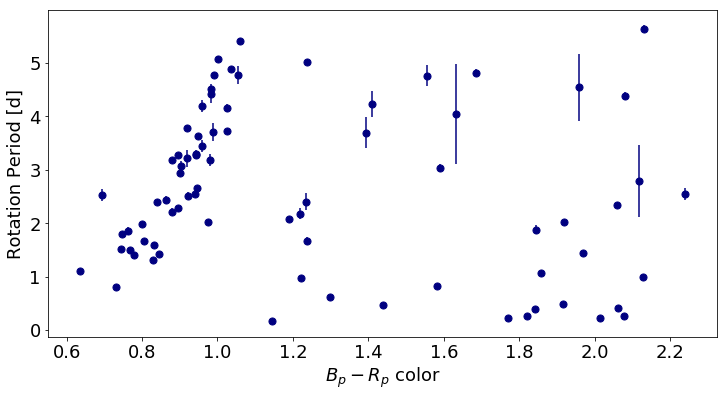

In [147]:
plt.figure(figsize=(12,6))
gvsini = joinperiods['vsini']>0
plt.scatter(joinperiods[gvsini]['bp_rp'],joinperiods[gvsini]['period'],color='navy',s=50)
plt.errorbar(joinperiods[gvsini]['bp_rp'],joinperiods[gvsini]['period'],yerr=joinperiods[gvsini]['period_unc'],linestyle='none',color='navy')
#plt.xlim(3500,8000)
plt.xlabel('$B_{p} - R_{p}$ color')

plt.ylabel('Rotation Period [d]')

Text(0,0.5,'Rotation Period [d]')

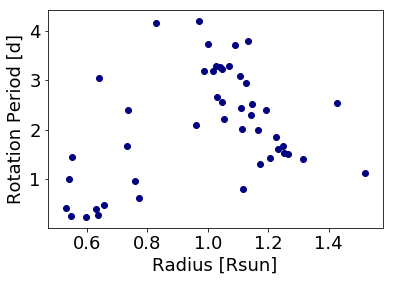

In [126]:
gvsini = joinperiods['vsini']>5
plt.scatter(joinperiods[gvsini]['gaia_r'],joinperiods[gvsini]['period'],color='navy')
#plt.errorbar(joinperiods[gvsini]['gaia_r'],joinperiods[gvsini]['period'],yerr=joinperiods[gvsini]['period_unc'],xerr=joinperiods[gvsini]['e_teff'],linestyle='none',color='navy')
#plt.xlim(3500,8000)
plt.xlabel('Radius [Rsun]')
plt.ylabel('Rotation Period [d]')

In [593]:
joinperiods.sort('period')

In [25]:
joinperiods

<Table length=77>
        ra                 dec         ...       period_unc      classification
     float64             float64       ...        float64             str1     
------------------ ------------------- ... --------------------- --------------
120.17938856509484  -61.10317052582211 ...   0.25193879525709345              C
120.34845881327385 -61.083206320085004 ...    0.9378108239803774              C
120.82428814028738   -60.8327930050643 ...    0.6281519921919559              C
119.57602414533608  -61.35245976984503 ...   0.07934010503369385              C
119.58680314089415 -61.196060838358804 ...  0.022903515727459193              C
119.62662452597256 -61.168576005207235 ... 0.0041667458483061635              C
119.71094648064117   -61.1140488112489 ...   0.11451758743598556              C
119.62997956802782  -61.08969061592808 ...  0.004166745833208552              C
119.25664864134404 -61.052291499124074 ...     0.045807018532093              C
119.23477768044064  -61.01592919157621 ...  0.022917030160965617              C
               ...                 ... ...                   ...            ...
 119.9654316150975  -60.36926980260596 ...   0.06870919848011713              C
119.54578810711885  -60.41739304924166 ...  0.005208443630749571              C
118.24967790974463  -60.89129975872747 ...    0.0647808509527586              C
118.82244990533124  -60.64201044286442 ...  0.004166741912058569              C
119.13311338979422  -60.46808812731028 ...   0.02290350551810469              C
118.76495429935075  -60.47918881500922 ...   0.06478087734123557              C
118.71507656825491 -60.425062330986215 ...  0.005103196317477721              C
118.88476009853036  -60.38588826004661 ...   0.18512675321364536              C
118.95439459043625 -60.396590019164876 ...  0.004166661016824946              C
119.23937225765353 -60.298828098950274 ...  0.005103198672761402              C

In [69]:
#pf = np.polyfit(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],3)
#i1d = interp1d(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],kind='cubic')
meds,edges,number = binned_statistic(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],statistic='median',bins=30)



In [70]:
width = (edges[1] - edges[0])
centers = edges[1:] - width/2
centers
#stdvs

array([0.01569181, 0.11167256, 0.20765332, 0.30363407, 0.39961482,
       0.49559557, 0.59157632, 0.68755708, 0.78353783, 0.87951858,
       0.97549933, 1.07148008, 1.16746084, 1.26344159, 1.35942234,
       1.45540309, 1.55138385, 1.6473646 , 1.74334535, 1.8393261 ,
       1.93530685, 2.03128761, 2.12726836, 2.22324911, 2.31922986,
       2.41521062, 2.51119137, 2.60717212, 2.70315287, 2.79913362])

In [418]:
# & ~((ges_galah_targets_updated['bp_rp'] > 1) & (ges_galah_targets_updated['phot_g_mean_mag'] < 8))
                                                   
                                                   
                                                   
                                                   
                                                   
                                                   

In [71]:
mags_interp = np.interp(allmems[highprob]['bp_rp'],centers,meds)
mags_resid = (mags_interp - allmems[highprob]['phot_g_mean_mag'])

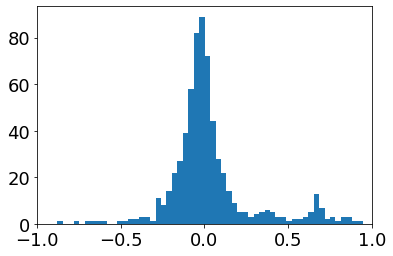

In [74]:
ssms_indx = np.abs(mags_resid) <= 0.3

plt.hist(mags_resid,bins=100)
#plt.hist(mags_resid[ssms_indx],bins=10)
#plt.hist(np.abs(mags_resid),bins=100)
plt.xlim(-1,1)
plt.show()

In [75]:
stdvs,edges,number = binned_statistic(allmems[highprob][ssms_indx]['bp_rp'],allmems[highprob][ssms_indx]['phot_g_mean_mag'],statistic='std',bins=30)






In [76]:
#cutoff_mags = np.interp(ges_galah_targets_updated['bp_rp'],centers,meds - 3*stdvs )
cutoff_mags = np.interp(allmems[highprob]['bp_rp'],centers,meds - 3*stdvs )

cutoffindx = (allmems[highprob]['phot_g_mean_mag'] - cutoff_mags  > 0)

#cutoffindx = (ges_galah_targets_updated['phot_g_mean_mag'] - cutoff_mags  > 0)
#singlestars = ges_galah_targets_updated[cutoffindx]
singlestars = allmems[highprob][cutoffindx]

In [47]:
vsini_indx = (singlestars['vsini'] >= 5)
ges_galah_targets_slice = singlestars[vsini_indx]
radius_names = ges_galah_targets_slice['source_id']



KeyError: 'vsini'

In [22]:
#finalresults = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/ngc2516finalresultstbl46_ultimate.dat')
finalresults = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/joinedfinalresults_ultimate_cdips.dat')

#finalresults = finalresults[finalresults['proba'] > 0.68]

In [48]:
singlestars

<Table length=607>
        ra                 dec         ...       proba        cluster 
     float64             float64       ...      float64         str8  
------------------ ------------------- ... ------------------ --------
120.92347226164134  -60.90750623116792 ...  0.699999988079071 NGC_2516
119.02007429823331 -60.242650314474844 ... 0.8999999761581421 NGC_2516
119.62801458151493 -60.729014545974856 ...  0.800000011920929 NGC_2516
119.18789627550726  -60.81503064475218 ... 0.8999999761581421 NGC_2516
119.83869142894031 -60.815619059384105 ...  0.699999988079071 NGC_2516
 118.3718083148051  -61.05443958533375 ... 0.8999999761581421 NGC_2516
119.59272824743998 -60.856155075718064 ... 0.8999999761581421 NGC_2516
118.96086835234338 -61.169145797709746 ...  0.699999988079071 NGC_2516
 119.8488177590863 -60.199399177833655 ...  0.800000011920929 NGC_2516
119.61366160338302  -60.80200477723087 ...                1.0 NGC_2516
               ...                 ... ...                ...      ...
119.71733136904545 -61.399736561744774 ...  0.699999988079071 NGC_2516
120.16115235798104  -61.10671579276989 ...                1.0 NGC_2516
118.99314722588028 -60.322609814371184 ... 0.8999999761581421 NGC_2516
120.40889647173576  -60.41888185470601 ... 0.8999999761581421 NGC_2516
120.42174774469711  -60.74515285966203 ...  0.800000011920929 NGC_2516
120.43011489808374 -60.257054797345646 ...  0.699999988079071 NGC_2516
120.66891417136276  -60.40556839669539 ...  0.699999988079071 NGC_2516
119.06339117109313  -60.39068739243173 ...  0.800000011920929 NGC_2516
120.23387305196745 -60.746427364138206 ...  0.800000011920929 NGC_2516
119.54954188795023  -61.02826735416334 ...  0.800000011920929 NGC_2516

In [298]:
bestfinal = bestfinal[bestfinal['proba']>0.5]

In [342]:
np.sum((bestfinal_nobinaries['teff']>4000)&(bestfinal_nobinaries['teff']<9000))

51

In [444]:
memtbl=ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CGmems_GES_Gaia_table.dat')
memtbl.remove_column('cluster')

In [462]:
ssm1 = join(memtbl,sss_merged[singindx][sshighprob])

ges_surv = []
for i in range(len(ssm1)):
    ges_surv += ['GES']
    
GEScol = Column(data=ges_surv,name='Survey')
ssm1.add_column(GEScol)
ssm1

<Table length=278>
        ra                 dec         ... astrometric_excess_noise_sig Survey
     float64             float64       ...           float64             str3 
------------------ ------------------- ... ---------------------------- ------
117.99855641382302  -60.78941325596245 ...            0.432868906772864    GES
118.01619581164788 -60.836473321308524 ...                          0.0    GES
 118.0416635684228  -60.74010996453281 ...           0.2892320121107085    GES
118.12745201718678  -60.82032195921853 ...           1.4199454436558818    GES
118.19181270664559  -60.66487919860261 ...       1.3802802276888773e-15    GES
118.24967790974463  -60.89129975872747 ...           0.1725082867816237    GES
118.25228534656472  -60.80257277804617 ...           1.7481523864263389    GES
 118.2607296948317  -60.84050260866884 ...                          0.0    GES
 118.3400837046244  -61.03688877951317 ...         0.048097726848529095    GES
118.52494354243255  -61.02361102351018 ...           2.1963095846314493    GES
               ...                 ... ...                          ...    ...
120.39132695347004 -60.860565590323546 ...                          0.0    GES
120.40889647173576  -60.41888185470601 ...           0.8874466748932285    GES
120.41737748816388  -60.78519199939722 ...                          0.0    GES
120.44696016428436   -60.5836336744805 ...           0.2154695058683865    GES
120.48248209311991  -60.71546490049718 ...           2.0840889621363368    GES
120.54146332498883  -60.71166749415453 ...           0.5061742484267527    GES
120.57805474887596   -60.7551238449648 ...           2.2648471073928422    GES
120.64714932207069  -60.67208171402578 ...           1.1022294839290256    GES
120.72979871981326  -60.65676218309254 ...           1.4062527192406955    GES
120.82428814028738   -60.8327930050643 ...           1.8341532542019912    GES

In [457]:
Counter(SSM['source_id'])

Counter({5290899881856756224: 1,
         5290898816704856320: 1,
         5290912113923645952: 1,
         5290706196007797760: 1,
         5290898988503578112: 1,
         5290913900630098304: 1,
         5290701935405663744: 1,
         5290894727896572160: 1,
         5290897541096022400: 1,
         5290682693952246656: 1,
         5290897266218055040: 1,
         5290702485161401856: 1,
         5290703069277036928: 1,
         5290689806418176768: 1,
         5290704306227620992: 1,
         5290732721731067136: 1,
         5290704409306836608: 1,
         5290921253614620928: 1,
         5290703584673116032: 1,
         5290951112226981632: 1,
         5290733168407670656: 1,
         5290923624436574336: 1,
         5290924105472526208: 1,
         5290922593644422528: 1,
         5290946782899935872: 1,
         5290731862737611648: 1,
         5290726914935470976: 1,
         5290726846215993600: 1,
         5290728834785867264: 1,
         5290731965816830080: 1,
         5

In [ ]:
5290724681552584192,5290721142499618816

In [8]:
hdulist=fits.open('/Users/bhealy/Downloads/GALAH_DR2.1_catalog.fits')

In [9]:
galahdata = Table(hdulist[1].data)

In [10]:
galahdata.rename_column('gaia_dr2_id','source_id')

In [654]:
allmems[highprob]

<Table length=650>
        ra                 dec         ...       proba        cluster 
     float64             float64       ...      float64         str8  
------------------ ------------------- ... ------------------ --------
119.91698179846047  -60.20730290913189 ...                1.0 NGC_2516
120.92347226164134  -60.90750623116792 ...  0.699999988079071 NGC_2516
119.02007429823331 -60.242650314474844 ... 0.8999999761581421 NGC_2516
119.62801458151493 -60.729014545974856 ...  0.800000011920929 NGC_2516
119.18789627550726  -60.81503064475218 ... 0.8999999761581421 NGC_2516
119.83869142894031 -60.815619059384105 ...  0.699999988079071 NGC_2516
 118.3718083148051  -61.05443958533375 ... 0.8999999761581421 NGC_2516
119.59272824743998 -60.856155075718064 ... 0.8999999761581421 NGC_2516
118.96086835234338 -61.169145797709746 ...  0.699999988079071 NGC_2516
 119.8488177590863 -60.199399177833655 ...  0.800000011920929 NGC_2516
               ...                 ... ...                ...      ...
120.16115235798104  -61.10671579276989 ...                1.0 NGC_2516
118.99314722588028 -60.322609814371184 ... 0.8999999761581421 NGC_2516
120.40889647173576  -60.41888185470601 ... 0.8999999761581421 NGC_2516
120.42174774469711  -60.74515285966203 ...  0.800000011920929 NGC_2516
120.43011489808374 -60.257054797345646 ...  0.699999988079071 NGC_2516
120.66891417136276  -60.40556839669539 ...  0.699999988079071 NGC_2516
119.06339117109313  -60.39068739243173 ...  0.800000011920929 NGC_2516
120.23387305196745 -60.746427364138206 ...  0.800000011920929 NGC_2516
119.54954188795023  -61.02826735416334 ...  0.800000011920929 NGC_2516
  119.351190251099 -61.162441506704496 ...  0.699999988079071 NGC_2516

In [11]:
galahtbl1=join(galahdata,allmems[highprob])

In [658]:
join(gestbl1,galahtbl1,keys='source_id')

<Table length=3>
       ra_1              dec_1        ...      proba_2       cluster_2
     float64            float64       ...      float64          str8  
------------------ ------------------ ... ------------------ ---------
119.52183700587412 -60.79447557489121 ... 0.8999999761581421  NGC_2516
 119.3177268629025 -60.78705110901915 ...  0.800000011920929  NGC_2516
 118.7978658769567 -60.47707150500894 ...  0.800000011920929  NGC_2516

In [276]:
join(gestbl1,galahtbl1,keys='source_id')

<Table length=3>
       ra_1              dec_1        ...      proba_2       cluster_2
     float64            float64       ...      float64          str8  
------------------ ------------------ ... ------------------ ---------
119.52183700587412 -60.79447557489121 ... 0.8999999761581421  NGC_2516
 119.3177268629025 -60.78705110901915 ...  0.800000011920929  NGC_2516
 118.7978658769567 -60.47707150500894 ...  0.800000011920929  NGC_2516

In [ ]:
#39.2 pm 2.0, 37.4 pm 1.1

In [283]:
5290933829278574208 in SSMgrv2['source_id'].data

False

In [311]:
SSMgrv2[119]['e_teff']=72.16068996744742

In [302]:
SSMgrv2[119]['vsini']=29.153714001594413

<Row index=119>
 vsini       e_vsini          RV     pRV          teff             e_teff       rv_synt
float64      float64       float64 float64      float64           float64       float64
------- ------------------ ------- ------- ----------------- ------------------ -------
   28.1 1.4050000000000002   26.11    0.28 6412.095765851615 33.087856782350045      --

In [314]:
SSMgrv2[119]['Survey'] = 'Galah'

In [330]:
SSMgrv2[152]['vsini','']

37.425568765523536

In [328]:
np.where([SSMgrv2['source_id']==5290721142499618816])

(array([0]), array([152]))

In [ ]:
#5290933829278574208 [inconsistent RVs], 5290721142499618816 [galah], 5290724681552584192

In [464]:
ssm2 = join(galahdata,sss_merged[singindx][sshighprob])
galah_surv = []
for i in range(len(ssm2)):
    galah_surv += ['Galah']
Galahcol = Column(data=galah_surv,name='Survey')

ssm2.add_column(Galahcol)

ssm2

<Table length=15>
    star_id         sobject_id   ... astrometric_excess_noise_sig Survey
     str16            int64      ...           float64             str5 
---------------- --------------- ... ---------------------------- ------
07530070-6113040 151231003701091 ...                          0.0  Galah
07525991-6105041 151231003701090 ...                          0.0  Galah
07540968-6058273 151231003701073 ...                          0.0  Galah
07522720-6101256 151231003701095 ...                          0.0  Galah
07580524-6047403 151231003701026 ...                          0.0  Galah
07571626-6047136 151231003701036 ...                          0.0  Galah
07574106-6043385 151231003701025 ...           2.4990136097204503  Galah
07572502-6039173 151231003701018 ...                          0.0  Galah
07563651-6033230 151231003701397 ...           0.3910657150507447  Galah
07562388-6030494 151231003701399 ...           1.7759326653370893  Galah
07583780-6033391 151231003701006 ...       1.9338523811705146e-15  Galah
07571618-6025379 151231003701394 ...           0.9171151864312368  Galah
07543920-6041536 151231003701063 ...                          0.0  Galah
07570097-6011457 151231003701376 ...                          0.0  Galah
07573464-6012241 151231003701373 ...            1.819105352872113  Galah

In [465]:
SSM = join(ssm1,ssm2,join_type='outer')
SSM

<Table length=293>
        ra                 dec         ...       e_eu_fe       flag_eu_fe
     float64             float64       ...       float64         int64   
------------------ ------------------- ... ------------------- ----------
117.99855641382302  -60.78941325596245 ...                  --         --
118.01619581164788 -60.836473321308524 ...                  --         --
 118.0416635684228  -60.74010996453281 ...                  --         --
118.11328646879662  -61.02373484248838 ...  0.1039837808747985          7
118.12745201718678  -60.82032195921853 ...                  --         --
118.19181270664559  -60.66487919860261 ...                  --         --
118.24960410301536  -61.08444077426584 ... 0.11478090716147939          7
118.24967790974463  -60.89129975872747 ...                  --         --
118.25228534656472  -60.80257277804617 ...                  --         --
118.25283684556908  -61.21775460697855 ... 0.11448564333097008          7
               ...                 ... ...                 ...        ...
120.39132695347004 -60.860565590323546 ...                  --         --
120.40889647173576  -60.41888185470601 ...                  --         --
120.41737748816388  -60.78519199939722 ...                  --         --
120.44696016428436   -60.5836336744805 ...                  --         --
120.48248209311991  -60.71546490049718 ...                  --         --
120.54146332498883  -60.71166749415453 ...                  --         --
120.57805474887596   -60.7551238449648 ...                  --         --
120.64714932207069  -60.67208171402578 ...                  --         --
120.72979871981326  -60.65676218309254 ...                  --         --
120.82428814028738   -60.8327930050643 ...                  --         --

In [477]:
gesindx = SSM['Survey'] == 'GES'
galahindx = SSM['Survey'] == 'Galah'

In [469]:


SSM['teff'][gesindx] = 10**SSM['logTeff'][gesindx]

In [471]:
SSM['e_teff'][gesindx] = 10**SSM['logTeff'][gesindx] / SSM['S/N'][gesindx]

In [484]:
SSM['RV'][galahindx] = SSM['rv_synt'][galahindx]

(10, 29)

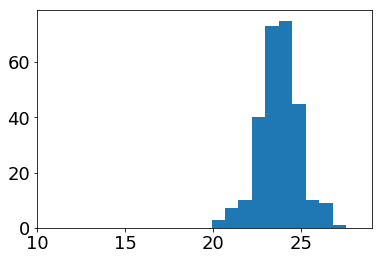

In [318]:
plt.hist(SSMgrv2['RV'],bins=10)
plt.xlim(10,29)

In [319]:
np.mean(SSMgrv2['RV']),np.std(SSMgrv2['RV'])

(23.74998034500366, 1.170438100180685)

In [129]:
goodrv = (SSM['RV'] > 15) & (SSM['RV'] < 29)

NameError: name 'SSM' is not defined

In [608]:
len(SSM[goodrv])

278

In [620]:
print(len(~goodrv),np.sum(~goodrv))

293 15


(array([  1.,   3.,   3.,  14.,  53., 101.,  69.,  19.,  10.,   3.]),
 array([18.33723188, 19.29950869, 20.2617855 , 21.22406232, 22.18633913,
        23.14861594, 24.11089275, 25.07316956, 26.03544638, 26.99772319,
        27.96      ]),
 <a list of 10 Patch objects>)

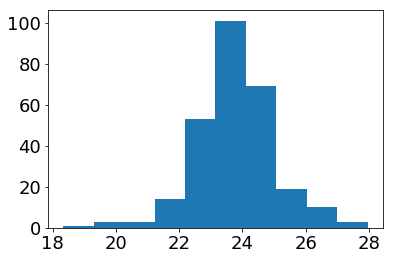

In [128]:
plt.hist(SSMgrv['RV'])

In [377]:
#goodrv = (SSMgrv['RV'] > 19.9) & (SSMgrv['RV'] < 27.7)
goodrv2 = (SSMgrv2['RV'] > 20.5) & (SSMgrv2['RV'] < 27.1)

np.sum(goodrv2)

269

In [378]:
#SSMgrv2 = SSMgrv[goodrv]
SSMgrv2[goodrv2]

<Table length=269>
        ra                 dec         ...       e_eu_fe       flag_eu_fe
     float64             float64       ...       float64         int64   
------------------ ------------------- ... ------------------- ----------
117.99855641382302  -60.78941325596245 ...                  --         --
118.01619581164788 -60.836473321308524 ...                  --         --
 118.0416635684228  -60.74010996453281 ...                  --         --
118.11328646879662  -61.02373484248838 ...  0.1039837808747985          7
118.12745201718678  -60.82032195921853 ...                  --         --
118.19181270664559  -60.66487919860261 ...                  --         --
118.24960410301536  -61.08444077426584 ... 0.11478090716147939          7
118.24967790974463  -60.89129975872747 ...                  --         --
118.25228534656472  -60.80257277804617 ...                  --         --
118.25283684556908  -61.21775460697855 ... 0.11448564333097008          7
               ...                 ... ...                 ...        ...
120.39132695347004 -60.860565590323546 ...                  --         --
120.40889647173576  -60.41888185470601 ...                  --         --
120.41737748816388  -60.78519199939722 ...                  --         --
120.44696016428436   -60.5836336744805 ...                  --         --
120.48248209311991  -60.71546490049718 ...                  --         --
120.54146332498883  -60.71166749415453 ...                  --         --
120.57805474887596   -60.7551238449648 ...                  --         --
120.64714932207069  -60.67208171402578 ...                  --         --
120.72979871981326  -60.65676218309254 ...                  --         --
120.82428814028738   -60.8327930050643 ...                  --         --

In [31]:
#SSMgrv2.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/single_stars_spec_updated_rv.dat',format='ascii')
SSMgrv2 = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/single_stars_spec_updated_rv.dat')

In [32]:
SSMgrv2 = SSMgrv2[SSMgrv2['proba']> 0.68]

In [33]:
SSMgrv2

<Table length=238>
        ra                 dec         ...       e_eu_fe       flag_eu_fe
     float64             float64       ...       float64         int64   
------------------ ------------------- ... ------------------- ----------
117.99855641382302  -60.78941325596245 ...                  --         --
118.01619581164788 -60.836473321308524 ...                  --         --
118.11328646879662  -61.02373484248838 ...  0.1039837808747985          7
118.12745201718678  -60.82032195921853 ...                  --         --
118.19181270664559  -60.66487919860261 ...                  --         --
118.24960410301536  -61.08444077426584 ... 0.11478090716147939          7
118.24967790974463  -60.89129975872747 ...                  --         --
118.25283684556908  -61.21775460697855 ... 0.11448564333097008          7
 118.3400837046244  -61.03688877951317 ...                  --         --
118.52494354243255  -61.02361102351018 ...                  --         --
               ...                 ... ...                 ...        ...
120.36491698845077  -60.69461938824408 ...                  --         --
120.38568956279128  -61.02094792875571 ...                  --         --
120.39132695347004 -60.860565590323546 ...                  --         --
120.40889647173576  -60.41888185470601 ...                  --         --
120.41737748816388  -60.78519199939722 ...                  --         --
120.44696016428436   -60.5836336744805 ...                  --         --
120.48248209311991  -60.71546490049718 ...                  --         --
120.54146332498883  -60.71166749415453 ...                  --         --
120.57805474887596   -60.7551238449648 ...                  --         --
120.64714932207069  -60.67208171402578 ...                  --         --

In [333]:
Counter(SSMgrv2['source_id'])

Counter({5290899881856756224: 1,
         5290898816704856320: 1,
         5290912113923645952: 1,
         5290706196007797760: 1,
         5290898988503578112: 1,
         5290913900630098304: 1,
         5290701935405663744: 1,
         5290894727896572160: 1,
         5290897541096022400: 1,
         5290682693952246656: 1,
         5290702485161401856: 1,
         5290703069277036928: 1,
         5290689806418176768: 1,
         5290732721731067136: 1,
         5290704409306836608: 1,
         5290921253614620928: 1,
         5290703584673116032: 1,
         5290951112226981632: 1,
         5290733168407670656: 1,
         5290923624436574336: 1,
         5290924105472526208: 1,
         5290922593644422528: 1,
         5290946782899935872: 1,
         5290731862737611648: 1,
         5290726846215993600: 1,
         5290728834785867264: 1,
         5290731965816830080: 1,
         5290934997509679232: 1,
         5290690214436590464: 1,
         5290713686436348800: 1,
         5

In [497]:
Counter(SSM[goodrv]['source_id'])

Counter({5290899881856756224: 1,
         5290898816704856320: 1,
         5290912113923645952: 1,
         5290706196007797760: 1,
         5290898988503578112: 1,
         5290913900630098304: 1,
         5290701935405663744: 1,
         5290894727896572160: 1,
         5290897541096022400: 1,
         5290682693952246656: 1,
         5290702485161401856: 1,
         5290703069277036928: 1,
         5290689806418176768: 1,
         5290732721731067136: 1,
         5290704409306836608: 1,
         5290921253614620928: 1,
         5290703584673116032: 1,
         5290951112226981632: 1,
         5290733168407670656: 1,
         5290923624436574336: 1,
         5290924105472526208: 1,
         5290922593644422528: 1,
         5290946782899935872: 1,
         5290731862737611648: 1,
         5290726846215993600: 1,
         5290728834785867264: 1,
         5290731965816830080: 1,
         5290934997509679232: 1,
         5290690214436590464: 1,
         5290713686436348800: 1,
         5

In [499]:
SSMgrv = SSM[goodrv]#['source_id']==5290724681552584192

In [504]:
gesindx = SSMgrv['Survey'] == 'GES'

In [505]:
SSMgrv['e_vsini'][gesindx] = SSMgrv['pvsini'][gesindx]*SSMgrv['vsini'][gesindx]

In [561]:
SSMgrv

<Table length=276>
        ra                 dec         ...       e_eu_fe       flag_eu_fe
     float64             float64       ...       float64         int64   
------------------ ------------------- ... ------------------- ----------
117.99855641382302  -60.78941325596245 ...                  --         --
118.01619581164788 -60.836473321308524 ...                  --         --
 118.0416635684228  -60.74010996453281 ...                  --         --
118.11328646879662  -61.02373484248838 ...  0.1039837808747985          7
118.12745201718678  -60.82032195921853 ...                  --         --
118.19181270664559  -60.66487919860261 ...                  --         --
118.24960410301536  -61.08444077426584 ... 0.11478090716147939          7
118.24967790974463  -60.89129975872747 ...                  --         --
118.25228534656472  -60.80257277804617 ...                  --         --
118.25283684556908  -61.21775460697855 ... 0.11448564333097008          7
               ...                 ... ...                 ...        ...
120.39132695347004 -60.860565590323546 ...                  --         --
120.40889647173576  -60.41888185470601 ...                  --         --
120.41737748816388  -60.78519199939722 ...                  --         --
120.44696016428436   -60.5836336744805 ...                  --         --
120.48248209311991  -60.71546490049718 ...                  --         --
120.54146332498883  -60.71166749415453 ...                  --         --
120.57805474887596   -60.7551238449648 ...                  --         --
120.64714932207069  -60.67208171402578 ...                  --         --
120.72979871981326  -60.65676218309254 ...                  --         --
120.82428814028738   -60.8327930050643 ...                  --         --

In [510]:
SSMgrv[SSMgrv['source_id']==5290724681552584192]

<Table length=2>
        ra               dec         ...       e_eu_fe       flag_eu_fe
     float64           float64       ...       float64         int64   
----------------- ------------------ ... ------------------- ----------
119.3177268629025 -60.78705110901915 ...                  --         --
119.3177268629025 -60.78705110901915 ... 0.06661193960678256          5

In [511]:
SSMgrv[SSMgrv['source_id']==5290721142499618816]

<Table length=2>
        ra                dec         ...       e_eu_fe       flag_eu_fe
     float64            float64       ...       float64         int64   
------------------ ------------------ ... ------------------- ----------
119.52183700587412 -60.79447557489121 ... 0.06535778566677174          5
119.52183700587412 -60.79447557489121 ...                  --         --

In [520]:
np.where((SSMgrv['source_id']==5290724681552584192))# & (SSMgrv['Survey']=='Galah'))[0]

(array([121]),)

In [517]:
np.where((SSMgrv['source_id']==5290721142499618816) & (SSMgrv['Survey']=='Galah'))[0]

array([155])

In [519]:
SSMgrv.remove_row(155)

In [640]:
SSMgrv=ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516_papertbls_singlestars_GESgalah_goodRV.dat')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bhealy/Documents/PhD_Thesis/NGC_2516_papertbls_singlestars_GESgalah_goodRV.dat'

In [ ]:
5290724681552584192,5290721142499618816

In [11]:
joinperiods2 = join(SSMgrv2,joinallperiods_ss)

In [12]:
joinperiods2

<Table length=64>
        ra                 dec         ...         e_gmag        
     float64             float64       ...        float64        
------------------ ------------------- ... ----------------------
118.52494354243255  -61.02361102351018 ...   0.001221244236323967
 118.5485039558298  -60.79997209857641 ...  0.0016004404510823152
118.56460008553508 -60.968824364823405 ...  0.0012821377871520526
 118.7091202133573  -60.84460613454599 ...  0.0007384941036150768
118.74796896100209  -61.07296666629273 ...  0.0013132853498470428
118.77460824476587 -61.074813094956916 ... 0.00038871946194592307
 118.8322405603062  -61.07213912553202 ...  0.0006074219784069274
118.86533058171912  -60.80378781179854 ...  0.0012388757342742418
118.88633000457749  -60.61865252762589 ...  0.0008985748143703099
118.96424957852149   -60.9670225989847 ...  0.0010375964799071364
               ...                 ... ...                    ...
120.11979893793894  -61.12912072833813 ...   0.001572379978830335
120.12015586964222  -61.01335054460787 ...  0.0006868548834010213
120.12958796129628 -60.463474414749854 ...  0.0003989371206391614
120.13826831046497  -60.52314393476707 ... 0.00045189018832559295
120.14796672848766   -60.8072755086574 ...  0.0011867783874083186
120.17938856509484  -61.10317052582211 ...  0.0010564375788265914
120.19865342401027  -60.72687838887357 ...  0.0004990065811657397
120.25893515927606  -60.75072932871493 ... 0.00027230144845363715
120.30332781353981  -60.89803478262781 ...   0.001755780590857146
120.35195969813897  -60.58772334905382 ... 0.00037616450615247254

(array([23., 22., 14., 19.,  8.]),
 array([0.22440884, 1.24494306, 2.26547727, 3.28601149, 4.3065457 ,
        5.32707992]),
 <a list of 5 Patch objects>)

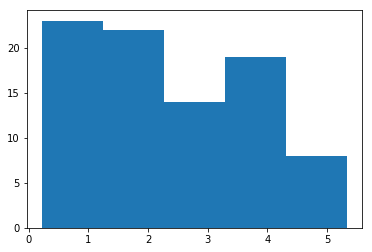

In [59]:
plt.hist(joinperiods2['period'],bins=5)

In [143]:
np.sum(SSMgrv2['vsini'] > 5)

103

In [270]:
np.sum(joinperiods2['vsini'] > 5)

57

In [161]:
np.sum((SSMpers['teff'] > 4000) & (SSMpers['teff'] < 10000))

60

In [271]:
lastcuts = (joinperiods2['vsini'] > 5) & (joinperiods2['teff']> 4000) & (joinperiods2['teff']< 10000)
np.sum(lastcuts)

53

In [272]:
joinperiods2[lastcuts]['source_id']

<Column name='source_id' dtype='int64' length=53>
5290652938419483904
5290653075858442752
5290655549759621888
5290655687198404864
5290660738079873408
5290661253475851392
5290664861248309760
5290664929967787264
5290667472588665600
5290667541308087168
5290667713106775040
5290669534172838528
                ...
5290814807146918016
5290817212328531072
5290817281048004736
5290820442143654656
5290824320493640576
5290826558177392640
5290826936134381440
5290830097230075904
5290838962037067648
5290931561536172416
5290934997509679232
5291030448862535808

In [150]:
join(joinperiods2[lastcuts],finalresults,keys='source_id')

<Table length=36>
       ra_1               dec_1        ...  bayes_sini_hi_err  
     float64             float64       ...       float64       
------------------ ------------------- ... --------------------
119.58680314089415 -61.196060838358804 ...   0.0750375187593797
119.62662452597256 -61.168576005207235 ...   0.1530765382691346
119.25664864134404 -61.052291499124074 ...  0.06303151575787891
119.65382340795934  -61.07613508250784 ...  0.05002501250625313
119.64520129184184  -61.05329746749391 ...  0.05102551275637812
119.59901513827423  -61.06229686480379 ... 0.047023511755877934
  119.413059374995    -61.035912541367 ... 0.047023511755877934
119.49029455268763  -60.89410066215391 ...  0.08804402201100547
 118.8322405603062  -61.07213912553202 ...  0.09904952476238116
118.77460824476587 -61.074813094956916 ... 0.057028514257128626
               ...                 ... ...                  ...
120.35195969813897  -60.58772334905382 ...  0.06703351675837921
119.64881348525311  -60.78119984139701 ...  0.05302651325662833
119.80580283220925 -60.673281263545306 ... 0.052026013006503335
120.13826831046497  -60.52314393476707 ...   0.0720360180090045
120.34054291297917 -60.427906385756486 ...  0.04502251125562773
120.12958796129628 -60.463474414749854 ...  0.07403701850925448
 119.9654316150975  -60.36926980260596 ... 0.032016008004002006
119.54578810711885  -60.41739304924166 ...  0.06003001500750371
119.13311338979422  -60.46808812731028 ... 0.024012006003001463
119.23937225765353 -60.298828098950274 ...  0.06703351675837921

In [583]:
#4 did not converge
#4 bad fits
#1 extra removed
44-4-1

39

In [539]:
join(SSMgrv,finalresults,keys='source_id')

<Table length=39>
       ra_1               dec_1        ...     sini_fracerr    
     float64             float64       ...       float64       
------------------ ------------------- ... --------------------
119.58680314089415 -61.196060838358804 ...  0.05437843447870166
119.62662452597256 -61.168576005207235 ...  0.12331988524009055
119.25664864134404 -61.052291499124074 ...   0.0551934690847607
119.65382340795934  -61.07613508250784 ...  0.08823844404240132
119.64520129184184  -61.05329746749391 ...  0.06699961503973195
119.59901513827423  -61.06229686480379 ...  0.04879409763402912
  119.413059374995    -61.035912541367 ...   0.0377766350232174
119.49029455268763  -60.89410066215391 ...  0.07729820410843911
 118.8322405603062  -61.07213912553202 ...  0.09309480848012205
118.77460824476587 -61.074813094956916 ...  0.05681746201342835
               ...                 ... ...                  ...
119.64881348525311  -60.78119984139701 ...  0.03990798996868303
119.80580283220925 -60.673281263545306 ...  0.05864194138591428
120.01101498685148 -60.615364780201524 ...  0.04613414863438615
120.13826831046497  -60.52314393476707 ...  0.05511775749503779
120.34054291297917 -60.427906385756486 ...   0.0659018683330901
120.12958796129628 -60.463474414749854 ...  0.05481983008791418
 119.9654316150975  -60.36926980260596 ...  0.06528291157053544
119.54578810711885  -60.41739304924166 ... 0.053505250129152936
119.13311338979422  -60.46808812731028 ...  0.03930443311566016
119.23937225765353 -60.298828098950274 ...  0.05456675742057096

In [536]:
count=0
for i in range(len(finalresults)):
    if finalresults['source_id'][i] in SSMgrv['source_id'].data:
        count += 1

In [537]:
count

39

In [435]:
join(sss_merged[singindx][sshighprob],memtbl,keys='source_id')

<Table length=278>
       ra_1               dec_1        ...     parallax_err    
     float64             float64       ...       float64       
------------------ ------------------- ... --------------------
119.57987172369998  -61.39780746301892 ...  0.02661387980422798
120.17938856509484  -61.10317052582211 ...  0.02702514122268675
120.34845881327385 -61.083206320085004 ...  0.03767192057428793
120.38568956279128  -61.02094792875571 ...  0.08699994195328958
120.82428814028738   -60.8327930050643 ...  0.04605495155445647
118.81830472644648  -61.22692449084091 ... 0.056252292560816174
119.57602414533608  -61.35245976984503 ...  0.04582771552959621
 119.7487770501742 -61.181880586440585 ... 0.016268320931681447
119.58680314089415 -61.196060838358804 ...  0.01627388280104693
119.59293899891117   -61.1854494158122 ...  0.05013178692318433
               ...                 ... ...                  ...
118.79679635804843  -60.44262426797311 ...  0.04135590861856238
118.71507656825491 -60.425062330986215 ...  0.03751363462887671
 118.9035675226624 -60.379685001973485 ... 0.018989007697269036
118.88476009853036  -60.38588826004661 ... 0.011761088269154804
118.97026410311324  -60.41473278210773 ... 0.025170754788928683
118.95439459043625 -60.396590019164876 ...   0.0330021639086082
118.68086196060591  -60.41206646666542 ... 0.014801560796745779
118.60226642685895 -60.332353202327724 ...  0.03352648976233689
119.23334771535194 -60.328402022867124 ... 0.014940905286743264
119.23937225765353 -60.298828098950274 ... 0.020841360597761233

In [14]:
excluded = []
included = []
for i in range(len(finalresults)):
    if finalresults['source_id'][i] in SSMgrv['source_id'].data:
        excluded += [False]
        included += [True]
    else:
        excluded += [True]
        included += [False]

In [15]:
finalresults[excluded][-1]['source_id','teff','vsini','e_vsini','period','period_unc','exofast_r']

<Row index=2>
     source_id             teff             vsini             e_vsini             period            period_unc      exofast_r
       int64             float64           float64            float64            float64             float64         float64 
------------------- ----------------- ------------------ ------------------ ------------------ -------------------- ---------
5291032613526130048 7609.980036885936 25.721781704801685 0.8499990167459184 0.5380964198876815 0.016137466051052846     1.758

In [615]:
sss_merged[singindx][sshighprob]


<Table length=2>
        ra                 dec         ... astrometric_excess_noise_sig
     float64             float64       ...           float64           
------------------ ------------------- ... ----------------------------
120.92347226164134  -60.90750623116792 ...           2.8659240562280126
119.83694280087349 -60.424639055921205 ...            2.965353241488826

In [65]:
np.sum(gvsini)

110

In [386]:
join(SSMgrv2[goodrv2][gvsini],goodvetperiods)

<Table length=51>
        ra                 dec         ...       period_unc      classification
     float64             float64       ...        float64             str1     
------------------ ------------------- ... --------------------- --------------
119.58680314089415 -61.196060838358804 ...  0.022903515727459193              C
119.62662452597256 -61.168576005207235 ... 0.0041667458483061635              C
119.62997956802782  -61.08969061592808 ...  0.004166745833208552              C
119.25664864134404 -61.052291499124074 ...     0.045807018532093              C
119.23477768044064  -61.01592919157621 ...  0.022917030160965617              C
119.65382340795934  -61.07613508250784 ...   0.11451758421521523              C
119.64520129184184  -61.05329746749391 ...   0.16194925843879798              C
119.59901513827423  -61.06229686480379 ...     0.068710546541598              C
  119.413059374995    -61.035912541367 ...  0.022903512215482237              C
119.49029455268763  -60.89410066215391 ...    0.1603233878274983              C
               ...                 ... ...                   ...            ...
120.01101498685148 -60.615364780201524 ...    0.0647804430433021              C
120.13826831046497  -60.52314393476707 ...  0.005103202647375712              C
120.34054291297917 -60.427906385756486 ...   0.06870921634733113              C
120.12958796129628 -60.463474414749854 ...  0.006588000661844052              C
 119.9654316150975  -60.36926980260596 ...   0.06870919848011713              C
119.54578810711885  -60.41739304924166 ...  0.005208443630749571              C
118.24967790974463  -60.89129975872747 ...    0.0647808509527586              C
119.13311338979422  -60.46808812731028 ...   0.02290350551810469              C
118.71507656825491 -60.425062330986215 ...  0.005103196317477721              C
119.23937225765353 -60.298828098950274 ...  0.005103198672761402              C

In [80]:
goodrv = (SSMgrv2['RV'] > 20.2) & (SSMgrv2['RV'] < 27.4)
SSMgrv2 = SSMgrv2[goodrv]

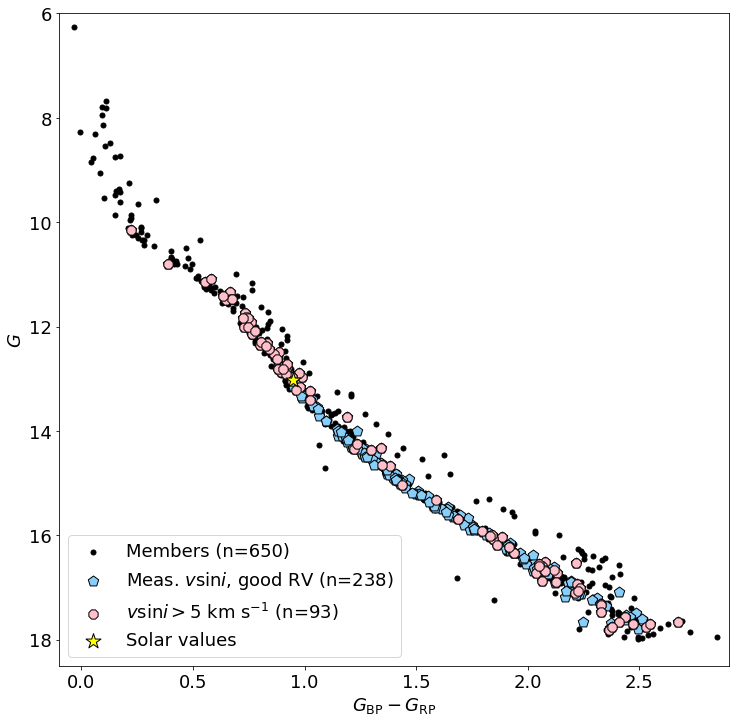

In [288]:
#sshighprob = (sss_merged[singindx]['proba'] > 0.5)
#gvsini = joinperiods['vsini'] > 5
#goodrv = (SSMgrv2['RV'] > 20.2) & (SSMgrv2['RV'] < 27.4)
gvsini = SSMgrv2['vsini'] > 5


f1 = plt.figure(figsize=(12,12))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='black',s=25,label='Members (n=650)')
#plt.scatter(allmems[highprob][ssms_indx]['bp_rp'],allmems[highprob][ssms_indx]['phot_g_mean_mag'],color='orange',s=20)
#plt.scatter(joinallperiods['bp_rp'],joinallperiods['phot_g_mean_mag'],color='gold',edgecolors='navy',label='Period (n=261)',marker='^',s=75)
plt.scatter(SSMgrv2['bp_rp'],SSMgrv2['phot_g_mean_mag'],color='lightskyblue',edgecolors='black',marker='p',label='Meas. $v\sin i$, good RV (n=238)',s=120)

#plt.scatter(ges_galah_targets_updated['bp_rp'],ges_galah_targets_updated['phot_g_mean_mag'],color='cyan',edgecolors='navy')
#plt.scatter(sss_merged[singindx][sshighprob]['bp_rp'],sss_merged[singindx][sshighprob]['phot_g_mean_mag'],color='lime',edgecolors='navy')
plt.scatter(SSMgrv2[gvsini]['bp_rp'],SSMgrv2[gvsini]['phot_g_mean_mag'],color='pink',marker='8',edgecolors='black',label='$v\sin i > 5$ km s$^{-1}$ (n=93)',s=100)

#plt.scatter(0.82+0.1363743591628355,12.67+0.215,color='yellow',marker='*',s=250,label='Solar values',edgecolors='black')
plt.scatter(0.82+0.126,12.73+0.2935,color='yellow',marker='*',s=250,label='Solar values',edgecolors='black')

#plt.scatter(joinperiods[gvsini]['bp_rp'],joinperiods[gvsini]['phot_g_mean_mag'],color='gold',edgecolors='navy',label='Spectroscopy constraints met (n=110)')

#plt.scatter(joinperiods[lastcuts]['bp_rp'],joinperiods[lastcuts]['phot_g_mean_mag'],color='lime',edgecolors='navy')

#plt.scatter(bestfinal_nobinaries['bp_rp'],bestfinal_nobinaries['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='navy',label='Stars with measured $\sin i$')
#plt.scatter(finalresults[included]['bp_rp'],finalresults[included]['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='navy',label='$\sin i$ (n=39)',s=100)

#astar = singlestars['source_id'] == 5290819342632176512
#plt.scatter(singlestars[astar]['bp_rp'],singlestars[astar]['phot_g_mean_mag'],color='pink')


#plt.scatter(ges_galah_targets_slice['bp_rp'],ges_galah_targets_slice['phot_g_mean_mag'],color='cyan',edgecolors='navy')
bprp = np.arange(np.min(allmems[highprob]['bp_rp']),np.max(allmems[highprob]['bp_rp']),.001)
plt.legend(loc=3)
#ms = pf[0]*bprp**3 + pf[1]*bprp**2 + pf[2]*bprp**1 + pf[3]*bprp**0
#plt.plot(centers,meds,linewidth=2,color='red')
#plt.plot(centers,meds+.035*meds,linewidth=2,color='red')
#plt.plot(centers,meds - 3*stdvs,linewidth=2,color='red')
#plt.plot(centers,meds+.5,linewidth=2,color='red')
#plt.plot(centers,meds+-.5,linewidth=2,color='red')
#plt.xlabel('$B_{p} - R_{p}$ color')

#plt.xlabel(r'$G_{\rm BP} - G_{\rm RP}$ color')
#plt.ylabel('$G$ magnitude')

plt.xlabel(r'$G_{\rm BP} - G_{\rm RP}$')
plt.ylabel('$G$')


plt.ylim(18.5,6)
plt.xlim(-.1,2.9)
f1.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/cmd_singlestars_new_68_newsun_newcolors.pdf',bbox_inches='tight')


In [138]:
len(SSMgrv2[gvsini])

93

In [693]:
bv_to_bprp(.22/3.1)

0.13637435915544963

In [74]:
plt.rcParams['font.size']=18

In [742]:
allmems[highprob]['source_id','ra','dec','proba','bp_rp','phot_g_mean_mag'].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig6/fig6_allmems_highprob_794.txt',format='ascii')

In [743]:
SSMgrv2['source_id','ra','dec','proba','bp_rp','phot_g_mean_mag'].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig1/fig1_singlestars_269.txt',format='ascii')

In [745]:
SSMgrv2[gvsini]['source_id','ra','dec','proba','bp_rp','phot_g_mean_mag'].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig1/fig1_goodvsini_103.txt',format='ascii')

(array([ 7.,  7., 16., 46., 62., 61., 36., 19.,  7.,  8.]),
 array([20.83 , 21.422, 22.014, 22.606, 23.198, 23.79 , 24.382, 24.974,
        25.566, 26.158, 26.75 ]),
 <a list of 10 Patch objects>)

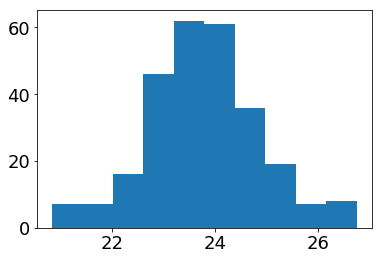

In [78]:
plt.hist(SSMgrv2[goodrv]['RV'])

In [76]:
goodrv = (SSMgrv2['RV'] > 20.2) & (SSMgrv2['RV'] < 27.4)

In [71]:
np.min(SSMgrv2['RV'])

19.91

In [141]:
np.sum(gvsini)

107

86

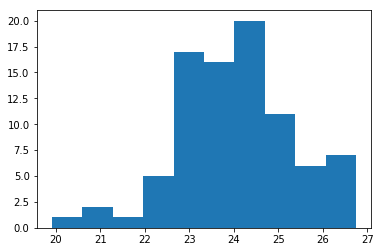

In [67]:
plt.hist(joinperiods2['RV'])
pgoodrv = (joinperiods2['RV'] > 19.9) & (joinperiods2['RV'] < 27.7)
np.sum(pgoodrv)

In [68]:
np.sum((joinperiods2['RV'] > 20.2) & (joinperiods2['RV'] < 27.4))

85

In [390]:
np.nanmax(finalresults['RV'])

26.58

In [17]:
plt.rcParams['font.size']=20

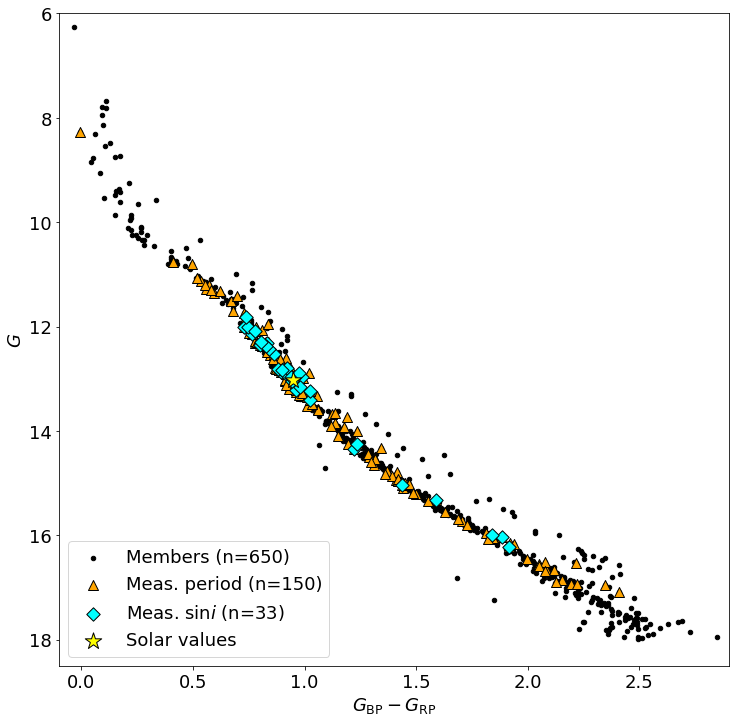

In [281]:
#sshighprob = (sss_merged[singindx]['proba'] > 0.5)
#gvsini = joinperiods2['vsini'] > 5

finalresults = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/joinedfinalresults_ultimate_cdips.dat')

f2=plt.figure(figsize=(12,12))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='black',s=20,label='Members (n=650)')
#plt.scatter(allmems[highprob][ssms_indx]['bp_rp'],allmems[highprob][ssms_indx]['phot_g_mean_mag'],color='orange',s=20)
###plt.scatter(joinallperiods_ss['bp_rp'],joinallperiods_ss['phot_g_mean_mag'],color='gold',edgecolors='navy',label='Meas. period (n=150)',marker='^',s=90)
plt.scatter(finalperiods['bp_rp'],finalperiods['phot_g_mean_mag'],color='orange',edgecolors='black',label='Meas. period (n=150)',marker='^',s=100)

#plt.scatter(ges_galah_targets_updated['bp_rp'],ges_galah_targets_updated['phot_g_mean_mag'],color='cyan',edgecolors='navy')
#plt.scatter(sss_merged[singindx][sshighprob]['bp_rp'],sss_merged[singindx][sshighprob]['phot_g_mean_mag'],color='lime',edgecolors='navy')
#plt.scatter(SSMgrv[gvsini]['bp_rp'],SSMgrv[gvsini]['phot_g_mean_mag'],color='gold',edgecolors='navy',label='Spectroscopy constraints met (n=110)')

#plt.scatter(joinperiods[gvsini]['bp_rp'],joinperiods[gvsini]['phot_g_mean_mag'],color='gold',edgecolors='navy',label='Spectroscopy constraints met (n=110)')

#plt.scatter(joinperiods[lastcuts]['bp_rp'],joinperiods[lastcuts]['phot_g_mean_mag'],color='lime',edgecolors='navy')

#plt.scatter(bestfinal_nobinaries['bp_rp'],bestfinal_nobinaries['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='navy',label='Stars with measured $\sin i$')
#plt.scatter(finalresults[included]['bp_rp'],finalresults[included]['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='navy',label='Meas. $\sin i$ (n=39)',s=100)
plt.scatter(finalresults['bp_rp'],finalresults['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='black',label='Meas. $\sin i$ (n=33)',s=90)

#plt.scatter(0.82+0.1363743591628355,12.67+0.215,color='yellow',marker='*',s=300,label='Solar values',edgecolors='black')
plt.scatter(0.82+0.126,12.73+0.2935,color='yellow',marker='*',s=300,label='Solar values',edgecolors='black')

#0.82+0.126,12.73+0.2935

#astar = singlestars['source_id'] == 5290819342632176512
#plt.scatter(singlestars[astar]['bp_rp'],singlestars[astar]['phot_g_mean_mag'],color='pink')


#plt.scatter(ges_galah_targets_slice['bp_rp'],ges_galah_targets_slice['phot_g_mean_mag'],color='cyan',edgecolors='navy')
bprp = np.arange(np.min(allmems[highprob]['bp_rp']),np.max(allmems[highprob]['bp_rp']),.001)
plt.legend(loc=3)
#ms = pf[0]*bprp**3 + pf[1]*bprp**2 + pf[2]*bprp**1 + pf[3]*bprp**0
#plt.plot(centers,meds,linewidth=2,color='red')
#plt.plot(centers,meds+.035*meds,linewidth=2,color='red')
#plt.plot(centers,meds - 3*stdvs,linewidth=2,color='red')
#plt.plot(centers,meds+.5,linewidth=2,color='red')
#plt.plot(centers,meds+-.5,linewidth=2,color='red')
#plt.xlabel('$B_{p} - R_{p}$ color')
plt.xlabel(r'$G_{\rm BP} - G_{\rm RP}$')

plt.ylabel('$G$')


plt.ylim(18.5,6)
plt.xlim(-.1,2.9)
f2.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/cmd_results_68_sun_newsun_newcolors.pdf',bbox_inches='tight')



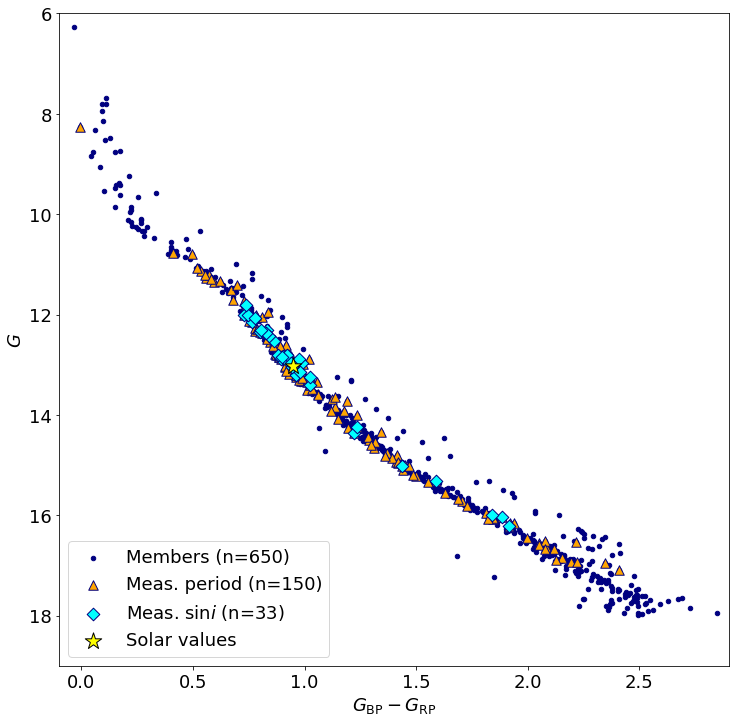

In [253]:
#sshighprob = (sss_merged[singindx]['proba'] > 0.5)
#gvsini = joinperiods2['vsini'] > 5

finalresults = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/joinedfinalresults_ultimate_cdips.dat')

f2=plt.figure(figsize=(12,12))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='navy',s=20,label='Members (n=650)')
#plt.scatter(allmems[highprob][ssms_indx]['bp_rp'],allmems[highprob][ssms_indx]['phot_g_mean_mag'],color='orange',s=20)
###plt.scatter(joinallperiods_ss['bp_rp'],joinallperiods_ss['phot_g_mean_mag'],color='gold',edgecolors='navy',label='Meas. period (n=150)',marker='^',s=90)
plt.scatter(finalperiods['bp_rp'],finalperiods['phot_g_mean_mag'],color='orange',edgecolors='navy',label='Meas. period (n=150)',marker='^',s=90)

#plt.scatter(ges_galah_targets_updated['bp_rp'],ges_galah_targets_updated['phot_g_mean_mag'],color='cyan',edgecolors='navy')
#plt.scatter(sss_merged[singindx][sshighprob]['bp_rp'],sss_merged[singindx][sshighprob]['phot_g_mean_mag'],color='lime',edgecolors='navy')
#plt.scatter(SSMgrv[gvsini]['bp_rp'],SSMgrv[gvsini]['phot_g_mean_mag'],color='gold',edgecolors='navy',label='Spectroscopy constraints met (n=110)')

#plt.scatter(joinperiods[gvsini]['bp_rp'],joinperiods[gvsini]['phot_g_mean_mag'],color='gold',edgecolors='navy',label='Spectroscopy constraints met (n=110)')

#plt.scatter(joinperiods[lastcuts]['bp_rp'],joinperiods[lastcuts]['phot_g_mean_mag'],color='lime',edgecolors='navy')

#plt.scatter(bestfinal_nobinaries['bp_rp'],bestfinal_nobinaries['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='navy',label='Stars with measured $\sin i$')
#plt.scatter(finalresults[included]['bp_rp'],finalresults[included]['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='navy',label='Meas. $\sin i$ (n=39)',s=100)
plt.scatter(finalresults['bp_rp'],finalresults['phot_g_mean_mag'],color='cyan',marker='D',edgecolors='navy',label='Meas. $\sin i$ (n=33)',s=80)

#plt.scatter(0.82+0.1363743591628355,12.67+0.215,color='yellow',marker='*',s=300,label='Solar values',edgecolors='black')
plt.scatter(0.82+0.126,12.73+0.2935,color='yellow',marker='*',s=300,label='Solar values',edgecolors='black')

#0.82+0.126,12.73+0.2935

#astar = singlestars['source_id'] == 5290819342632176512
#plt.scatter(singlestars[astar]['bp_rp'],singlestars[astar]['phot_g_mean_mag'],color='pink')


#plt.scatter(ges_galah_targets_slice['bp_rp'],ges_galah_targets_slice['phot_g_mean_mag'],color='cyan',edgecolors='navy')
bprp = np.arange(np.min(allmems[highprob]['bp_rp']),np.max(allmems[highprob]['bp_rp']),.001)
plt.legend(loc=3)
#ms = pf[0]*bprp**3 + pf[1]*bprp**2 + pf[2]*bprp**1 + pf[3]*bprp**0
#plt.plot(centers,meds,linewidth=2,color='red')
#plt.plot(centers,meds+.035*meds,linewidth=2,color='red')
#plt.plot(centers,meds - 3*stdvs,linewidth=2,color='red')
#plt.plot(centers,meds+.5,linewidth=2,color='red')
#plt.plot(centers,meds+-.5,linewidth=2,color='red')
#plt.xlabel('$B_{p} - R_{p}$ color')
plt.xlabel(r'$G_{\rm BP} - G_{\rm RP}$')

plt.ylabel('$G$')


plt.ylim(19,6)
plt.xlim(-.1,2.9)
f2.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/cmd_results_68_sun_newsun.pdf',bbox_inches='tight')



In [ ]:
len()

In [112]:
joinallperiods_merge

<Table length=245>
        ra                 dec         ...        e_bp_rp       
     float64             float64       ...        float64       
------------------ ------------------- ... ---------------------
119.22520690444166 -61.566462151161225 ...  0.005928584970657154
119.49936785349912  -61.45191965058128 ... 0.0015301764488046433
119.98416898329307  -61.32024360559023 ... 0.0015751867543111239
121.13929660975464  -61.34479131354677 ... 0.0013426194989962054
 120.8427489599831  -61.36651762040685 ... 0.0025993790508369056
121.15734269335677 -61.250432702202865 ... 0.0014166488568545035
121.28565505123679  -61.18736195636068 ...  0.010213779517166942
 120.4673702071265 -61.448401815032604 ... 0.0016218296748859626
120.60754413916358 -61.251825720989636 ...  0.002815318382629387
 120.9091449058326 -61.202491894163856 ... 0.0030095624993939983
               ...                 ... ...                   ...
119.23937225765353 -60.298828098950274 ... 0.0021389491350700474
119.16704795584373 -60.245400137869524 ... 0.0018440947105750546
119.25403743603239  -60.19601543927814 ... 0.0015351771125935918
119.39598933406903   -60.1163724564806 ...  0.004321686925756517
119.62697416831926 -60.157774012693494 ...   0.00246677739835125
119.65314123565898  -60.03608363317619 ... 0.0011841568071301203
119.58748798560315  -60.01077111578304 ...  0.006268851105253305
119.69235773707965  -60.02099349085033 ... 0.0026934122708492407
 119.1273398371943  -60.17093400484393 ...  0.005136064400665435
120.06660913859132   -60.0071478066477 ...  0.006918470825306689

In [747]:
joinallperiods_ss['source_id','ra','dec','proba','bp_rp','phot_g_mean_mag'].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig2/fig2_measured_period_150.txt',format='ascii')

In [749]:
finalresults['source_id','ra','dec','proba','bp_rp','phot_g_mean_mag'].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig2/fig2_measured_sini_33.txt',format='ascii')


In [750]:
SSS_mer = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_papertbls_singlestars.dat')

In [358]:
join(allmems[highprob],SSS_mer)

<Table length=651>
        ra                 dec         ... astrometric_excess_noise_sig
     float64             float64       ...           float64           
------------------ ------------------- ... ----------------------------
117.47640685181979  -60.71539639606229 ...           1.7654667891870834
117.68372061686728  -60.55014251025733 ...           0.8717557524493839
117.86359508823296 -61.165734269721064 ...                          0.0
117.87070182328185 -61.101393056768735 ...                          0.0
117.90316860366893  -60.23267348823982 ...            1.274101720620795
117.92707407511074  -61.32829226954036 ...                          0.0
117.96477020735708  -60.15880628811523 ...            2.775526833185336
117.97263050466844  -60.63391963890141 ...        1.364285710500665e-15
117.98577201654659 -60.889308472181845 ...        8.344901225352478e-16
117.99855641382302  -60.78941325596245 ...            0.432868906772864
               ...                 ... ...                          ...
 121.2353172881163 -61.114477339944365 ...                          0.0
121.23563921250691  -61.04624412214939 ...        6.654842448353507e-16
121.24154577210302  -60.66908349642682 ...                          0.0
121.26562003974175 -60.408726213065826 ...                          0.0
121.27967128684487  -60.94262942831992 ...            2.683247359204961
121.28565505123679  -61.18736195636068 ...                          0.0
 121.3141399602894  -60.65689502496137 ...                          0.0
121.40204878764014   -60.7658528996157 ...                          0.0
121.44956653741558 -60.474087233648916 ...                          0.0
121.55280276216841  -60.78292973495091 ...                          0.0

In [361]:
SSS_mer_spec_grv=ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_papertbls_singlestars_GESgalah_goodRV.dat')

In [375]:
np.sum((SSS_mer_spec_grv['RV'] > 20.5) & (SSS_mer_spec_grv['RV'] < 27.1) )

269

In [372]:
limindx=(SSS_mer_spec_grv['RV'] > 20.2) & (SSS_mer_spec_grv['RV'] < 27.4)

In [374]:
np.median(SSS_mer_spec_grv['RV'][limindx]), np.std(SSS_mer_spec_grv['RV'][limindx])

(23.75, 1.0943789272214597)

In [370]:
np.sum((joinperiods['RV'] > 20.2) & (joinperiods['RV'] < 27.4))

75

In [353]:
#sss_merged[singindx][sshighprob].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516_papertbls_singlestars.dat',format='ascii')



In [1196]:
singlestars.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/singlestars_twosurveys_nor_allvsini.dat',format='ascii')

In [1197]:
#cutoff_mags = np.interp(ges_galah_targets_updated['bp_rp'],centers,meds-.035*meds)
ges_galah_targets_slice.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/slice_twosurveys_nor_5vsini.dat',format='ascii')

In [1246]:
ges_galah_targets_slice[ges_galah_targets_slice['source_id'] == 5290652938419483904]

<Table length=1>
     source_id       AV_SFD AV_SandF Cluster ...   vmic   vsini    y_fe   zn_fe 
       int64        float64 float64   object ... float64 float64 float64 float64
------------------- ------- -------- ------- ... ------- ------- ------- -------
5290652938419483904  0.6338   0.5451 NGC2516 ...     nan    21.8     nan     nan

In [649]:
ges_galah_targets_updated[cutoffindx].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CMD_cutoff_GESgalah_noradii.dat',format='ascii')

In [650]:
singlestars = ges_galah_targets_updated[cutoffindx]

In [1233]:
#combin_tbl.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/combined_table_NGC_2516.dat',format='ascii')

In [ ]:
5290742857853957504
5290728834785867264

In [1243]:
ges_galah_targets_slice[(ges_galah_targets_slice['source_id'] == 5290728834785867264) | (ges_galah_targets_slice['source_id'] == 5290742857853957504)]






<Table length=2>
     source_id       AV_SFD AV_SandF Cluster ...   vmic   vsini    y_fe   zn_fe 
       int64        float64 float64   object ... float64 float64 float64 float64
------------------- ------- -------- ------- ... ------- ------- ------- -------
5290728834785867264  0.7291    0.627 NGC2516 ...     nan    15.0     nan     nan
5290742857853957504   0.597   0.5134 NGC2516 ...     nan     7.4     nan     nan

In [1315]:
ges_galah_targets_slice['logg','e_logg']


<Table length=92>
       logg              e_logg      
     float64            float64      
----------------- -------------------
              nan                 nan
              nan                 nan
              nan                 nan
              nan                 nan
              nan                 nan
              nan                 nan
              nan                 nan
              nan                 nan
              nan                 nan
              nan                 nan
              ...                 ...
4.280278786050422 0.16035037853003745
4.442332670013904 0.16225109632397952
4.556372390208162 0.05792852941542862
4.324137094153199 0.14794862954143836
4.178689217101545 0.17452782757706042
4.465804600526407  0.1637657047711181
4.400127526443337 0.15008053608223862
4.568185784652648 0.14838986467221918
              nan                 nan
              nan                 nan

In [1336]:
iso = ascii.read('/Users/bhealy/Downloads/MIST_iso_5e556cbca2933.iso')


In [1337]:
iso

<Table length=104382>
 EEP  log10_isochrone_age_yr ...       center_c12       phase 
int64        float64         ...        float64        float64
----- ---------------------- ... --------------------- -------
   14                    5.0 ... 0.0020594836027433877    -1.0
   15                    5.0 ... 0.0020594836027436085    -1.0
   16                    5.0 ... 0.0020594836027437963    -1.0
   17                    5.0 ...  0.002059483602743984    -1.0
   18                    5.0 ...  0.002059483602744172    -1.0
   19                    5.0 ... 0.0020594836027443596    -1.0
   20                    5.0 ...  0.002059483602744547    -1.0
   21                    5.0 ...  0.002059483602744734    -1.0
   22                    5.0 ...  0.002059483602744921    -1.0
   23                    5.0 ...  0.002059483602745044    -1.0
  ...                    ... ...                   ...     ...
 1701                   10.3 ...     0.313232669898523     6.0
 1702                   10.3 ...   0.31322605367680784     6.0
 1703                   10.3 ...    0.3132195667184059     6.0
 1704                   10.3 ...   0.31321313654518457     6.0
 1705                   10.3 ...    0.3132067361044888     6.0
 1706                   10.3 ...   0.31320034773454286     6.0
 1707                   10.3 ...   0.31319390404915515     6.0
 1708                   10.3 ...    0.3131873927689091     6.0
 1709                   10.3 ...     0.313180757471447     6.0
 1710                   10.3 ...    0.3131739646028163     6.0

In [1329]:
isoind = (iso['log10_isochrone_age_yr'] > 8.11) & (iso['log10_isochrone_age_yr'] < 8.19)

In [1333]:
iso[isoind]

<Table length=1554>
 EEP  log10_isochrone_age_yr ...       center_c12       phase 
int64        float64         ...        float64        float64
----- ---------------------- ... --------------------- -------
  157                   8.15 ... 0.0020594836027426366    -1.0
  158                   8.15 ... 0.0020594836027428443    -1.0
  159                   8.15 ... 0.0020594836027428894    -1.0
  160                   8.15 ... 0.0020594836027428114    -1.0
  161                   8.15 ...  0.002059483602742507    -1.0
  162                   8.15 ...  0.002059483602741794    -1.0
  163                   8.15 ...  0.002059483602740342    -1.0
  164                   8.15 ... 0.0020594836027375916    -1.0
  165                   8.15 ...  0.002059483602732598    -1.0
  166                   8.15 ...  0.002059483602723744    -1.0
  ...                    ... ...                   ...     ...
 1701                   8.15 ...    0.3872864491700501     6.0
 1702                   8.15 ...    0.3876029386774601     6.0
 1703                   8.15 ...    0.3879459992131329     6.0
 1704                   8.15 ...    0.3883203390117104     6.0
 1705                   8.15 ...    0.3887289818475366     6.0
 1706                   8.15 ...   0.38917924496504064     6.0
 1707                   8.15 ...   0.38967533981637253     6.0
 1708                   8.15 ...    0.3902262265249402     6.0
 1709                   8.15 ...   0.39084343313730835     6.0
 1710                   8.15 ...    0.3915343422843955     6.0

In [1353]:
badastrom = []
for i in range(len(radius_names)):
    qry = Gaia.query_object('Gaia DR2 '+np.str(radius_names.data[i]))
    qry0 = qry[0]
    gof = 

ValueError: coordinate must be either a string or astropy.coordinates

In [382]:
qry = Gaia.query_object('Gaia DR2 '+np.str(radius_names.data[0]),radius=0.005*u.deg)

HTTPError: Error 500: 
Cannot parse query '
      TOP 2000            SELECT
                  *,
                  DISTANCE(
                    POINT('ICRS', ra, dec),
                    POINT('ICRS', 120.92351810923466, -60.907560801034855)
                  ) AS dist
                FROM
                  gaiadr2.gaia_source
                WHERE
                  1 = CONTAINS(
                    POINT('ICRS', ra, dec),
                    CIRCLE('ICRS', 120.92351810923466, -60.907560801034855, 0.005)
                  )
                ORDER BY
                  dist ASC
                ' for job '1585163928839O':  Encountered "TOP". Was expecting: "SELECT" 


In [377]:
radius_names=singlestars['source_id'].data

In [91]:
names261 = joinallperiods['source_id'].data
rns = names261.astype(str)

In [92]:
#rns = radius_names.astype(str)
rns = names261.astype(str)

In [93]:
rns = ['Gaia DR2 ' + x +'\n' for x in rns]

In [94]:
rns = ['Gaia DR2 ' + x +'\n' for x in rns]
with open('/Users/bhealy/Downloads/261radiusnames.txt',mode='a+') as file:
    file.writelines(rns)
file.close()

In [ ]:
#deltaM = log(F+deltaF)/0.4

In [383]:
#noisetbl = pd.read_csv('/Users/bhealy/Downloads/92stars_astronoise.csv')
noisetbl = pd.read_csv('/Users/bhealy/Downloads/manystars_astronoise.csv')

noisetbl

source_id          ra  ra_error        dec  dec_error  \
0    5290024533163062144  120.923472  0.034641 -60.907506   0.039139   
1    5290739387520374912  119.227794  0.048372 -60.598424   0.050430   
2    5290673794780227072  119.592903  0.044280 -60.857672   0.040403   
3    5290949669118299776  119.020074  0.029431 -60.242650   0.030742   
4    5290769211774211968  119.990822  0.068331 -60.746749   0.068702   
5    5290816009737675392  119.628015  0.044769 -60.729015   0.052487   
6    5290722929205920640  119.187896  0.040042 -60.815031   0.039608   
7    5290767150189898496  119.838691  0.043450 -60.815619   0.046404   
8    5290818586713364352  119.811179  0.142657 -60.587058   0.155462   
9    5290702279003050496  118.371808  0.034689 -61.054440   0.040675   
10   5290673897859442304  119.592728  0.054513 -60.856155   0.050432   
11   5290662383047290496  118.960868  0.033590 -61.169146   0.034346   
12   5290847380178313856  119.848818  0.029157 -60.199399   0.033968   
13   5290721997195236480  119.533518  0.032413 -60.780499   0.028705   
14   5290814768486344320  119.613662  0.041195 -60.802005   0.039190   
15   5290949566038905984  119.008322  0.033689 -60.257461   0.036998   
16   5290723891278514048  119.083607  0.035047 -60.800910   0.035528   
17   5290696128609865600  117.800021  0.034935 -61.254517   0.040042   
18   5290722929205920896  119.192720  0.066569 -60.816144   0.060621   
19   5290722860486442752  119.196611  0.073008 -60.840801   0.066591   
20   5290719665030852096  119.295490  0.028548 -60.888892   0.030602   
21   5290816937450497408  119.712260  0.033535 -60.643112   0.034658   
22   5290718737318003840  119.407724  0.043989 -60.908858   0.040420   
23   5290772201071458944  120.143521  0.039899 -60.715498   0.044735   
24   5290673519902401024  119.600342  0.040647 -60.875217   0.036681   
25   5289976085932146560  120.308403  0.030426 -61.367705   0.031685   
26   5290722173291771136  119.488490  0.030298 -60.757245   0.028562   
27   5290821060618951296  119.646009  0.037020 -60.568292   0.038879   
28   5290730144750808192  118.838818  0.032405 -60.844385   0.031072   
29   5290721486096996736  119.450701  0.036959 -60.815748   0.036288   
..                   ...         ...       ...        ...        ...   
806  5290934993212809216  118.721094  0.110314 -60.429835   0.123842   
807  5290758143637597696  120.377860  0.103283 -60.850183   0.116027   
808  5290760965437190528  120.421748  0.094276 -60.745153   0.109500   
809  5290633559526975360  118.832134  0.102499 -61.377141   0.113728   
810  5290734916457109504  118.758579  0.100266 -60.708160   0.113189   
811  5290671973714254592  119.568868  0.090794 -60.973378   0.094108   
812  5290717500367250688  119.031917  0.113415 -60.874454   0.120296   
813  5290855042400243712  120.430115  0.088931 -60.257055   0.117357   
814  5290028102278347136  120.984189  0.088882 -60.837087   0.108907   
815  5290804391846564736  120.750124  0.133239 -60.364120   0.129359   
816  5290734267919314176  118.865233  0.108990 -60.717370   0.117791   
817  5290757254585726976  120.644543  0.064339 -60.767930   0.071995   
818  5290803876450455424  120.668914  0.093505 -60.405568   0.097390   
819  5290712788784793216  118.987516  0.100968 -61.013055   0.112193   
820  5290840680029293568  119.577204  0.070304 -60.320731   0.080114   
821  5290703477295735040  118.568857  0.100651 -60.997661   0.107322   
822  5290769211774213248  119.996940  0.159335 -60.741633   0.157435   
823  5290935993942166912  118.948578  0.073368 -60.395334   0.080764   
824  5290932935925488640  119.063391  0.083247 -60.390687   0.105972   
825  5290732824810285184  118.571613  0.087899 -60.774306   0.090660   
826  5290946198784376576  118.492209  0.106559 -60.311196   0.113447   
827  5290771234698060288  120.233873  0.091915 -60.746427   0.097878   
828  5290667124690661248  119.549542  0.100663 -61.028267   0.103420   
829  5290715988538836224  119.032525  0.101848 -60.9513

In [386]:
noisetbl = noisetbl[['source_id','astrometric_gof_al','astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig']]
noisetbl.set_index('source_id')


astrometric_gof_al  astrometric_chi2_al  \
source_id                                                      
5290024533163062144           15.810993            693.32874   
5290739387520374912           19.240837            825.02470   
5290673794780227072           21.366110            961.93090   
5290949669118299776           17.413725            791.43274   
5290769211774211968           33.599850           1859.24660   
5290816009737675392           16.256824            644.57404   
5290722929205920640           16.210610            669.50580   
5290767150189898496           22.324425           1014.75415   
5290818586713364352           66.862335           6763.54830   
5290702279003050496           16.463778            725.68726   
5290673897859442304           22.632631           1025.63100   
5290662383047290496           16.643602            757.07306   
5290847380178313856           19.576033            906.27600   
5290721997195236480           13.942922            605.55080   
5290814768486344320           17.710007            775.80110   
5290949566038905984           17.956776            766.29486   
5290723891278514048           16.716303            709.31696   
5290696128609865600           21.336428            971.70410   
5290722929205920896           27.490469           1324.90640   
5290722860486442752           27.825928           1349.62000   
5290719665030852096           19.215103            879.37494   
5290816937450497408           15.818600            642.67360   
5290718737318003840           23.162941           1093.46080   
5290772201071458944           26.597187           1346.50800   
5290673519902401024           20.869654            933.39840   
5289976085932146560           20.847368            996.19570   
5290722173291771136           14.772643            610.48660   
5290821060618951296           23.270472           1109.91310   
5290730144750808192           16.896183            737.58120   
5290721486096996736           18.470543            771.88477   
...                                 ...                  ...   
5290934993212809216            3.079184            276.52942   
5290758143637597696            1.889508            238.37311   
5290760965437190528            1.840105            263.41602   
5290633559526975360            1.272695            231.14207   
5290734916457109504            1.245859            214.61188   
5290671973714254592            1.964359            268.54495   
5290717500367250688            4.691098            307.13345   
5290855042400243712            0.750721            218.84328   
5290028102278347136            3.243846            233.91930   
5290804391846564736            4.669330            305.32080   
5290734267919314176            2.369731            242.62456   
5290757254585726976            1.617591            238.79030   
5290803876450455424            1.709034            257.09110   
5290712788784793216            3.554816            293.11765   
5290840680029293568            4.094379            325.04560   
5290703477295735040            4.339035            338.92242   
5290769211774213248            7.272205            331.64377   
5290935993942166912            1.810172            282.22458   
5290932935925488640            2.820707            264.50882   
5290732824810285184            4.008813            320.35892   
5290946198784376576            6.776615            314.74280   
5290771234698060288            3.155140            289.93372   
5290667124690661248            1.671251            242.16006   
5290715988538836224            3.051883            260.88214   
5290713475977840256            2.221698            232.56837   
5290718359360871680            2.381577            237.28550   
5290667438228927104            7.343475            388.80057   
5290667438224969728            5.822030            243.19020   
5290659672927983232            6.737174            378.22650   
5290757082787103872            2.242151            25

In [387]:
#GGTS = ges_galah_targets_slice.to_pandas()
GGTS = singlestars.to_pandas()

In [388]:
GGTS.set_index('source_id')

ra        dec           l          b  parallax  \
source_id                                                                     
5290024533163062144  120.923472 -60.907506  274.292514 -15.323834  2.386951   
5290739387520374912  119.227794 -60.598424  273.604991 -15.909844  2.390328   
5290673794780227072  119.592903 -60.857672  273.929790 -15.871202  2.380538   
5290949669118299776  119.020074 -60.242650  273.227480 -15.837486  2.382343   
5290769211774211968  119.990822 -60.746749  273.921866 -15.647760  2.443254   
5290816009737675392  119.628015 -60.729015  273.819589 -15.796328  2.345920   
5290722929205920640  119.187896 -60.815031  273.795794 -16.026672  2.336496   
5290767150189898496  119.838691 -60.815619  273.949003 -15.745615  2.314803   
5290818586713364352  119.811179 -60.587058  273.732539 -15.650773  2.407766   
5290702279003050496  118.371808 -61.054440  273.831034 -16.488568  2.394580   
5290673897859442304  119.592728 -60.856155  273.928351 -15.870575  2.399346   
5290662383047290496  118.960868 -61.169146  274.071492 -16.286275  2.377289   
5290847380178313856  119.848818 -60.199399  273.386030 -15.452813  2.442945   
5290721997195236480  119.533518 -60.780499  273.844745 -15.861107  2.339314   
5290814768486344320  119.613662 -60.802005  273.883399 -15.836421  2.428388   
5290949566038905984  119.008322 -60.257461  273.238380 -15.849461  2.333745   
5290723891278514048  119.083607 -60.800910  273.758492 -16.065422  2.334776   
5290696128609865600  117.800021 -61.254517  273.890576 -16.824535  2.415222   
5290722929205920896  119.192720 -60.816144  273.797946 -16.025092  2.549165   
5290722860486442752  119.196611 -60.840801  273.821648 -16.034716  2.352044   
5290719665030852096  119.295490 -60.888892  273.889095 -16.014031  2.421061   
5290816937450497408  119.712260 -60.643112  273.760512 -15.719857  2.363127   
5290718737318003840  119.407724 -60.908858  273.933673 -15.974765  2.306078   
5290772201071458944  120.143521 -60.715498  273.929652 -15.567176  2.400427   
5290673519902401024  119.600342 -60.875217  273.947698 -15.876126  2.364702   
5289976085932146560  120.308403 -61.367705  274.566367 -15.803761  2.412422   
5290722173291771136  119.488490 -60.757245  273.812735 -15.869835  2.354571   
5290821060618951296  119.646009 -60.568292  273.675997 -15.713800  2.289409   
5290730144750808192  118.838818 -60.844385  273.742158 -16.191460  2.344291   
5290721486096996736  119.450701 -60.815748  273.857808 -15.913233  2.353684   
...                         ...        ...         ...        ...       ...   
5290735333071202944  118.801753 -60.683806  273.584651 -16.134650  2.395090   
5290934993212809216  118.721094 -60.429835  273.330425 -16.054591  2.520900   
5290758143637597696  120.377860 -60.850183  274.108948 -15.529935  2.417561   
5290760965437190528  120.421748 -60.745153  274.023496 -15.461312  2.461429   
5290633559526975360  118.832134 -61.377141  274.235515 -16.435678  2.375289   
5290734916457109504  118.758579 -60.708160  273.597255 -16.164535  2.443680   
5290671973714254592  119.568868 -60.973378  274.030792 -15.935147  2.369244   
5290717500367250688  119.031917 -60.874454  273.814601 -16.121429  2.353606   
5290855042400243712  120.430115 -60.257055  273.580201 -15.225716  2.413026   
5290028102278347136  120.984189 -60.837087  274.243206 -15.264082  2.445350   
5290804391846564736  120.750124 -60.364120  273.756145 -15.137671  2.485055   
5290734267919314176  118.865233 -60.717370  273.630473 -16.122240  2.488241   
5290757254585726976  120.644543 -60.767930  274.097981 -15.376406  2.457438   
5290803876450455424  120.668914 -60.405568  273.773913 -15.192756  2.443461   
5290712788784793216  118.987516 -61.013055  273.932803 -16.203807  2.527381   
5290840680029293568  119.577204 -60.320731  273.432012 -15.628634  2.343447   
5290703477295735040  118.568857 -60.997661  273.822789 -16.377787  2.356099   
5290769211774213248  119.996940 -60.741633  273.918630 -15.642721  2.347281   


In [389]:
ges_galah_targets_slice_merged = GGTS.merge(noisetbl,on='source_id')

In [390]:

ges_galah_targets_slice_merged = Table(ges_galah_targets_slice_merged.values,names=ges_galah_targets_slice_merged.columns,dtype=ges_galah_targets_slice_merged.dtypes)

In [391]:
sss_merged = ges_galah_targets_slice_merged

In [394]:
np.sum(sss_merged['astrometric_excess_noise_sig'] > 3)

79

In [1758]:
np.sum(ges_galah_targets_slice_merged['astrometric_excess_noise_sig'] > 5)

7

In [1771]:
mididx = (ges_galah_targets_slice_merged['astrometric_excess_noise_sig'] >= 3) & (ges_galah_targets_slice_merged['astrometric_excess_noise_sig'] <5)
newidx = ges_galah_targets_slice_merged['astrometric_excess_noise_sig'] >5
  
newidx
       
       

array([False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [1772]:
mididx

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [1725]:
#ges_galah_targets_slice_merged.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/ges_galah_slice_mergedastrom.dat',format='ascii')

(18.5, 5.5)

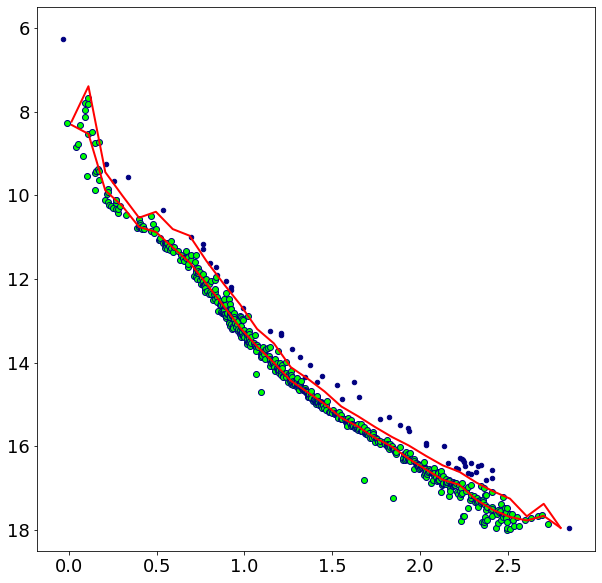

In [77]:
plt.figure(figsize=(10,10))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='navy',s=20)
#plt.scatter(allmems[highprob][ssms_indx]['bp_rp'],allmems[highprob][ssms_indx]['phot_g_mean_mag'],color='orange',s=20)

#plt.scatter(ges_galah_targets_updated['bp_rp'],ges_galah_targets_updated['phot_g_mean_mag'],color='cyan',edgecolors='navy')
plt.scatter(singlestars['bp_rp'],singlestars['phot_g_mean_mag'],color='lime',edgecolors='navy')

#astar = singlestars['source_id'] == 5290715954179096320
#plt.scatter(ges_galah_targets_slice[newidx]['bp_rp'],ges_galah_targets_slice[newidx]['phot_g_mean_mag'],color='pink')

#plt.scatter(ges_galah_targets_slice[mididx]['bp_rp'],ges_galah_targets_slice[mididx]['phot_g_mean_mag'],color='red')


#plt.scatter(ges_galah_targets_slice['bp_rp'],ges_galah_targets_slice['phot_g_mean_mag'],color='cyan',edgecolors='navy')
bprp = np.arange(np.min(allmems[highprob]['bp_rp']),np.max(allmems[highprob]['bp_rp']),.001)
#ms = pf[0]*bprp**3 + pf[1]*bprp**2 + pf[2]*bprp**1 + pf[3]*bprp**0
plt.plot(centers,meds,linewidth=2,color='red')
#plt.plot(centers,meds+.035*meds,linewidth=2,color='red')
plt.plot(centers,meds - 3*stdvs,linewidth=2,color='red')
#plt.plot(centers,meds+.5,linewidth=2,color='red')
#plt.plot(centers,meds+-.5,linewidth=2,color='red')


plt.ylim(18.5,5.5)


In [78]:
singlestars

<Table length=596>
        ra                 dec         ...       proba        cluster 
     float64             float64       ...      float64         str8  
------------------ ------------------- ... ------------------ --------
120.92347226164134  -60.90750623116792 ...  0.699999988079071 NGC_2516
119.02007429823331 -60.242650314474844 ... 0.8999999761581421 NGC_2516
119.62801458151493 -60.729014545974856 ...  0.800000011920929 NGC_2516
119.18789627550726  -60.81503064475218 ... 0.8999999761581421 NGC_2516
119.83869142894031 -60.815619059384105 ...  0.699999988079071 NGC_2516
 118.3718083148051  -61.05443958533375 ... 0.8999999761581421 NGC_2516
119.59272824743998 -60.856155075718064 ... 0.8999999761581421 NGC_2516
118.96086835234338 -61.169145797709746 ...  0.699999988079071 NGC_2516
 119.8488177590863 -60.199399177833655 ...  0.800000011920929 NGC_2516
119.61366160338302  -60.80200477723087 ...                1.0 NGC_2516
               ...                 ... ...                ...      ...
119.71733136904545 -61.399736561744774 ...  0.699999988079071 NGC_2516
120.16115235798104  -61.10671579276989 ...                1.0 NGC_2516
118.99314722588028 -60.322609814371184 ... 0.8999999761581421 NGC_2516
120.40889647173576  -60.41888185470601 ... 0.8999999761581421 NGC_2516
120.42174774469711  -60.74515285966203 ...  0.800000011920929 NGC_2516
120.43011489808374 -60.257054797345646 ...  0.699999988079071 NGC_2516
120.66891417136276  -60.40556839669539 ...  0.699999988079071 NGC_2516
119.06339117109313  -60.39068739243173 ...  0.800000011920929 NGC_2516
120.23387305196745 -60.746427364138206 ...  0.800000011920929 NGC_2516
119.54954188795023  -61.02826735416334 ...  0.800000011920929 NGC_2516

NameError: name 'ges_galah_targets_slice' is not defined

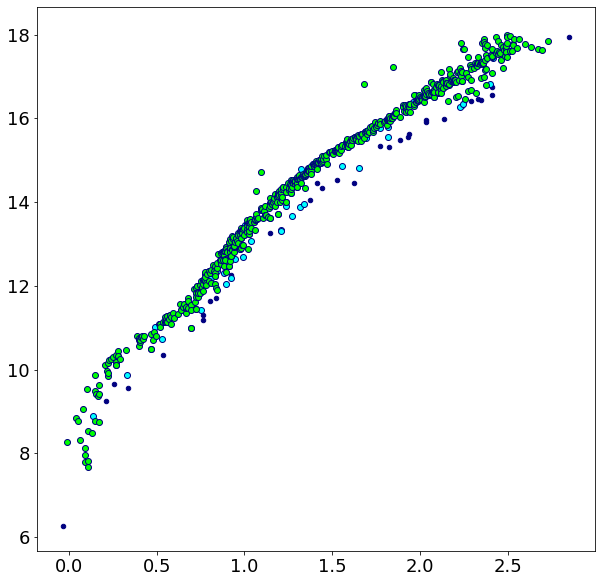

In [49]:
plt.figure(figsize=(10,10))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='navy',s=20)
#plt.scatter(allmems[highprob][ssms_indx]['bp_rp'],allmems[highprob][ssms_indx]['phot_g_mean_mag'],color='orange',s=20)

plt.scatter(ges_galah_targets_updated['bp_rp'],ges_galah_targets_updated['phot_g_mean_mag'],color='cyan',edgecolors='navy')
plt.scatter(singlestars['bp_rp'],singlestars['phot_g_mean_mag'],color='lime',edgecolors='navy')

#astar = singlestars['source_id'] == 5290715954179096320
plt.scatter(ges_galah_targets_slice[newidx]['bp_rp'],ges_galah_targets_slice[newidx]['phot_g_mean_mag'],color='pink')

plt.scatter(ges_galah_targets_slice[mididx]['bp_rp'],ges_galah_targets_slice[mididx]['phot_g_mean_mag'],color='red')


#plt.scatter(ges_galah_targets_slice['bp_rp'],ges_galah_targets_slice['phot_g_mean_mag'],color='cyan',edgecolors='navy')
bprp = np.arange(np.min(allmems[highprob]['bp_rp']),np.max(allmems[highprob]['bp_rp']),.001)
#ms = pf[0]*bprp**3 + pf[1]*bprp**2 + pf[2]*bprp**1 + pf[3]*bprp**0
plt.plot(centers,meds,linewidth=2,color='red')
#plt.plot(centers,meds+.035*meds,linewidth=2,color='red')
plt.plot(centers,meds - 3*stdvs,linewidth=2,color='red')
#plt.plot(centers,meds+.5,linewidth=2,color='red')
#plt.plot(centers,meds+-.5,linewidth=2,color='red')


plt.ylim(18.5,5.5)


In [1761]:
ges_galah_targets_slice[newidx]['source_id']

<Column name='source_id' dtype='int64' length=7>
5290659363690545920
5290672179872595840
5290713445918199168
5290716881891963520
5290726914930519424
5290766252535812224
5290767115830162560

In [1762]:
ges_galah_targets_slice_merged[~newidx]

<Table length=85>
     source_id       AV_SFD ... astrometric_excess_noise_sig
       int64        float64 ...           float64           
------------------- ------- ... ----------------------------
5290652938419483904  0.6338 ...                          0.0
5290653075858442752  0.6503 ...                          0.0
5290655549759622144  0.6359 ...                          0.0
5290655687198404864   0.643 ...          0.23308458536138574
5290661871951147264  0.7229 ...                          0.0
5290664861248309760  0.6484 ...                          0.0
5290665204845694336  0.6704 ...                          0.0
5290667472588665600  0.6362 ...                          0.0
5290667541308087168  0.6274 ...                          0.0
5290667713106775040  0.6342 ...                          0.0
                ...     ... ...                          ...
5290894727896572160  0.7626 ...           0.1725082867816237
5290897266218055040  0.7822 ...                          0.0
5290897751553047552  0.7229 ...           0.1009535479168827
5290931561536172416  0.6142 ...                          0.0
5290932386169704320  0.5921 ...           1.3841775662974474
5290934997509679232  0.6142 ...          0.13790562167894524
5290935993942419840   0.589 ...                          0.0
5291030448862535808  0.5419 ...                          0.0
5291032132489758208  0.5223 ...                          0.0
5291032613526130048  0.5443 ...            1.819105352872113

In [1773]:
ges_galah_targets_slice_merged[mididx]

<Table length=2>
     source_id       AV_SFD ... astrometric_excess_noise_sig
       int64        float64 ...           float64           
------------------- ------- ... ----------------------------
5290706711409106304  0.7715 ...           4.2822561280543265
5290820029826947968  0.5968 ...           3.3554331373673953

In [1506]:
ges_galah_targets_slice_merged['e_vsini']

<Column name='e_vsini' dtype='float64' length=92>
               1.09
                9.0
                0.8
 1.5719999999999998
 2.7239999999999998
               5.66
 0.7050000000000001
               6.33
              0.408
              0.396
0.47200000000000003
              0.723
                ...
 0.9871866384702376
 3.4000000000000004
 0.9880000000000001
              4.325
              1.092
              0.585
                1.1
               1.26
              7.452
              1.395
 0.9994989758678856
 0.8499990167459184

In [314]:
radius_names

<Column name='source_id' dtype='int64' length=14>
5290655549759621888
5290655687198404864
5290660738079873408
5290661253475851392
5290664929967787264
5290669534172838528
5290715919819356800
5290725437466835840
5290730350909320704
5290741208586484352
5290765947599154048
5290817212328531072
5290820442143654656
5290934997509679232

In [315]:
sedfiles = []
for i in range(len(radius_names)):
    dummy = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/*'+np.str(radius_names[i])+'*')
    sedfiles += dummy
    sedfiles[i] = 'cp ' + sedfiles[i] + ' /Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/.\n'


with open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/moveseds_cdips.sh','w+') as output:
    output.writelines(sedfiles)
#sedf.close()

In [292]:
radius_names=difftbl['source_id']

In [316]:
for i in range(len(radius_names)):
    #print('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/argfiles/gaia_dr2_'+np.str(radius_names[i])+'.args')
    file = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/argfiles_cdips/gaia_dr2_'+np.str(radius_names[i])+'.args',mode='w+')
    pfline = 'priorfile=$EXOFAST_PATH/ngc2516/priorfiles/gaia_dr2_'+np.str(radius_names[i])+'.priors\n'
    file.write(pfline)
    pfxline = 'prefix=$EXOFAST_PATH/ngc2516/fitresults/gaia_dr2_'+np.str(radius_names[i])+'.\n'
    file.write(pfxline)
    flxline = 'fluxfile=$EXOFAST_PATH/ngc2516/SEDfiles/*'+np.str(radius_names[i])+'.sed\n'
    file.write(flxline)
    file.write('nplanets=0\n')
    file.write('maxsteps=75000\n')
    file.write('nthin=1\n')
    #file.write('nomist=1')
    file.close()
    

In [1774]:
hotenough = ges_galah_targets_slice_merged['teff'] >= 5200
rnames_sing = ges_galah_targets_slice_merged[~newidx]['source_id']

In [317]:
rnames_sing = radius_names#bestfinal['source_id']

In [198]:
for i in range(len(rnames_sing)):
    #print('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/argfiles/gaia_dr2_'+np.str(radius_names[i])+'.args')
    file = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/argfiles_lasttime/gaia_dr2_'+np.str(rnames_sing[i])+'.args',mode='w+')
    pfline = 'priorfile=$EXOFAST_PATH/ngc2516/priorfiles/gaia_dr2_'+np.str(rnames_sing[i])+'.priors\n'
    file.write(pfline)
    pfxline = 'prefix=$EXOFAST_PATH/ngc2516/fitresults/gaia_dr2_'+np.str(rnames_sing[i])+'.\n'
    file.write(pfxline)
    #flxline = 'fluxfile=$EXOFAST_PATH/ngc2516/SEDfiles/*'+np.str(rnames_sing[i])+'.sed\n'
    #file.write(flxline)
    file.write('nplanets=0\n')
    file.write('maxsteps=75000\n')
    file.write('nthin=1\n')
    #file.write('yy=1\n')
    #file.write('nomist=1')
    file.close()

In [321]:
ges_galah_targets_slice_merged = difftbl

In [326]:
k = 1.08
av = 0.25#best85['E_B_V_SandF'] * 3.1
av_err = 0.5
for i in range(len(ges_galah_targets_slice_merged)):
    #if mems_periods['source_id'][i] == 5290721142499618816:
    #print('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/argfiles/gaia_dr2_'+np.str(radius_names[i])+'.args')
    
    pfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/priorfiles_mistonly_cdips/gaia_dr2_'+np.str(radius_names[i])+'.priors',mode='w+')
    
    ###DOUBLE GALAH EFFECTIVE TEMPERATURE UNCERTAINTIES
    
    #teff = 10**mems_periods[i]['logTeff']
    #teff_unc = 2*(teff / mems_periods[i]['S/N'])
    
    teff = ges_galah_targets_slice_merged['teff'][i]
    
    if ges_galah_targets_slice_merged['survey'][i] == 'Galah':
        teff_unc = ges_galah_targets_slice_merged['e_teff'][i] * 3
    else:
        teff_unc = ges_galah_targets_slice_merged['e_teff'][i] * 3/2.
        
    #if teff_unc/teff < 0.05:
    #    teff_unc = teff * 0.05
    
    print(teff,teff_unc,teff_unc/teff*100)

    pfile.write('teff '+np.str(teff)+' '+np.str(teff_unc)+'\n')
    #pfile.write('teff '+np.str(teff)+'\n') #+' '+np.str(teff_unc)+'\n')


        #qry = Catalogs.query_object('Gaia DR2 '+np.str(mems_periods['source_id'][i]),catalog='TIC')
    qry = Catalogs.query_region(np.str(ges_galah_targets_slice_merged['ra'][i])+', '+np.str(ges_galah_targets_slice_merged['dec'][i]),catalog='TIC')
    #if np.isnan(mems_periods['gaia_r'][i]):
    rad = qry[0]['rad']
    mass = qry[0]['mass']
    logg = qry[0]['logg']
    #else:
    #    rad = mems_periods[i]['gaia_r']
    #print(qry[0]['GAIA'] == np.str(mems_periods['source_id'][i]))

        
    #mass = qry[0]['mass']

    #pfile.write('mstar ' + np.str(mass) +'\n')

    #pfile.write('rstar '+np.str(rad)+'\n')

    #pfile.write('age ' + np.str(0.135) + ' ' + np.str(0.02)+'\n')
    pfile.write('age ' + np.str(0.200) + ' ' + np.str(0.50)+'\n')


    #extindx = extinctbl['objname'] == np.str(mems_periods['source_id'][i])
    ###av = ges_galah_targets_slice_merged['E_B_V_SandF'][i] * 3.1
    
    #av_err = np.mean((extinctbl[extindx]['max_E_B_V_SandF'].data *3.1 - av, av - extinctbl[extindx]['min_E_B_V_SandF'].data *3.1))*2
    ###av_err = ges_galah_targets_slice_merged['stdev_E_B_V_SandF'][i] * 3.1 * 3
    print(av,av_err,av_err/av*100)

    pfile.write('av ' + np.str(av) + ' ' + np.str(av_err)+'\n')

    plx = ges_galah_targets_slice_merged['parallax'][i]
    plx = plx + 0.030 #30 microarcsec offset added
    
    plx_err = ges_galah_targets_slice_merged['parallax_error'][i]
    if ges_galah_targets_slice_merged['phot_g_mean_mag'][i] <= 13:
        sig = 0.021
    else:
        sig = 0.043
    plx_err = np.sqrt(k**2*plx_err**2 + sig**2)
    #plx_err = np.sqrt(plx_err**2 + 0.030**2) #Add uncertainty from plx offset

    pfile.write('parallax ' + np.str(plx) + ' ' + np.str(plx_err) + '\n')

    print(plx,plx_err,plx_err/plx*100)
    print()

    pfile.write('feh -0.2 0.3\n')
    pfile.write('initfeh -0.2\n')
    pfile.write('eep 200\n')
    
    #if not np.isnan(ges_galah_targets_slice['logg'][i]):
    #if not np.isnan(logg):
    #    pfile.write('logg '+np.str(logg)+'\n')# + ' ' + np.str(logg_err*3))
        
    if not np.isnan(rad):
        pfile.write('rstar '+np.str(rad)+'\n')        
        
    if not np.isnan(mass):
        pfile.write('mstar '+np.str(mass)) 
        #logg = ges_galah_targets_slice['logg'][i]
        #logg_err = ges_galah_targets_slice['e_logg'][i]
        #pfile.write('logg '+np.str(logg) + ' ' + np.str(logg_err*3))

        


    pfile.close()


    
    
    
    
    
    

6576.578373554205 49.614583112866804 0.7544133179097721
0.25 0.5 200.0
2.4232237789778606 0.03134218410929197 1.2934085733721388

4036.4539296760486 239.03201320624055 5.921831819976313
0.25 0.5 200.0
2.4952637482422926 0.07806560959124081 3.128551426526819

6053.408747539136 85.31535395385421 1.409377055341539
0.25 0.5 200.0
2.471683732039085 0.0294655001321848 1.1921225903718842

4275.62886151586 237.35911518407812 5.5514433752775725
0.25 0.5 200.0
2.5132361524458093 0.06032666154062118 2.4003578605978992

6426.877173170194 52.558694579409504 0.8177952240758914
0.25 0.5 200.0
2.4538588404475736 0.03391143376778882 1.3819635102402026

4159.106104940223 186.67442122711952 4.488330341113106
0.25 0.5 200.0
2.3657603550367683 0.06962689645683193 2.943108599676817

4305.266104917106 100.65304172967049 2.337905236907731
0.25 0.5 200.0
2.4416537829791984 0.05698023302310422 2.333673734593913

7706.163094788561 122.9649824360728 1.5956706459954138
0.25 0.5 200.0
2.3718129024844905 0.043932833

In [302]:
#best85 = ges_galah_targets_slice_merged[~newidx]
best85 = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/best85_stars_beforemcmc.dat')

In [1823]:
best85[best85['teff'] >= 4000]['source_id'].tofile('/Users/bhealy/Downloads/names76.txt',sep='\n')

In [78]:
nomdwarfs = best85[best85['teff'] >= 4000]

In [85]:
nokdwarfs = best85[(best85['teff'] >= 5200) & (best85['teff'] < 9000)]

In [86]:
nokdwarfs

<Table length=53>
     source_id       AV_SFD ... astrometric_excess_noise_sig
       int64        float64 ...           float64           
------------------- ------- ... ----------------------------
5290652938419483904  0.6338 ...                          0.0
5290655549759622144  0.6359 ...                          0.0
5290664861248309760  0.6484 ...                          0.0
5290667472588665600  0.6362 ...                          0.0
5290667541308087168  0.6274 ...                          0.0
5290667713106775040  0.6342 ...                          0.0
5290669873469360512  0.6544 ...                          0.0
5290704306227620992  0.8138 ...                          0.0
5290706711409106304  0.7715 ...           4.2822561280543265
5290709357109480704  0.7791 ...         9.70301161372218e-16
                ...     ... ...                          ...
5290824320493640576  0.6525 ...                          0.0
5290826558177392640  0.6134 ...                          0.0
5290826936134381440  0.6334 ...       2.1213775507421696e-15
5290830097230075904  0.6169 ...                          0.0
5290833189601524480  0.5837 ...                          0.0
5290838962037067648  0.6016 ...                          0.0
5290931561536172416  0.6142 ...                          0.0
5291030448862535808  0.5419 ...                          0.0
5291032132489758208  0.5223 ...                          0.0
5291032613526130048  0.5443 ...            1.819105352872113

(array([ 4.,  2.,  3.,  5.,  0.,  5., 12., 18., 21.,  6.]),
 array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ]),
 <a list of 10 Patch objects>)

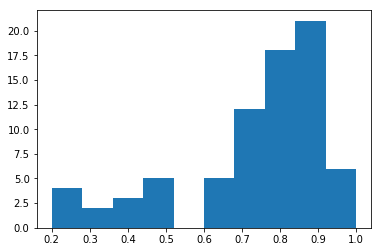

In [8]:
plt.hist(best85[best85['teff'] >= 4000]['proba'])

In [319]:
BESTFINAL = bestfinal
bestfinal = difftbl

In [329]:
k = 1.08
###mean_av = np.mean(bestfinal['E_B_V_SandF'] * 3.1)

for i in range(len(bestfinal)):
    pfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/priorfiles_cdips/gaia_dr2_'+np.str(bestfinal['source_id'][i])+'.priors',mode='w+')

    medfile = pd.read_csv('/Users/bhealy/Data/Star/FR_cdips/gaia_dr2_'+np.str(bestfinal['source_id'][i])+'.median.csv')
    
    #newteff = medfile[' median value'][5]
    
    newteff = bestfinal['teff'][i]
    teff_err = bestfinal['e_teff'][i] * 5 #3-sigma error on Teff
    
    #newr = medfile[' median value'][1]
    #newm = medfile[' median value'][0]
    newfeh = medfile[' median value'][6]
    newinitfeh = medfile[' median value'][7]
    
    newage = medfile[' median value'][8]
    age_err = 0.05
    
    neweep = medfile[' median value'][9]
    
    plx = bestfinal['parallax'][i] + 0.030
    plx_err = bestfinal['parallax_error'][i]
    
    if bestfinal['phot_g_mean_mag'][i] <= 13:
        sig = 0.021
    else:
        sig = 0.043
    plx_err = np.sqrt(k**2*plx_err**2 + sig**2)
    plx_err = np.sqrt(plx_err**2 + 0.030**2)
    
    ###av = bestfinal['E_B_V_SandF'][i] * 3.1
    #av_err = bestfinal['stdev_E_B_V_SandF'][i] * 3.1 * 3 #3-sigma error
    ###av_err = np.std(bestfinal['E_B_V_SandF'] * 3.1) * 3
    
    #pfile.write('rstar '+np.str(newr)+'\n')
    #pfile.write('mstar '+np.str(newm)+'\n')
    qry = Catalogs.query_region(np.str(bestfinal['ra'][i])+', '+np.str(bestfinal['dec'][i]),catalog='TIC')
    rad = qry[0]['rad']
    mass = qry[0]['mass']
    
    if not np.isnan(rad):
        pfile.write('rstar '+np.str(rad)+'\n')        
        
    if not np.isnan(mass):
        pfile.write('mstar '+np.str(mass)+'\n') 
    #pfile.write('feh '+np.str(newfeh)+'\n')
    #pfile.write('initfeh '+np.str(newinitfeh)+'\n')
    pfile.write('feh -0.2 0.4\n')
    pfile.write('initfeh -0.2\n')
    pfile.write('eep '+np.str(neweep)+'\n')
    #0.251188643151
    pfile.write('teff '+np.str(newteff)+' '+np.str(teff_err)+'\n')
    #pfile.write('teff '+np.str(newteff)+'\n')
    #pfile.write('age '+np.str(newage)+' '+np.str(age_err)+'\n')
    pfile.write('age 0.251188643151 0.050\n')
    pfile.write('av 0.220 0.4\n')

    #pfile.write('av '+np.str(av)+' '+np.str(av_err)+'\n')
    pfile.write('parallax '+np.str(plx)+' '+np.str(plx_err))
    
    pfile.close()


    
    
    



In [296]:
sed85 = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/*.sed')
sed85

['/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290730350909320704.sed',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290664929967787264.sed',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290820442143654656.sed',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290655549759621888.sed',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290817212328531072.sed',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290725437466835840.sed',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290655687198404864.sed',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290934997509679232.sed',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290669534172838528.sed',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290741208586484352.sed',
 '/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/5290660738079873408.sed',

In [297]:
count = 0
indx=[]
for i in range(len(sed85)):
    if np.int(sed85[i].split('/')[-1][:-4]) in bestfinal['source_id']:
        sed = ascii.read(sed85[i])
        if ('B' not in sed['col1']) & ('V' not in sed['col1']):
            indx += [i]

In [298]:
indx

[0, 2, 6, 7]

In [299]:
chosenfiles=np.array(sed85)[indx]

In [300]:
from astroquery.vizier import Vizier

In [301]:
srch = Vizier.find_catalogs('J/A+A/375/863')

In [302]:
cat = Vizier.get_catalogs(srch)

In [303]:
cat[0]

<Table length=50>
  ID    RAJ2000      DEJ2000      Vmag    B-V   ...   F2    F3    F4    F5 
        "h:m:s"      "d:m:s"                    ...                        
int32   bytes12      bytes12    float32 float32 ... int16 int16 int16 uint8
----- ------------ ------------ ------- ------- ... ----- ----- ----- -----
    1 07 54 08.467 -61 00 50.36  18.582      -- ...    -1     0    -1     0
    2 07 54 08.902 -61 03 26.94  15.255   0.830 ...    -1     1    -1     0
    3 07 54 09.401 -61 07 55.51  16.059   1.337 ...     1     1     1     0
    4 07 54 09.831 -60 53 14.35  18.495      -- ...     1     0     1     1
    5 07 54 09.910 -61 02 29.19  18.932      -- ...    -1     0    -1     0
    6 07 54 10.082 -61 03 22.61  18.000      -- ...    -1     0    -1     0
    7 07 54 10.360 -61 02 28.71  18.317   0.853 ...    -1     1    -1     0
    8 07 54 10.424 -61 04 47.23  18.223   0.767 ...    -1     1    -1     0
    9 07 54 10.460 -61 07 29.67  18.844   0.646 ...    -1    -1    -1     0
  ...          ...          ...     ...     ... ...   ...   ...   ...   ...
   41 07 54 12.083 -60 33 47.34  16.975   0.892 ...     1    -1    -1     0
   42 07 54 12.084 -60 59 19.28  16.442   1.061 ...    -1     1    -1     0
   43 07 54 12.109 -61 12 11.87  15.705   1.088 ...    -1     1    -1     0
   44 07 54 12.163 -60 33 33.68  15.882   1.278 ...     1     1     1     0
   45 07 54 12.165 -60 27 34.18  19.139   0.769 ...    -1     1    -1     0
   46 07 54 12.179 -60 57 00.40  16.409   0.598 ...    -1     1    -1     0
   47 07 54 12.189 -61 07 08.54  19.748      -- ...    -1     0    -1     0
   48 07 54 12.191 -60 52 58.20  17.791   0.895 ...    -1     1    -1     0
   49 07 54 12.198 -60 44 28.55  19.319      -- ...    -1     0    -1     0
   50 07 54 12.212 -60 36 46.87  19.521      -- ...    -1     0    -1     0

In [304]:
catcoords = SkyCoord(cat[0]['RAJ2000'],cat[0]['DEJ2000'],unit=(u.hourangle,u.deg))

In [305]:
catcoords

<SkyCoord (ICRS): (ra, dec) in deg
    [(118.53527917, -61.01398889), (118.53709167, -61.05748333),
     (118.53917083, -61.13208611), (118.5409625 , -60.88731944),
     (118.54129167, -61.04144167), (118.54200833, -61.05628056),
     (118.54316667, -61.04130833), (118.54343333, -61.07978611),
     (118.54358333, -61.12490833), (118.54359583, -60.90080556),
     (118.5437125 , -60.88260556), (118.54429167, -61.13023611),
     (118.5450625 , -60.54116389), (118.54525417, -60.67881944),
     (118.54535417, -60.48918333), (118.54535833, -60.35178333),
     (118.54539167, -60.91300278), (118.5459125 , -61.11873889),
     (118.546     , -61.12940556), (118.54611667, -60.93890556),
     (118.54628333, -60.37293889), (118.54639583, -61.00294167),
     (118.54682083, -60.84718611), (118.54687083, -61.03874444),
     (118.5471625 , -61.03563333), (118.54718333, -60.53633889),
     (118.54725   , -60.87533056), (118.5475    , -61.12898333),
     (118.54750417, -60.41013611), (118.54761667, -60.3

In [306]:
bestfinal[bestfinal['source_id'] == 5290730350909320704]['ra','dec']

<Table length=1>
        ra                dec        
     float64            float64      
------------------ ------------------
118.86533058171912 -60.80378781179854

In [95]:
SC=SkyCoord(bestfinal[bestfinal['source_id'] == 5290730350909320704]['ra']*u.deg,bestfinal[bestfinal['source_id'] == 5290744983857413376]['dec']*u.deg)
SC






<SkyCoord (ICRS): (ra, dec) in deg
    [(118.86533058, -61.12912073)]>

In [97]:
np.min(SC.separation(catcoords))

<Angle 0.15223145 deg>

In [310]:
for i in range(len(chosenfiles)):
    sid = chosenfiles[i].split('/')[-1][:-4]
    tgt=Catalogs.query_object('Gaia DR2 '+sid,catalog='TIC')[0]#['Bmag','Vmag']
    print(sid,tgt['GAIA'])
    #SC=SkyCoord(bestfinal[bestfinal['source_id'] == sid]['ra']*u.deg,bestfinal[bestfinal['source_id'] == sid]['dec']*u.deg)
    SC = SkyCoord(tgt['ra']*u.deg,tgt['dec']*u.deg)
    print(np.min(SC.separation(catcoords)))

5290730350909320704 5290730350909320704
0d09m16.4839s
5290820442143654656 5290820442143654656
0d29m29.8602s
5290655687198404864 5290655687198404864
0d31m20.3478s
5290934997509679232 5290934997509679232
0d05m02.7198s


In [308]:
sid

'5290934997509679232'

In [309]:
tgt

<Row index=0 masked=True>
    ID           ra               dec          pmRA    pmDEC    Tmag  objType typeSrc version  HIP   TYC     UCAC        TWOMASS      SDSS       ALLWISE               GAIA        APASS KIC  POSflag   e_pmRA   e_pmDEC  PMflag   plx     e_plx   PARflag     gallong            gallat           eclong            eclat         Bmag   e_Bmag   Vmag   e_Vmag   umag   e_umag   gmag   e_gmag   rmag   e_rmag   imag   e_imag   zmag   e_zmag   Jmag   e_Jmag   Hmag   e_Hmag   Kmag   e_Kmag       TWOMflag        prox   w1mag  e_w1mag  w2mag  e_w2mag  w3mag  e_w3mag  w4mag  e_w4mag GAIAmag e_GAIAmag   e_Tmag   TESSflag SPFlag   Teff   e_Teff   logg    e_logg     MH     e_MH    rad     e_rad     mass     e_mass    rho    e_rho   lumclass    lum        e_lum       d      e_d     ebv     e_ebv  numcont  contratio  disposition duplicate_id   priority   eneg_EBV epos_EBV EBVflag  eneg_Mass epos_Mass eneg_Rad epos_Rad eneg_rho epos_rho eneg_logg epos_logg eneg_lum epos_lum eneg_dist epos_dist distflag eneg_Teff epos_Teff TeffFlag  gaiabp e_gaiabp  gaiarp e_gaiarp gaiaqflag starchareFlag VmagFlag BmagFlag    splists          e_RA            e_Dec           RA_orig           Dec_orig         e_RA_orig          e_Dec_orig     raddflag wdflag       dstArcSec      
  str11       float64           float64      float64  float64 float64   str8    str7    str8   str1 str12   str10         str16       str1        str19               str19         str8 str1   str8   float64   float64   str5  float64  float64    str5      float64           float64          float64           float64      float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64        str19        float64 float64 float64 float64 float64 float64 float64 float64 float64 float64  float64   float64     str5    str5  float64 float64 float64  float64  float64 float64 float64  float64  float64   float64  float64 float64    str5    float64     float64   float64 float64 float64  float64  int64    float64       str5        str9       float64    float64  float64    str8    float64   float64  float64  float64  float64  float64   float64   float64  float64  float64   float64   float64    str6    float64   float64    str5   float64 float64  float64 float64    int64        str1       str8     str8       str13         float64          float64          float64           float64           float64            float64        int64   int64         float64       
--------- ---------------- ----------------- -------- ------- ------- ------- ------- -------- ---- ----- ---------- ---------------- ---- ------------------- ------------------- ----- ---- ------- --------- --------- ------ ------- --------- ------- ---------------- ----------------- ---------------- ----------------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------------------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- --------- ---------- -------- ------ ------- ------- ------- --------- ------- ------- ------- --------- -------- --------- ------- -------- -------- ---------- ----------- ------- ------- -------- ------- ------- ----------- ----------- ------------ ------------ -------- -------- -------- --------- --------- -------- -------- -------- -------- --------- --------- -------- -------- --------- --------- -------- --------- --------- -------- ------- -------- ------- -------- --------- ------------- -------- -------- ------------- ---------------- ---------------- ---------------- ----------------- ------------------ ------------------ -------- ------ ---------------------
382632157 118.715114228462 -60.4251105863561 -4.31712 11.2077 15.1695    STAR tmgaia2 20190415   --    -- 148-012543 07545163-6025303   -- J075451.62-602530.2 5290934997509679232    --   -- tmgaia2

In [105]:
chosenfiles[0].split('/')[-1][:-4]

'5290744983857413376'

In [116]:
chosenfiles[0]

'/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_85_moremags/5290744983857413376.sed'

In [312]:
for i in range(len(chosenfiles)):
    sed = ascii.read(chosenfiles[i])
    sed.rename_column('col1','# col1')
    sid = chosenfiles[i].split('/')[-1][:-4]
    tgt=Catalogs.query_object('Gaia DR2 '+sid,catalog='TIC')[0]
    sed.add_row(vals=['B',tgt['Bmag'],tgt['e_Bmag'],tgt['e_Bmag']])
    sed.add_row(vals=['V',tgt['Vmag'],tgt['e_Vmag'],tgt['e_Vmag']])
    sed.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2_cdips/'+sid+'.sed',overwrite=True,format='ascii.tab')
    print(tgt['BmagFlag'],tgt['VmagFlag'])

bpbj gaia2
bpbj ucac4
bpbj gaia2
bpbj ucac4


In [313]:
sed

<Table length=11>
# col1   col2    col3    col4 
 str6  float64 float64 float64
------ ------- ------- -------
   J2M  13.924    0.03    0.03
   H2M  13.201    0.03    0.03
   K2M  13.046    0.03    0.03
 WISE1  12.982    0.03   0.023
 WISE2  12.944    0.03   0.023
 WISE3  12.731   0.365   0.365
  Gaia  16.128    0.02   0.001
GaiaBP  17.032    0.02    0.01
GaiaRP  15.175    0.02   0.004
     B  18.399   0.182   0.182
     V  16.604   1.133   1.133

In [115]:
sed.add_row(vals=['B',tgt['Bmag'],tgt['e_Bmag'],tgt['e_Bmag']])
sed.add_row(vals=['V',tgt['Vmag'],tgt['e_Vmag'],tgt['e_Vmag']])
print(tgt['BmagFlag'],tgt['VmagFlag'])
sed

bpbj ucac4


<Table length=12>
 col1    col2    col3    col4 
 str6  float64 float64 float64
------ ------- ------- -------
   J2M  12.668    0.03    0.03
   H2M  12.117    0.03    0.03
   K2M  12.004    0.03    0.03
 WISE1  11.932    0.03   0.023
 WISE2   11.94    0.03   0.021
 WISE3   11.75   0.157   0.157
  Gaia   14.37    0.02   0.002
GaiaBP  14.947    0.02   0.006
GaiaRP  13.649    0.02   0.005
     B  15.062   0.113   0.113
     B  15.062   0.113   0.113
     V  14.721   0.057   0.057

In [113]:
tgt

<Row index=0 masked=True>
    ID           ra               dec          pmRA    pmDEC    Tmag  objType typeSrc version  HIP   TYC     UCAC        TWOMASS      SDSS       ALLWISE               GAIA        APASS KIC  POSflag   e_pmRA   e_pmDEC  PMflag   plx     e_plx   PARflag     gallong            gallat           eclong            eclat         Bmag   e_Bmag   Vmag   e_Vmag   umag   e_umag   gmag   e_gmag   rmag   e_rmag   imag   e_imag   zmag   e_zmag   Jmag   e_Jmag   Hmag   e_Hmag   Kmag   e_Kmag       TWOMflag        prox   w1mag  e_w1mag  w2mag  e_w2mag  w3mag  e_w3mag  w4mag  e_w4mag GAIAmag e_GAIAmag  e_Tmag TESSflag SPFlag   Teff   e_Teff   logg   e_logg    MH     e_MH    rad     e_rad    mass   e_mass   rho    e_rho  lumclass     lum      e_lum     d      e_d     ebv     e_ebv  numcont contratio disposition duplicate_id priority eneg_EBV epos_EBV EBVflag  eneg_Mass epos_Mass eneg_Rad epos_Rad eneg_rho epos_rho eneg_logg epos_logg eneg_lum epos_lum eneg_dist epos_dist distflag eneg_Teff epos_Teff TeffFlag  gaiabp e_gaiabp  gaiarp e_gaiarp gaiaqflag starchareFlag VmagFlag BmagFlag splists        e_RA             e_Dec           RA_orig           Dec_orig         e_RA_orig          e_Dec_orig     raddflag wdflag       dstArcSec      
  str11       float64           float64      float64  float64 float64   str8    str7    str8   str1 str12   str10         str16       str1        str19               str19         str8 str1   str8   float64   float64   str5  float64  float64    str5      float64           float64          float64           float64      float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64        str19        float64 float64 float64 float64 float64 float64 float64 float64 float64 float64  float64  float64   str5    str5  float64 float64 float64 float64 float64 float64 float64  float64 float64 float64 float64 float64   str5     float64   float64 float64 float64 float64  float64  int64   float64      str5        str9     float64  float64  float64    str8    float64   float64  float64  float64  float64  float64   float64   float64  float64  float64   float64   float64    str6    float64   float64    str5   float64 float64  float64 float64    int64        str1       str8     str8    str13       float64           float64          float64           float64           float64            float64        int64   int64         float64       
--------- ---------------- ----------------- -------- ------- ------- ------- ------- -------- ---- ----- ---------- ---------------- ---- ------------------- ------------------- ----- ---- ------- --------- --------- ------ ------- --------- ------- ---------------- ----------------- ---------------- ----------------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------------------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- --------- ------- -------- ------ ------- ------- ------- ------- ------- ------- -------- ------- ------- ------- ------- ------- -------- ----------- ------- ------- ------- -------- ------- ------- --------- ----------- ------------ -------- -------- -------- -------- --------- --------- -------- -------- -------- -------- --------- --------- -------- -------- --------- --------- -------- --------- --------- -------- ------- -------- ------- -------- --------- ------------- -------- -------- ------- ----------------- ----------------- ---------------- ----------------- ------------------ ------------------ -------- ------ ---------------------
308402934 120.313886596505 -60.7943264806086 -4.77825 12.3787 13.7089    STAR tmgaia2 20190415   --    -- 147-012581 08011532-6047395   -- J080115.33-604739.3 5290758933911651584    --   -- tmgaia2 0.0350344 0.0385733  gaia2 2.39601 0.0179668   gaia2 274.04256401569

In [92]:
Catalogs.query_object('Gaia DR2 5290730350909320704',catalog='TIC')[0]#['Bmag','Vmag']

<Row index=0 masked=True>
    ID           ra               dec          pmRA    pmDEC    Tmag  objType typeSrc version  HIP   TYC   UCAC     TWOMASS      SDSS       ALLWISE               GAIA        APASS KIC  POSflag  e_pmRA   e_pmDEC  PMflag   plx     e_plx   PARflag     gallong            gallat           eclong           eclat         Bmag   e_Bmag   Vmag   e_Vmag   umag   e_umag   gmag   e_gmag   rmag   e_rmag   imag   e_imag   zmag   e_zmag   Jmag   e_Jmag   Hmag   e_Hmag   Kmag   e_Kmag       TWOMflag        prox   w1mag  e_w1mag  w2mag  e_w2mag  w3mag  e_w3mag  w4mag  e_w4mag GAIAmag e_GAIAmag   e_Tmag   TESSflag SPFlag   Teff   e_Teff   logg   e_logg     MH     e_MH    rad    e_rad     mass     e_mass    rho    e_rho  lumclass    lum       e_lum       d      e_d     ebv     e_ebv  numcont  contratio  disposition duplicate_id    priority    eneg_EBV epos_EBV EBVflag  eneg_Mass epos_Mass eneg_Rad epos_Rad eneg_rho epos_rho eneg_logg epos_logg eneg_lum epos_lum eneg_dist epos_dist distflag eneg_Teff epos_Teff TeffFlag  gaiabp e_gaiabp  gaiarp e_gaiarp gaiaqflag starchareFlag VmagFlag BmagFlag    splists          e_RA            e_Dec           RA_orig           Dec_orig         e_RA_orig        e_Dec_orig    raddflag wdflag       dstArcSec      
  str11       float64           float64      float64  float64 float64   str8    str7    str8   str1 str12 str10      str16       str1        str19               str19         str8 str1   str8  float64   float64   str5  float64  float64    str5      float64           float64          float64          float64      float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64        str19        float64 float64 float64 float64 float64 float64 float64 float64 float64 float64  float64   float64     str5    str5  float64 float64 float64 float64  float64 float64 float64 float64  float64   float64  float64 float64   str5    float64    float64   float64 float64 float64  float64  int64    float64       str5        str9        float64     float64  float64    str8    float64   float64  float64  float64  float64  float64   float64   float64  float64  float64   float64   float64    str6    float64   float64    str5   float64 float64  float64 float64    int64        str1       str8     str8       str13         float64          float64          float64           float64           float64          float64       int64   int64         float64       
--------- ---------------- ----------------- -------- ------- ------- ------- ------- -------- ---- ----- ----- ---------------- ---- ------------------- ------------------- ----- ---- ------- -------- --------- ------ ------- --------- ------- ---------------- ----------------- ---------------- ---------------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------------------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- --------- ---------- -------- ------ ------- ------- ------- -------- ------- ------- ------- -------- -------- --------- ------- ------- -------- --------- ----------- ------- ------- -------- ------- ------- ----------- ----------- ------------ -------------- -------- -------- -------- --------- --------- -------- -------- -------- -------- --------- --------- -------- -------- --------- --------- -------- --------- --------- -------- ------- -------- ------- -------- --------- ------------- -------- -------- ------------- ---------------- ---------------- ---------------- ----------------- ----------------- ---------------- -------- ------ ---------------------
358464579 118.865369023488 -60.8038335755433 -4.35529  10.629 15.6158    STAR tmgaia2 20190415   --    --    -- 07552770-6048138   -- J075527.68-604813.6 5290730350909320704    --   -- tmgaia2 0.111868 0.0976283  gaia2 2.43612 0.0499

In [293]:
difftbl['source_id','ra','dec'].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/difftbl_sid_ra_dec.dat',format='ascii')

In [40]:
np.std(best85['E_B_V_SandF'] * 3.1) * 3

0.16132795537041927

In [1807]:
#best85.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/best85_stars_beforemcmc.dat',format='ascii')

In [1794]:
medfile

#parname   median value   upper errorbar   lower errorbar
0                  M_*          1.510            0.220            0.160
1                  R_*          1.390            0.210            0.170
2                  L_*          5.900            2.000            1.600
3               \rho_*          0.800            0.240            0.210
4              \log{g}          4.334            0.062            0.069
5          T_{\rm eff}       7620.000          160.000          190.000
6         [{\rm Fe/H}]         -0.210            0.360            0.340
7     [{\rm Fe/H}]_{0}         -0.080            0.310            0.320
8                  Age          0.141            0.020            0.022
9                  EEP        275.700            8.500            7.600
10  \log{M_*/M_{\sun}}          0.179            0.059            0.050

In [36]:
av = best85['E_B_V_SandF'] * 3.1

In [38]:
np.mean(av), np.std(av)

(0.5642619999999999, 0.05377598512347309)

In [331]:
ges_galah_targets_slice = difftbl

In [332]:
nmax = 2
count = 0
ind = 1
imax = np.int(np.ceil(len(ges_galah_targets_slice)/nmax))

ges_galah_targets_slice.sort(keys='teff')

sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles_cdips/group_fit_'+np.str(ind)+'.sh',mode='a+')
for i in range(len(ges_galah_targets_slice)):
    sfile.write('idl -arg $EXOFAST_PATH/ngc2516/argfiles/gaia_dr2_'+np.str(ges_galah_targets_slice['source_id'][i])+'.args -vm=$EXOFAST_PATH/exofastv2.sav\n')
    count += 1
    print(i, ges_galah_targets_slice['source_id'][i])
    if (count == nmax) or ((len(ges_galah_targets_slice) - i) == 1):
        sfile.close()
        ind += 1
        count = 0
        if ind <= imax:
            sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles_cdips/group_fit_'+np.str(ind)+'.sh',mode='a+')
        #sfile.write('idl -arg $EXOFAST_PATH/ngc2516/argfiles/gaia_dr2_'+np.str(mems_periods['source_id'][i])+'.args -vm=$EXOFAST_PATH/exofastv2.sav\n')

sfile.close()
    

0 5290655687198404864
1 5290817212328531072
2 5290820442143654656
3 5290730350909320704
4 5290669534172838528
5 5290661253475851392
6 5290715919819356800
7 5290765947599154048
8 5290934997509679232
9 5290660738079873408
10 5290741208586484352
11 5290664929967787264
12 5290655549759621888
13 5290725437466835840


In [333]:
difftbl

<Table length=14>
        ra                 dec         ... CDIPS classification
     float64             float64       ... int64      str1     
------------------ ------------------- ... ----- --------------
119.62997956802782  -61.08969061592808 ...     1              C
119.87081758061746  -60.66154951640272 ...     1              C
119.55207431338823   -60.6349200237026 ...     1              C
118.86533058171912  -60.80378781179854 ...     1              C
 119.7312581599858  -60.93315783860372 ...     1              C
118.96634354343598  -61.22241062296897 ...     1              C
118.96424957852149   -60.9670225989847 ...     1              C
120.06859664295227  -60.77082477379771 ...     1              C
118.71507656825491 -60.425062330986215 ...     1              C
119.33371932380165  -61.12049818566914 ...     1              C
118.93239649193438  -60.63112177512871 ...     1              C
119.25998129356094  -61.03465617585395 ...     1              C
119.69352745414736  -61.09960558716263 ...     1              C
 119.4210732231115  -60.72733767006693 ...     1              C

In [1839]:
nomdwarfs

<Table length=76>
     source_id       AV_SFD ... astrometric_excess_noise_sig
       int64        float64 ...           float64           
------------------- ------- ... ----------------------------
5290655687198404864   0.643 ...          0.23308458536138574
5290820442143654656  0.5853 ...           1.3545282305852857
5290730350909320704  0.6844 ...           0.0934461841763559
5290718084482964992  0.6803 ...                          0.0
5290894727896572160  0.7626 ...           0.1725082867816237
5290653075858442752  0.6503 ...                          0.0
5290744983857413376  0.6144 ...                          0.0
5290688084132627328  0.8005 ...                          0.0
5290739937276199168  0.5932 ...                          0.0
5290750382637937920  0.6089 ...                          0.0
                ...     ... ...                          ...
5290763095740848128  0.6334 ...                          0.0
5290738356723303936  0.6108 ...                          0.0
5290704306227620992  0.8138 ...                          0.0
5290706711409106304  0.7715 ...           4.2822561280543265
5290833189601524480  0.5837 ...                          0.0
5290820029826947968  0.5968 ...           3.3554331373673953
5290719115275116288  0.7004 ...        2.127311485552127e-15
5291032613526130048  0.5443 ...            1.819105352872113
5290814875866306432  0.6795 ...                          0.0
5290766188117237120  0.6235 ...                          0.0

In [126]:
nmax = 7
count = 0
ind = 1
#imax = np.int(np.ceil(len(ges_galah_targets_slice_merged[~newidx])/nmax))
imax = np.int(np.ceil(len(bestfinal)/nmax))


#ggts = ges_galah_targets_slice[~newidx]
#ggts.sort(keys='teff')

bestfinal.sort(keys='teff')
ggts = bestfinal

sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles_ultimate/group_fit_'+np.str(ind)+'.sh',mode='a+')
for i in range(len(ggts)):
    sfile.write('idl -arg $EXOFAST_PATH/ngc2516/argfiles/gaia_dr2_'+np.str(ggts['source_id'][i])+'.args -vm=$EXOFAST_PATH/exofastv2.sav\n')
    count += 1
    print(i, ggts['source_id'][i])
    if (count == nmax) or ((len(ggts) - i) == 1):
        sfile.close()
        ind += 1
        count = 0
        if ind <= imax:
            sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles_ultimate/group_fit_'+np.str(ind)+'.sh',mode='a+')
        #sfile.write('idl -arg $EXOFAST_PATH/ngc2516/argfiles/gaia_dr2_'+np.str(mems_periods['source_id'][i])+'.args -vm=$EXOFAST_PATH/exofastv2.sav\n')

sfile.close()
    

0 5290655687198404864
1 5290820442143654656
2 5290730350909320704
3 5290718084482964992
4 5290894727896572160
5 5290653075858442752
6 5290744983857413376
7 5290739937276199168
8 5290750382637937920
9 5290935993942419840
10 5290723032285137024
11 5290673348103622272
12 5290934997509679232
13 5290717672165866496
14 5290815734859774080
15 5290672557829815296
16 5290758933911651584
17 5290819342632176512
18 5290770998480701184
19 5290814807146918016
20 5290817281048004736
21 5290730144750809472
22 5290725781064133760
23 5290652938419483904
24 5290713652076611200
25 5290667472588665600
26 5290754643245585792
27 5290820785740950656
28 5290664861248309760
29 5290667713106775040
30 5290747977456314880
31 5290737669533445248
32 5290667541308087168
33 5290715954179096320
34 5290826558177392640
35 5290728834785867264
36 5290741208586484352
37 5290720042987976576
38 5290823568880135296
39 5290669873469360512
40 5290710800218328192
41 5290725231308404864
42 5291030448862535808
43 529072227637098764

In [207]:
bestfinal[0:7]['source_id']#.tofile('/Users/bhealy/Downloads/names7.txt',sep='\n')

<Column name='source_id' dtype='int64' length=7>
5290655687198404864
5290820442143654656
5290730350909320704
5290718084482964992
5290894727896572160
5290653075858442752
5290744983857413376

In [1776]:
names85 = ggts['source_id']

In [1777]:
names85.tofile('/Users/bhealy/Downloads/names85.txt',sep='\n')

In [1779]:
new3 = ges_galah_targets_slice_merged[mididx]

In [1786]:
new3['source_id'].tofile('/Users/bhealy/Downloads/names2.txt',sep='\n')

In [113]:
files = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/fitresults_nok/logs/*.log')
finished = np.zeros(len(files),dtype=bool)
chi2 = np.zeros(len(files))
for i in range(len(files)):
    o = open(files[i])
    rd = o.read()
    if 'chi^2' in rd.splitlines()[-3]:
        finished[i] = True
        chi2[i] = np.float(rd.splitlines()[-3].split()[-1])
    else:
        chi2[i] = 0


In [114]:
files[np.nanargmin(chi2)]

'/Users/bhealy/Documents/PhD_Thesis/NGC_2516/fitresults_nok/logs/gaia_dr2_5291032132489758208.log'

In [115]:
chi2[np.nanargmin(chi2)]

-694.56283

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 4., 3., 7., 6., 7., 4., 0., 2., 0., 0., 0., 1.]),
 array([-694.56283   , -688.77718533, -682.99154067, -677.205896  ,
        -671.42025133, -665.63460667, -659.848962  , -654.06331733,
        -648.27767267, -642.492028  , -636.70638333, -630.92073867,
        -625.135094  , -619.34944933, -613.56380467, -607.77816   ,
        -601.99251533, -596.20687067, -590.421226  , -584.63558133,
        -578.84993667, -573.064292  , -567.27864733, -561.49300267,
        -555.707358  , -549.92171333, -544.13606867, -538.350424  ,
        -532.56477933, -526.77913467, -520.99349   ]),
 <a list of 30 Patch objects>)

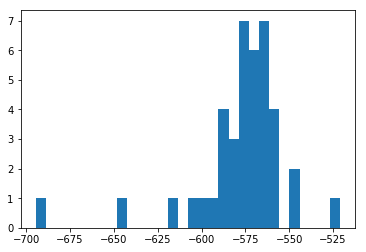

In [116]:
plt.hist(chi2[finished],bins=30)


(array([ 1.,  0.,  0.,  1.,  1.,  2.,  3.,  9., 14., 17.,  4.,  3.,  0.,
         1.,  0.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  1.]),
 array([-686.86333   , -673.45624333, -660.04915667, -646.64207   ,
        -633.23498333, -619.82789667, -606.42081   , -593.01372333,
        -579.60663667, -566.19955   , -552.79246333, -539.38537667,
        -525.97829   , -512.57120333, -499.16411667, -485.75703   ,
        -472.34994333, -458.94285667, -445.53577   , -432.12868333,
        -418.72159667, -405.31451   , -391.90742333, -378.50033667,
        -365.09325   , -351.68616333, -338.27907667, -324.87199   ,
        -311.46490333, -298.05781667, -284.65073   ]),
 <a list of 30 Patch objects>)

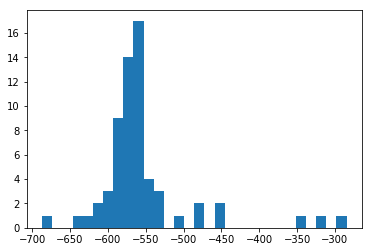

In [51]:
plt.hist(chi2[finished],bins=30)
#plt.xlim(-450,-250)

In [73]:
goodchi2 = chi2[finished] <=0

In [119]:
best85[best85['source_id']==5290667541308087168]['teff','e_teff','S/N']

<Table length=1>
    teff           e_teff        S/N  
  float64         float64      float64
------------ ----------------- -------
5929.2532458 35.92180568157033  165.06

In [349]:
#morecuts = (best85['teff'] > 4000) & (best85['proba'] >= 0.5) & (best85['astrometric_excess_noise_sig'] < 3) & (best85['teff'] < 9000) #& (best85['parallax'] > 2.35) & (best85['parallax'] < 2.5) 
morecuts = (best85['proba'] > 0.5) & (best85['astrometric_excess_noise_sig'] < 3) # & (best85['parallax'] > 2.35) & (best85['parallax'] < 2.5) 



np.sum(morecuts)

67

In [162]:
np.std(best85[morecuts]['parallax'])

0.03894277109889979

In [344]:
best61 = best85[morecuts]

(array([ 5.,  1.,  8., 10.,  3., 12.,  6.,  7.,  7.,  2.]),
 array([2.37351524, 2.38468386, 2.39585247, 2.40702108, 2.4181897 ,
        2.42935831, 2.44052692, 2.45169554, 2.46286415, 2.47403276,
        2.48520138]),
 <a list of 10 Patch objects>)

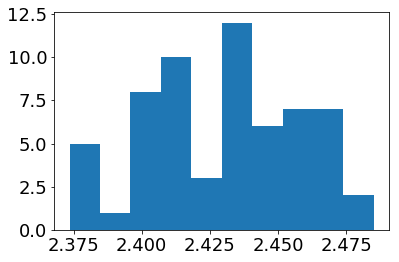

In [345]:
plt.hist(best85[morecuts]['parallax'])

In [157]:
np.nanmean(best85['parallax_err'])*3

0.08333749425522455

(18.5, 5.5)

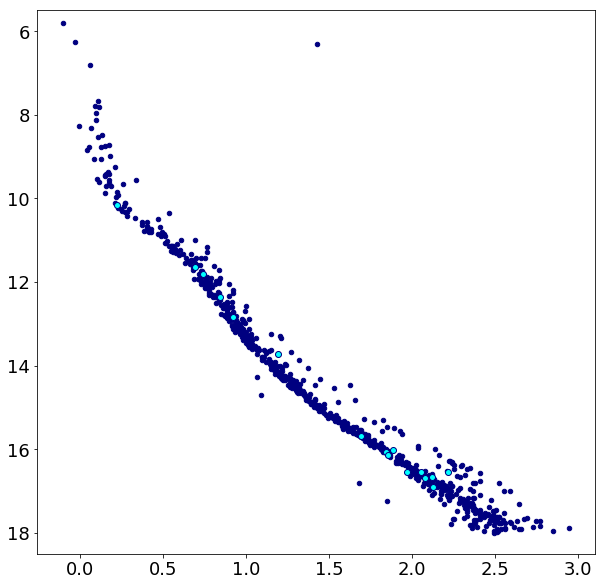

In [280]:
plt.figure(figsize=(10,10))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='navy',s=20)
#plt.scatter(allmems[highprob][ssms_indx]['bp_rp'],allmems[highprob][ssms_indx]['phot_g_mean_mag'],color='orange',s=20)

#plt.scatter(best65['bp_rp'],best65['phot_g_mean_mag'],color='cyan',edgecolors='navy')
plt.scatter(difftbl['bp_rp'],difftbl['phot_g_mean_mag'],color='cyan',edgecolors='navy')

plt.ylim(18.5,5.5)

#plt.xlim(.98,1.)
#plt.ylim(13,12)
#plt.xlim(.72,.725)

In [282]:
i1 = (difftbl['bp_rp'] > 1.1) & (difftbl['bp_rp'] < 1.3) & (difftbl['phot_g_mean_mag'] < 14)
np.sum(i1)

1

In [284]:
i2 = (difftbl['bp_rp'] > 2.2) & (difftbl['bp_rp'] < 2.5) & (difftbl['phot_g_mean_mag'] < 18)
np.sum(i2)

1

In [352]:
i3 = (best67['bp_rp'] > .7) & (best67['bp_rp'] < .725) #& (best65['phot_g_mean_mag'] < 14)
np.sum(i2)

1

In [285]:
finali = i1+i2#+i3

In [286]:
np.sum(finali)

2

In [287]:
difftbl = difftbl[~finali]

In [288]:
difftbl

<Table length=14>
        ra                 dec         ... CDIPS classification
     float64             float64       ... int64      str1     
------------------ ------------------- ... ----- --------------
119.69352745414736  -61.09960558716263 ...     1              C
119.62997956802782  -61.08969061592808 ...     1              C
119.33371932380165  -61.12049818566914 ...     1              C
118.96634354343598  -61.22241062296897 ...     1              C
119.25998129356094  -61.03465617585395 ...     1              C
 119.7312581599858  -60.93315783860372 ...     1              C
118.96424957852149   -60.9670225989847 ...     1              C
 119.4210732231115  -60.72733767006693 ...     1              C
118.86533058171912  -60.80378781179854 ...     1              C
118.93239649193438  -60.63112177512871 ...     1              C
120.06859664295227  -60.77082477379771 ...     1              C
119.87081758061746  -60.66154951640272 ...     1              C
119.55207431338823   -60.6349200237026 ...     1              C
118.71507656825491 -60.425062330986215 ...     1              C

In [314]:
bestfinal = best67[~finali]

(18.5, 5.5)

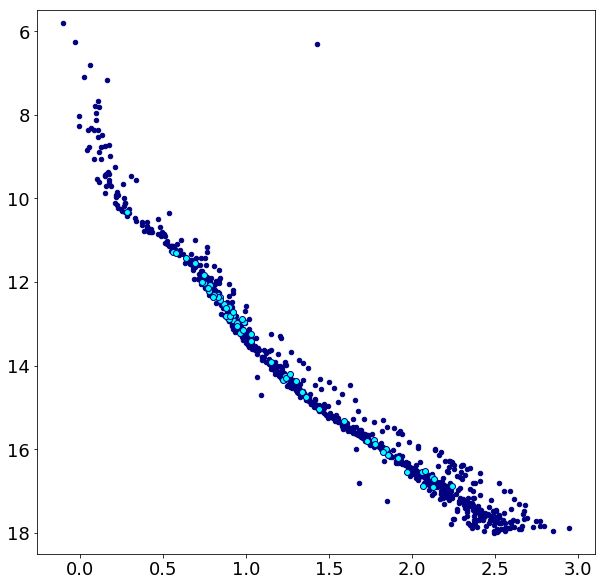

In [315]:
plt.figure(figsize=(10,10))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='navy',s=20)
#plt.scatter(allmems[highprob][ssms_indx]['bp_rp'],allmems[highprob][ssms_indx]['phot_g_mean_mag'],color='orange',s=20)

plt.scatter(bestfinal['bp_rp'],bestfinal['phot_g_mean_mag'],color='cyan',edgecolors='navy')
plt.ylim(18.5,5.5)

In [196]:
bestfinal.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/bestfinal_stars.dat',format='ascii')

In [151]:
bestfinal = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/bestfinal_stars.dat')

In [320]:
#bestfinal['source_id'].tofile('/Users/bhealy/Downloads/names62.txt',sep='\n')
difftbl['source_id'].tofile('/Users/bhealy/Downloads/names_cdips.txt',sep='\n')

In [157]:
joinperiods2[lastcuts]

<Table length=53>
        ra                 dec         ... CDIPS classification
     float64             float64       ... int64      str1     
------------------ ------------------- ... ----- --------------
119.58680314089415 -61.196060838358804 ...     1              C
119.62662452597256 -61.168576005207235 ...     1              C
119.69352745414736  -61.09960558716263 ...     1              C
119.62997956802782  -61.08969061592808 ...     1              C
119.33371932380165  -61.12049818566914 ...     1              C
118.96634354343598  -61.22241062296897 ...     1              C
119.25664864134404 -61.052291499124074 ...     1              C
119.25998129356094  -61.03465617585395 ...     1              C
119.65382340795934  -61.07613508250784 ...     1              C
119.64520129184184  -61.05329746749391 ...     1              C
               ...                 ... ...   ...            ...
119.80580283220925 -60.673281263545306 ...     1              C
119.55207431338823   -60.6349200237026 ...     1              C
120.13826831046497  -60.52314393476707 ...     1              C
120.34054291297917 -60.427906385756486 ...     1              C
120.12958796129628 -60.463474414749854 ...     1              C
 119.9654316150975  -60.36926980260596 ...     1              C
119.54578810711885  -60.41739304924166 ...     1              C
119.13311338979422  -60.46808812731028 ...     1              C
118.71507656825491 -60.425062330986215 ...     1              C
119.23937225765353 -60.298828098950274 ...     1              C

In [66]:
np.sum(goodchi2)

55

In [200]:
rtbl

#parname   median value   upper errorbar   lower errorbar
0                  M_*          0.098            1.800            0.093
1                  R_*          1.435            0.048            0.036
2                  L_*          2.460            0.160            0.140
3               \rho_*          0.047            0.910            0.045
4              \log{g}          3.100            1.300            1.300
5          T_{\rm eff}       6029.000           73.000           73.000
6         [{\rm Fe/H}]         -0.160            0.240            0.240
7                  Age          0.135            0.015            0.015
8   \log{M_*/M_{\sun}}         -1.000            1.300            1.300
9                  A_V          0.565            0.048            0.047
10        \sigma_{SED}          2.020            1.200            0.620
11              \varpi          2.466            0.035            0.036
12                   d        405.600            6.000            5.700

In [10]:
#resultsfiles = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/fitresults_nomist/medianresults/*')
#resultsfiles = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/fitresults_ultimate/medianresults/*')
resultsfiles = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/fitresults_cdips/medianresults/*')


resultsfiles = np.array(resultsfiles)

In [11]:
len(resultsfiles)

6

In [12]:
r = []
rhierr = []
rloerr = []
teff = []
teffhierr = []
teffloerr = []
lum = []
lumhierr = []
lumloerr = []
eep = []

sid = []
for f in resultsfiles:
    rtbl = pd.read_csv(f)
    r += [rtbl[' median value'][1]]
    teff += [rtbl[' median value'][5]]
    rhierr += [rtbl[' upper errorbar'][1]]
    rloerr += [rtbl[' lower errorbar'][1]]
    teffhierr += [rtbl[' upper errorbar'][5]]
    teffloerr += [rtbl[' upper errorbar'][5]]
    lum += [rtbl[' median value'][2]]
    lumhierr += [rtbl[' upper errorbar'][2]]
    lumloerr += [rtbl[' upper errorbar'][2]]
    eep += [rtbl[' median value'][9]]
    age = [rtbl[' median value'][8]]
    
    sid += [np.int(f[-30:-11])]
r = np.array(r)
teff = np.array(teff)
rhierr = np.array(rhierr)
teffhierr = np.array(teffhierr)
rloerr = np.array(rloerr)
teffloerr = np.array(teffloerr)
lum = np.array(lum)
lumhierr = np.array(lumhierr)
lumloerr = np.array(lumloerr)
eep = np.array(eep)
age = np.array(age)

(array([1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.]),
 array([224.7, 230.5, 236.3, 242.1, 247.9, 253.7, 259.5, 265.3, 271.1,
        276.9, 282.7, 288.5, 294.3, 300.1, 305.9, 311.7]),
 <a list of 15 Patch objects>)

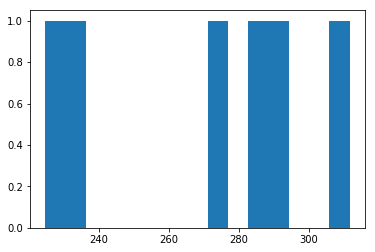

In [13]:
plt.hist(eep,bins=15)

In [131]:
resultsfiles[~goodchi2]

NameError: name 'goodchi2' is not defined

In [1613]:
eepindx = (eep < 280) & (eep > 240)

In [1651]:
np.median(eep)

258.4

In [14]:
rad = unumpy.uarray(r,rhierr)
T = unumpy.uarray(teff,teffhierr)

In [970]:
sigma = 5.7e-8
lum = 4 * np.pi * (rad*7e8)**2 * sigma * T**4
lum /= 3.83e26
lum = unumpy.log10(lum)
lumnom = []
lumerr = []
for i in range(len(lum)):
    lumnom += [lum[i].nominal_value]
    lumerr += [lum[i].std_dev]
lumnom = np.array(lumnom)
lumerr = np.array(lumerr)

In [661]:
preradius_targs = singlestars[singlestars['vsini'] >= 5]

In [1430]:
lumhierr

array([1.1   , 0.35  , 0.14  , 0.19  , 0.018 , 0.16  , 0.12  , 0.12  ,
       0.3   , 1.7   , 0.22  , 0.15  , 0.029 , 0.27  , 0.094 , 0.025 ,
       0.37  , 0.23  , 0.095 , 0.13  , 2.1   , 0.6   , 0.25  , 0.25  ,
       0.14  , 0.019 , 0.0098, 0.021 , 0.041 , 0.22  , 0.32  , 0.11  ,
       0.18  , 0.74  , 0.02  , 0.2   , 0.085 , 0.47  , 0.13  , 0.11  ,
       0.11  , 0.35  , 0.038 , 0.36  , 0.0074, 0.26  , 0.19  , 0.42  ,
       0.038 , 0.25  , 0.76  , 0.007 , 0.81  , 0.13  , 0.45  , 0.25  ,
       0.14  , 0.16  , 0.11  , 0.13  , 0.35  , 0.28  , 0.66  , 0.32  ,
       0.19  , 0.16  , 0.22  , 1.7   , 0.11  ])

In [216]:
len(teff)

56

Text(0,0.5,'L [Lsun]')

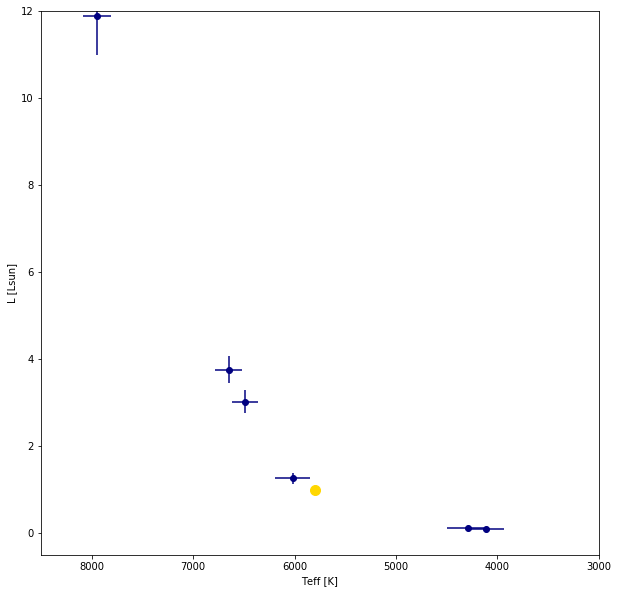

In [15]:
plt.figure(figsize=(10,10))
plt.scatter(teff,lum,color='navy')
plt.errorbar(teff,lum,xerr=teffhierr,yerr=lumhierr,linestyle='none',color='navy')
plt.scatter(5800,1,color='gold',s=100,zorder=3)

plt.xlim(12500,3000)
plt.xlim(8500,3000)
#plt.ylim(-4,4)
plt.ylim(-.5,12)
plt.xlabel('Teff [K]')
plt.ylabel('L [Lsun]')

Text(0,0.5,'L [Lsun]')

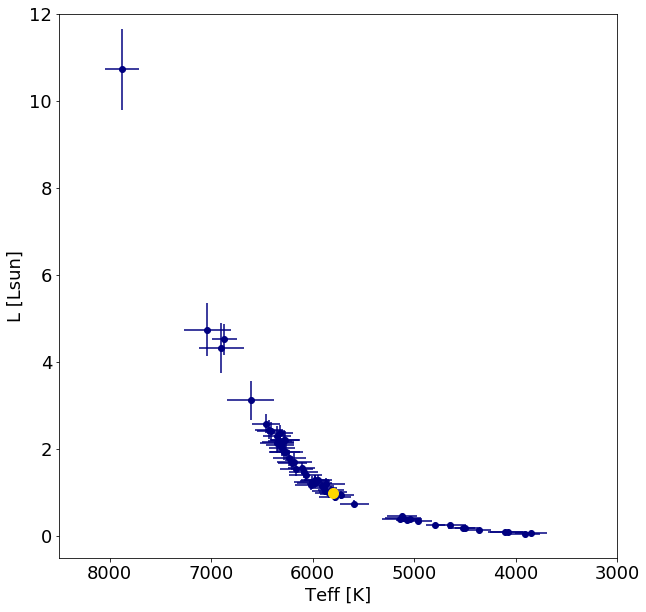

In [150]:
plt.figure(figsize=(10,10))
plt.scatter(teff,lum,color='navy')
plt.errorbar(teff,lum,xerr=teffhierr,yerr=lumhierr,linestyle='none',color='navy')
plt.scatter(5800,1,color='gold',s=100,zorder=3)

plt.xlim(12500,3000)
plt.xlim(8500,3000)
#plt.ylim(-4,4)
plt.ylim(-.5,12)
plt.xlabel('Teff [K]')
plt.ylabel('L [Lsun]')

(8000, 3000)

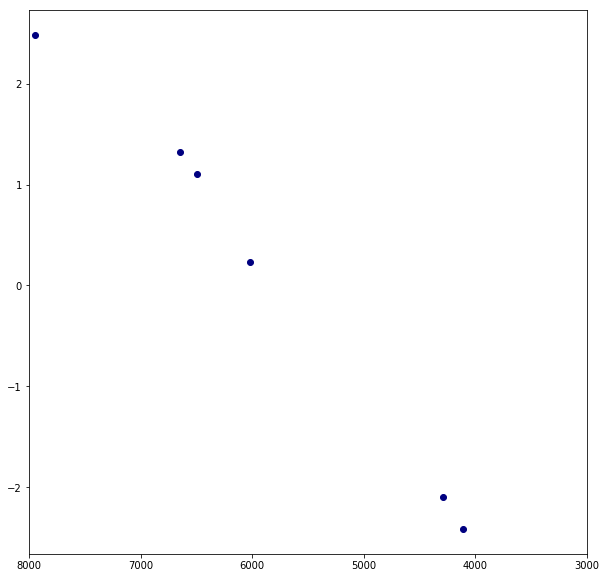

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(teff,np.log(lum),color='navy')
plt.xlim(8000,3000)


In [33]:
#restbl = Table(data=[sid,r,rhierr,rloerr,teff,teffhierr,teffloerr,lum,lumhierr,lumloerr],names=['source_id','exofast_r','r_hi_err','r_lo_err','exofast_teff','teff_hi_err','teff_lo_err','lum','lumhierr','lumloerr'])
restbl = Table(data=[sid,r,rhierr,rloerr,teff,teffhierr,teffloerr],names=['source_id','exofast_r','r_hi_err','r_lo_err','exofast_teff','teff_hi_err','teff_lo_err'])

#restbl.sort(keys='exofast_teff')


restbl#[eepindx]


<Table length=6>
     source_id          exofast_r      ... teff_hi_err teff_lo_err
       int64             float64       ...   float64     float64  
------------------- ------------------ ... ----------- -----------
5290715919819356800              0.637 ...       210.0       210.0
5290934997509679232              0.593 ...       170.0       170.0
5290664929967787264              1.375 ...       130.0       130.0
5290725437466835840              1.817 ...       140.0       140.0
5290660738079873408 1.0290000000000001 ...       170.0       170.0
5290655549759621888 1.4609999999999999 ...       130.0       130.0

In [1642]:
ges_galah_targets_slice_merged[ges_galah_targets_slice_merged['source_id'] == 5290715954179096320]['e_teff']

<Column name='e_teff' dtype='float64' length=1>
146.55237877451353

In [153]:
teffcutoff = restbl['exofast_teff'] < 20000

Text(0,0.5,'logL [Lsun]')

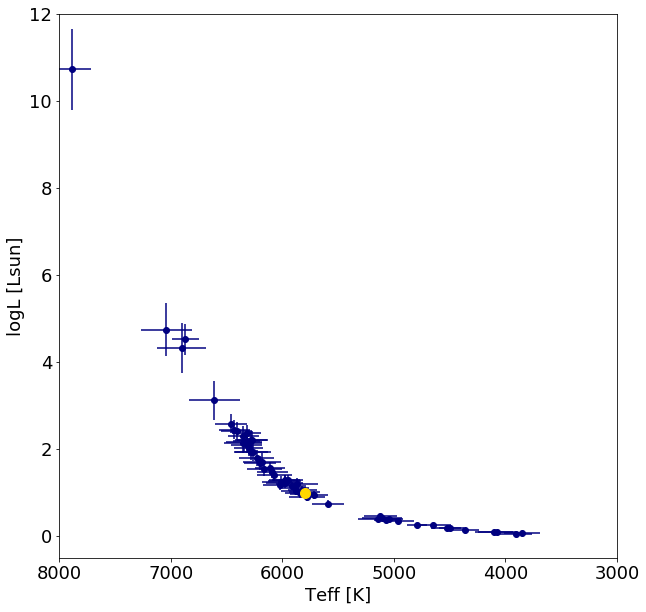

In [154]:
nb = 12
meds,edges,number = binned_statistic(restbl['exofast_teff'],restbl['lum'],statistic='median',bins=nb)
width = (edges[1] - edges[0])
centers = edges[1:] - width/2

teffgrid = np.arange(np.min(restbl['exofast_teff']),np.max(restbl['exofast_teff']),.001)


plt.figure(figsize=(10,10))
plt.scatter(restbl['exofast_teff'],restbl['lum'],color='navy')
plt.errorbar(restbl['exofast_teff'],restbl['lum'],xerr=restbl['teff_hi_err'],yerr=restbl['lumhierr'],linestyle='none',color='navy')
plt.scatter(5800,1,color='gold',s=100,zorder=3)
#plt.plot(centers,meds,linewidth=2,color='red')

#plt.xlim(12500,3000)
plt.xlim(8000,3000)
#plt.ylim(-4,4)
plt.ylim(-.5,12)
plt.xlabel('Teff [K]')
plt.ylabel('logL [Lsun]')

In [135]:
goodstars = (restbl['exofast_teff'] > 5400) & (restbl['exofast_teff'] < 8000) & (restbl['lum'] < 2)

In [136]:
np.sum(goodstars)

26

In [137]:
restbl[(restbl['exofast_r'] > 1.2) & (restbl['exofast_teff'] < 6000)]

<Table length=0>
source_id exofast_r r_hi_err r_lo_err ... teff_lo_err   lum   lumhierr lumloerr
  int64    float64  float64  float64  ...   float64   float64 float64  float64 
--------- --------- -------- -------- ... ----------- ------- -------- --------

In [1618]:
#restbl = restbl[eepindx]

Text(0,0.5,'Radius [Rsun]')

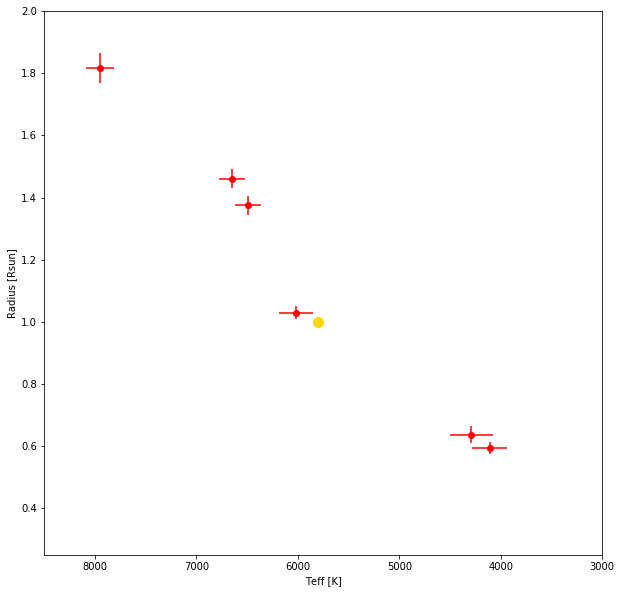

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(restbl['exofast_teff'],restbl['exofast_r'],color='red')
plt.errorbar(restbl['exofast_teff'],restbl['exofast_r'],yerr=restbl['r_hi_err'],xerr=restbl['teff_hi_err'],linestyle='none',color='red')
plt.scatter(5800,1,color='gold',s=100,zorder=3)
plt.xlim(13000,3000)
plt.xlim(8500,3000)
#plt.xlim(8000,5500)
plt.ylim(0.25,2)

#plt.ylim(.5,2)
plt.xlabel('Teff [K]')
plt.ylabel('Radius [Rsun]')

Text(0,0.5,'Radius [Rsun]')

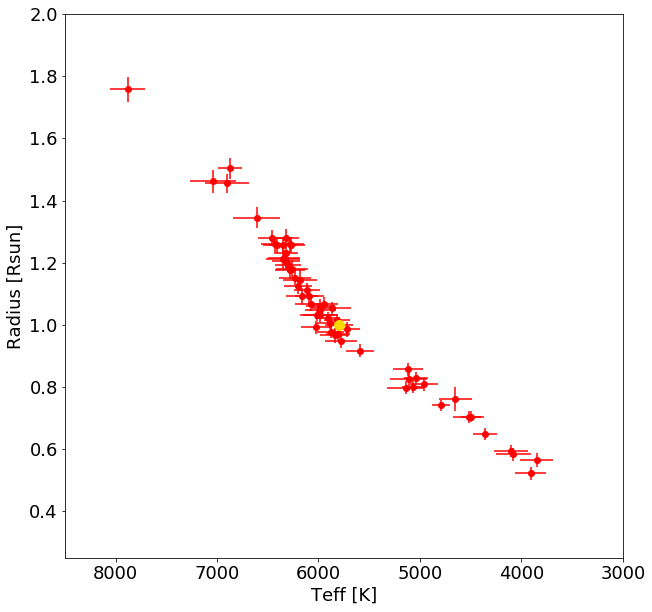

In [155]:
plt.figure(figsize=(10,10))
plt.scatter(restbl['exofast_teff'],restbl['exofast_r'],color='red')
plt.errorbar(restbl['exofast_teff'],restbl['exofast_r'],yerr=restbl['r_hi_err'],xerr=restbl['teff_hi_err'],linestyle='none',color='red')
plt.scatter(5800,1,color='gold',s=100,zorder=3)
plt.xlim(13000,3000)
plt.xlim(8500,3000)
#plt.xlim(8000,5500)
plt.ylim(0.25,2)

#plt.ylim(.5,2)
plt.xlabel('Teff [K]')
plt.ylabel('Radius [Rsun]')

Text(0,0.5,'Radius [Rsun]')

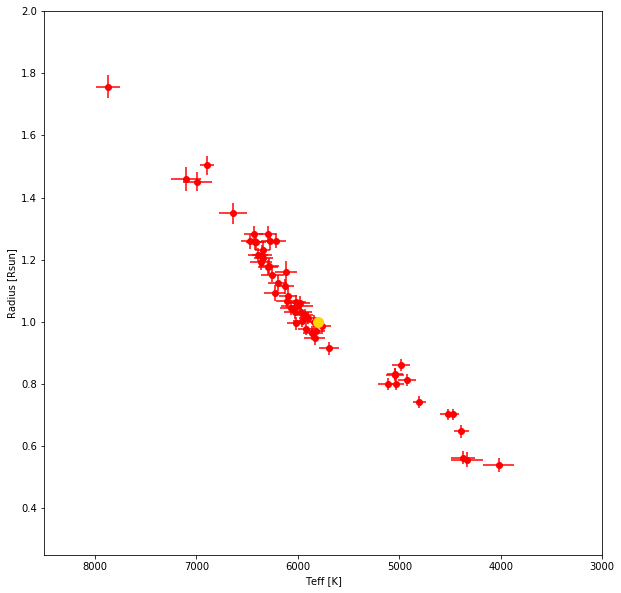

In [234]:
plt.figure(figsize=(10,10))
plt.scatter(restbl['exofast_teff'],restbl['exofast_r'],color='red')
plt.errorbar(restbl['exofast_teff'],restbl['exofast_r'],yerr=restbl['r_hi_err'],xerr=restbl['teff_hi_err'],linestyle='none',color='red')
plt.scatter(5800,1,color='gold',s=100,zorder=3)
plt.xlim(13000,3000)
plt.xlim(8500,3000)
#plt.xlim(8000,5500)
plt.ylim(0.25,2)

#plt.ylim(.5,2)
plt.xlabel('Teff [K]')
plt.ylabel('Radius [Rsun]')

Text(0,0.5,'Radius [Rsun]')

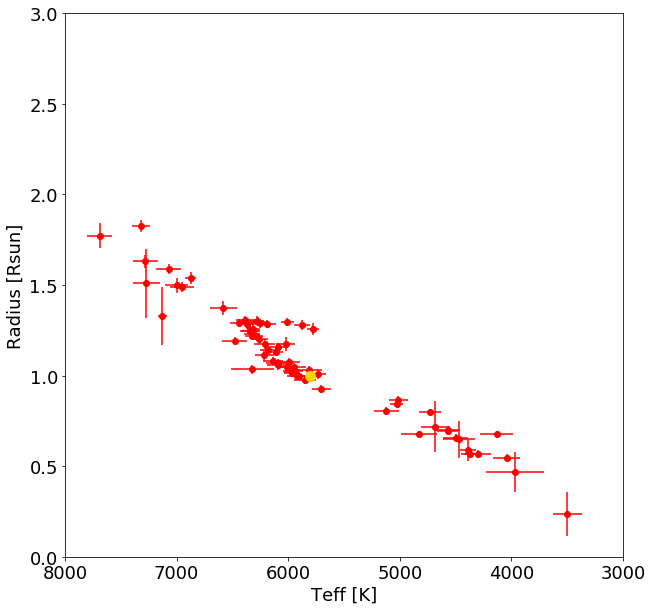

In [1275]:
plt.figure(figsize=(10,10))
plt.scatter(restbl['exofast_teff'],restbl['exofast_r'],color='red')
plt.errorbar(restbl['exofast_teff'],restbl['exofast_r'],yerr=restbl['r_hi_err'],xerr=restbl['teff_hi_err'],linestyle='none',color='red')
plt.scatter(5800,1,color='gold',s=100,zorder=3)
plt.xlim(13000,3000)
plt.xlim(8000,3000)
plt.ylim(0,3)
plt.xlabel('Teff [K]')
plt.ylabel('Radius [Rsun]')

In [989]:
ges_galah_targets_updated[ges_galah_targets_updated['Survey'] == 'Galah']['teff','e_teff']

<Table length=12>
       teff              e_teff      
     float64            float64      
------------------ ------------------
  6992.81870920835  56.68554358705167
 7126.694074447153 22.583308532218513
 7291.238087232758  50.80979351610363
  6455.49817752534   65.7830452940881
  7593.80832387458  45.67498810067375
 7160.544880261527  49.12404323101339
 6938.448039664161  54.46262052436312
7242.2728979872345  59.43306110240742
 7192.755294128188  60.09964609509814
6053.6007897116515  94.01370309699415
 6816.284333582353  61.32540894994168
 7609.980036885936  53.02310527602483

In [156]:
exofast_restbl = join(ges_galah_targets_updated,restbl['source_id','exofast_r'],join_type='outer')

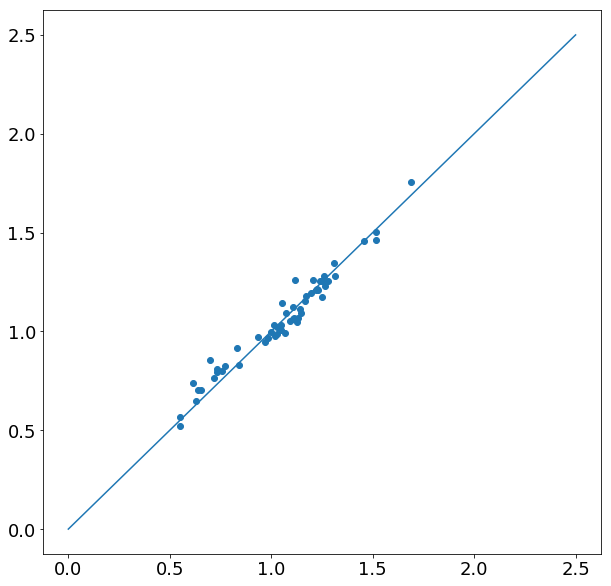

In [157]:
plt.figure(figsize=(10,10))
plt.scatter(exofast_restbl['gaia_r'],exofast_restbl['exofast_r'])
plt.plot([0,2.5],[0,2.5])

In [1622]:
combin_tbl = join(ges_galah_targets_slice_merged,restbl)

In [34]:
#combin_tbl = join(bestfinal,restbl)
combin_difftbl = join(difftbl,restbl)

In [35]:
combin_difftbl

<Table length=6>
        ra                 dec         ... teff_hi_err teff_lo_err
     float64             float64       ...   float64     float64  
------------------ ------------------- ... ----------- -----------
119.69352745414736  -61.09960558716263 ...       130.0       130.0
119.33371932380165  -61.12049818566914 ...       170.0       170.0
119.25998129356094  -61.03465617585395 ...       130.0       130.0
118.96424957852149   -60.9670225989847 ...       210.0       210.0
 119.4210732231115  -60.72733767006693 ...       140.0       140.0
118.71507656825491 -60.425062330986215 ...       170.0       170.0

In [175]:
excl_tbl = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/finalrun_exclude.dat')
excl_tbl

<Table length=10>
      exclude      
       int64       
-------------------
5290741208586484352
5290730144750809472
5290672557829815296
5290722276370987648
5290750382637937920
5290815734859774080
5290819342632176512
5290820064186534144
5290820442143654656
5290934997509679232

In [355]:
count=0
for i in range(len(excl_tbl)):
    if excl_tbl['exclude'][i] in bestfinal_nobinaries['source_id']:
        count += 1
print(count)

3


In [356]:
bestfinal_nobinaries

<Table length=58>
     source_id       AV_SFD ... astrometric_excess_noise_sig
       int64        float64 ...           float64           
------------------- ------- ... ----------------------------
5290652938419483904  0.6338 ...                          0.0
5290653075858442752  0.6503 ...                          0.0
5290655687198404864   0.643 ...          0.23308458536138574
5290664861248309760  0.6484 ...                          0.0
5290665204845694336  0.6704 ...                          0.0
5290667472588665600  0.6362 ...                          0.0
5290667541308087168  0.6274 ...                          0.0
5290667713106775040  0.6342 ...                          0.0
5290669873469360512  0.6544 ...                          0.0
5290673348103622272  0.6453 ...                          0.0
                ...     ... ...                          ...
5290830097230075904  0.6169 ...                          0.0
5290838962037067648  0.6016 ...                          0.0
5290894727896572160  0.7626 ...           0.1725082867816237
5290897266218055040  0.7822 ...                          0.0
5290931561536172416  0.6142 ...                          0.0
5290934997509679232  0.6142 ...          0.13790562167894524
5290935993942419840   0.589 ...                          0.0
5291030448862535808  0.5419 ...                          0.0
5291032132489758208  0.5223 ...                          0.0
5291032613526130048  0.5443 ...            1.819105352872113

In [160]:
bestfinal[bestfinal['source_id']==5290741208586484352]['vsini','period']

<Table length=1>
 vsini        period      
float64      float64      
------- ------------------
   23.4 1.4250262005492456

In [161]:
23.4*1e3/(2*np.pi*1.26*7e8/(1.425*24*3600))

0.5198715014595184

In [220]:
combin_tbl_df= combin_tbl.to_pandas()

In [221]:
combin_tbl_df.set_index('source_id',inplace=True)

In [222]:
for i in range(len(excl_tbl)):
    combin_tbl_df.drop(excl_tbl['exclude'][i],inplace=True)

In [223]:
combin_tbl_df.reset_index(inplace=True)

In [224]:
combin_tbl = Table(data=combin_tbl_df.get_values(),names=combin_tbl_df.columns,dtype=combin_tbl_df.dtypes)

In [225]:
combin_tbl

<Table length=48>
     source_id       AV_SFD ...       lumhierr             lumloerr      
       int64        float64 ...       float64              float64       
------------------- ------- ... -------------------- --------------------
5290652938419483904  0.6338 ...                 0.14                 0.14
5290653075858442752  0.6503 ... 0.027999999999999997 0.027999999999999997
5290655549759622144  0.6359 ...                 0.24                 0.24
5290664861248309760  0.6484 ...                0.099                0.099
5290667472588665600  0.6362 ...                  0.1                  0.1
5290667541308087168  0.6274 ...  0.09699999999999999  0.09699999999999999
5290667713106775040  0.6342 ...                0.087                0.087
5290669873469360512  0.6544 ...                 0.14                 0.14
5290673348103622272  0.6453 ... 0.044000000000000004 0.044000000000000004
5290710800218328192  0.7932 ...                 0.15                 0.15
                ...     ... ...                  ...                  ...
5290823568880135296  0.6462 ...                 0.14                 0.14
5290824320493640576  0.6525 ...                  0.2                  0.2
5290826558177392640  0.6134 ...                  0.2                  0.2
5290826936134381440  0.6334 ...                 0.18                 0.18
5290830097230075904  0.6169 ...                 0.22                 0.22
5290838962037067648  0.6016 ...                 0.21                 0.21
5290931561536172416  0.6142 ...                 0.17                 0.17
5291030448862535808  0.5419 ...                 0.19                 0.19
5291032132489758208  0.5223 ...                 0.57                 0.57
5291032613526130048  0.5443 ...                 0.94                 0.94

In [79]:
from astroquery.simbad import Simbad

In [176]:
qry=Simbad.query_object('Gaia DR2 5290815734859774080')
qry

<Table length=1>
          MAIN_ID                 RA      ... COO_WAVELENGTH     COO_BIBCODE    
                               "h:m:s"    ...                                   
           object               str13     ...      str1             object      
--------------------------- ------------- ... -------------- -------------------
Cl* NGC 2516    JTH   10046 07 58 57.5497 ...              O 2018yCat.1345....0G

In [177]:
Simbad.list_votable_fields()

--NOTES--

1. The parameter filtername must correspond to an existing filter. Filters include: B,V,R,I,J,K.  They are checked by SIMBAD but not astroquery.simbad

2. Fields beginning with rvz display the data as it is in the database. Fields beginning with rv force the display as a radial velocity. Fields beginning with z force the display as a redshift

3. For each measurement catalog, the VOTable contains all fields of the first measurement. When applicable, the first measurement is the mean one. 

Available VOTABLE fields:

bibcodelist(y1-y2)
biblio
cel
cl.g
coo(opt)
coo_bibcode
coo_err_angle
coo_err_maja
coo_err_mina
coo_qual
coo_wavelength
coordinates
dec(opt)
dec_prec
diameter
dim
dim_angle
dim_bibcode
dim_incl
dim_majaxis
dim_minaxis
dim_qual
dim_wavelength
dimensions
distance
distance_result
einstein
fe_h
flux(filtername)
flux_bibcode(filtername)
flux_error(filtername)
flux_name(filtername)
flux_qual(filtername)
flux_system(filtername)
flux_unit(filtername)
fluxdata(filtername)

In [80]:
customSimbad = Simbad()

In [81]:
customSimbad.add_votable_fields('otype')

In [395]:
sss_merged = sss_merged[sss_merged['astrometric_excess_noise_sig'] < 3]

In [84]:
sbindx = []
singindx = []
#for i in range(len(bestfinal)):
#    qry = customSimbad.query_object('Gaia DR2 '+np.str(bestfinal['source_id'][i]))
#for i in range(len(sss_merged)):
#    qry = customSimbad.query_object('Gaia DR2 '+np.str(sss_merged['source_id'][i]))
for i in range(len(singlestars)):
    qry = customSimbad.query_object('Gaia DR2 '+np.str(singlestars['source_id'][i]))    
    try:
        print(i,qry['OTYPE'].data)
        if (qry['OTYPE'].data[0] == b'SB*') or (qry['OTYPE'].data[0] == b'PulsV*delSct'):
            sbindx += [i]
        else:
            singindx += [i]
    except TypeError:
        sbindx += [i]

0 [b'Star']
1 [b'Star']
2 [b'Star']
3 [b'RotV*alf2CVn']
4 [b'RotV*alf2CVn']
5 [b'Star']
6 [b'Star']
7 [b'Star']
8 [b'SB*']
9 [b'Star']
10 [b'Star']
11 [b'SB*']
12 [b'Star']
14 [b'SB*']
15 [b'Star']
16 [b'Star']
17 [b'Star']
18 [b'Star']
19 [b'Star']
20 [b'Star']
21 [b'Star']
22 [b'Star']
23 [b'Star']
24 [b'Star']


/anaconda3/envs/astroconda/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 5290816937450497408
  (error.line, error.msg))


25 [b'Star']
26 [b'Star']
27 [b'Star']
28 [b'Star']
29 [b'Star']
30 [b'Star']
31 [b'Star']
32 [b'Star']
33 [b'Star']
34 [b'Star']
35 [b'Star']
36 [b'Star']
37 [b'V*']
38 [b'PulsV*delSct']
39 [b'Star']
40 [b'Star']
41 [b'Star']
42 [b'Star']
43 [b'Star']
44 [b'Star']
45 [b'Star']
46 [b'Star']
47 [b'Star']
48 [b'Star']
49 [b'PulsV*delSct']
50 [b'Star']
51 [b'PulsV*delSct']
52 [b'Star']
53 [b'Star']
54 [b'Star']
55 [b'Star']
56 [b'Star']
57 [b'Star']
58 [b'Star']
59 [b'Star']
60 [b'Star']
61 [b'Star']
62 [b'Star']
63 [b'V*']
64 [b'Star']
65 [b'Star']
66 [b'Star']
67 [b'Star']
68 [b'Star']
69 [b'Star']
70 [b'Star']
71 [b'Star']
72 [b'Star']
73 [b'Star']
74 [b'Star']
75 [b'Star']
76 [b'Star']
77 [b'V*']
78 [b'Star']
79 [b'Star']
80 [b'Star']
81 [b'Star']
82 [b'Star']
83 [b'Star']
84 [b'SB*']
85 [b'Star']
86 [b'Star']
87 [b'Star']
88 [b'Star']
89 [b'Star']
90 [b'Star']
91 [b'Star']
92 [b'Star']
93 [b'Star']
94 [b'Star']
95 [b'Star']
96 [b'Star']
97 [b'Star']
98 [b'Star']
99 [b'Star']
100 [b'S

/anaconda3/envs/astroconda/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 5289932277265953280
  (error.line, error.msg))


155 [b'Star']
157 [b'Star']
158 [b'Star']
159 [b'Star']
160 [b'Star']
161 [b'Star']
162 [b'Star']
163 [b'Star']
164 [b'Star']
165 [b'Star']
166 [b'Star']
167 [b'Star']
168 [b'Star']
169 [b'Star']
170 [b'Star']
171 [b'Star']
172 [b'Star']
173 [b'Star']
174 [b'Star']
175 [b'Star']
176 [b'Star']
177 [b'Star']
178 [b'Star']
179 [b'Star']
180 [b'Star']
181 [b'Star']
182 [b'Star']
183 [b'Star']
184 [b'Star']
185 [b'Star']
186 [b'Star']
187 [b'Star']
188 [b'SB*']
189 [b'Star']
190 [b'Star']
191 [b'Star']
192 [b'Star']
193 [b'Star']
194 [b'Star']
195 [b'Star']
196 [b'Star']
197 [b'Star']
198 [b'Star']
199 [b'Star']
200 [b'Star']
201 [b'Star']
202 [b'Star']
203 [b'Star']
204 [b'Star']
205 [b'Star']
206 [b'Star']
207 [b'Star']


/anaconda3/envs/astroconda/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 5290918642274007808
  (error.line, error.msg))


209 [b'Star']
210 [b'Star']
211 [b'Star']
212 [b'Star']
213 [b'Star']
214 [b'Star']
215 [b'Star']
216 [b'Star']
217 [b'Star']
218 [b'SB*']
219 [b'Star']
220 [b'SB*']
221 [b'Star']
222 [b'Star']
223 [b'Star']
224 [b'Star']
225 [b'Star']
226 [b'Star']
227 [b'SB*']
228 [b'SB*']
229 [b'Star']
230 [b'Star']
231 [b'Star']
232 [b'Star']
233 [b'Star']
234 [b'Star']
235 [b'Star']
236 [b'Star']
237 [b'Star']
238 [b'Star']
239 [b'Star']
240 [b'Star']
241 [b'Star']
242 [b'Star']
243 [b'Star']
244 [b'Star']
245 [b'Star']
246 [b'Star']
247 [b'Star']
248 [b'Star']
249 [b'Star']
250 [b'Star']
251 [b'Star']
252 [b'Star']
253 [b'Star']
254 [b'Star']
255 [b'Star']
256 [b'Star']
257 [b'Star']
258 [b'Star']
259 [b'Star']
260 [b'Star']
261 [b'Star']
262 [b'Star']
263 [b'SB*']
264 [b'Star']
265 [b'Star']
266 [b'Star']
267 [b'Star']
268 [b'Star']
269 [b'Star']
270 [b'Star']
271 [b'Star']
272 [b'Star']
273 [b'Star']
274 [b'Star']
275 [b'SB*']
276 [b'Star']
277 [b'Star']
278 [b'Star']
279 [b'Star']
280 [b'Star'

/anaconda3/envs/astroconda/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 5290748424132935424
  (error.line, error.msg))


382 [b'Star']
383 [b'Star']
384 [b'Star']
385 [b'Star']
386 [b'low-mass*']
387 [b'Star']
388 [b'low-mass*']
389 [b'Star']
390 [b'Star']
391 [b'Star']
392 [b'Star']
393 [b'Star']
394 [b'Star']
395 [b'Star']
396 [b'Star']
397 [b'Star']
398 [b'low-mass*']
399 [b'low-mass*']
400 [b'Star']
401 [b'low-mass*']
402 [b'Star']
403 [b'Star']
404 [b'Star']
405 [b'low-mass*']
406 [b'Star']
407 [b'Star']
408 [b'low-mass*']
409 [b'Star']
410 [b'Star']
411 [b'Star']
412 [b'low-mass*']
413 [b'low-mass*']
414 [b'low-mass*']
415 [b'Star']
416 [b'low-mass*']
417 [b'Star']


/anaconda3/envs/astroconda/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 5290767523846011520
  (error.line, error.msg))


419 [b'Star']
420 [b'Star']
421 [b'Star']
422 [b'Star']
423 [b'low-mass*']
424 [b'low-mass*']
425 [b'Star']
426 [b'Star']
427 [b'Star']
428 [b'Star']
429 [b'Star']
430 [b'Star']
431 [b'Star']
432 [b'low-mass*']
433 [b'low-mass*']
434 [b'Star']
435 [b'low-mass*']
436 [b'Star']
437 [b'low-mass*']
438 [b'low-mass*']
439 [b'Star']
440 [b'Star']
441 [b'Star']
442 [b'Star']
443 [b'Star']
444 [b'Star']
445 [b'low-mass*']
446 [b'Star']
447 [b'Star']
448 [b'Star']
449 [b'low-mass*']
450 [b'Star']
451 [b'low-mass*']
452 [b'low-mass*']
453 [b'Star']
454 [b'Star']
455 [b'low-mass*']
456 [b'Star']
457 [b'low-mass*']
458 [b'low-mass*']
459 [b'Star']
460 [b'Star']
461 [b'Star']
462 [b'low-mass*']
463 [b'low-mass*']
464 [b'Star']
465 [b'low-mass*']
466 [b'Star']
467 [b'Star']
468 [b'Star']
469 [b'Star']
470 [b'low-mass*']
471 [b'low-mass*']
472 [b'Star']
473 [b'low-mass*']
474 [b'Star']
475 [b'low-mass*']
476 [b'Star']
477 [b'Star']
478 [b'Star']
479 [b'Star']
480 [b'Star']
481 [b'Star']
482 [b'Star']

/anaconda3/envs/astroconda/lib/python3.6/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR2 5291048453365494400
  (error.line, error.msg))


535 [b'Star']
536 [b'Star']
537 [b'Star']
538 [b'Star']
539 [b'low-mass*']
540 [b'low-mass*']
541 [b'Star']
542 [b'Star']
543 [b'Star']
544 [b'low-mass*']
545 [b'Star']
546 [b'Star']
547 [b'Star']
548 [b'Star']
549 [b'low-mass*']
550 [b'Star']
551 [b'Star']
552 [b'low-mass*']
553 [b'Star']
554 [b'Star']
555 [b'low-mass*']
556 [b'low-mass*']
557 [b'Star']
558 [b'Star']
559 [b'Star']
560 [b'low-mass*']
561 [b'Star']
562 [b'Star']
563 [b'Star']
564 [b'Star']
565 [b'Star']
566 [b'Star']
567 [b'Star']
568 [b'Star']
569 [b'low-mass*']
570 [b'low-mass*']
571 [b'Star']
572 [b'low-mass*']
573 [b'Star']
574 [b'Star']
575 [b'low-mass*']
576 [b'Star']
577 [b'low-mass*']
578 [b'low-mass*']
579 [b'Star']
580 [b'low-mass*']
581 [b'low-mass*']
582 [b'Star']
583 [b'low-mass*']
584 [b'Star']
585 [b'Star']
586 [b'low-mass*']
587 [b'low-mass*']
588 [b'Star']
589 [b'Star']
590 [b'low-mass*']
591 [b'Star']
592 [b'Star']
593 [b'Star']
594 [b'Star']
595 [b'low-mass*']


In [86]:
onesig_mems_nosbs = singlestars[singindx]

In [87]:
onesig_mems_nosbs.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/onesigma_members_noSBs.dat',format='ascii')

In [575]:
sbindx = []
singindx = []
#for i in range(len(bestfinal)):
#    qry = customSimbad.query_object('Gaia DR2 '+np.str(bestfinal['source_id'][i]))
#for i in range(len(sss_merged)):
#    qry = customSimbad.query_object('Gaia DR2 '+np.str(sss_merged['source_id'][i]))
for i in range(len(excl_tbl)):
    qry = customSimbad.query_object('Gaia DR2 '+np.str(excl_tbl['exclude'][i]))    
    try:
        print(i,qry['OTYPE'].data)
        if (qry['OTYPE'].data[0] == b'SB*') or (qry['OTYPE'].data[0] == b'PulsV*delSct'):
            sbindx += [i]
        else:
            singindx += [i]
    except TypeError:
        sbindx += [i]

0 [b'Star']
1 [b'Star']
2 [b'SB*']
3 [b'SB*']
4 [b'SB*']
5 [b'SB*']
6 [b'SB*']
7 [b'SB*']
8 [b'Star']
9 [b'Star']


In [408]:
sss_merged[singindx]

<Table length=732>
        ra                 dec         ... astrometric_excess_noise_sig
     float64             float64       ...           float64           
------------------ ------------------- ... ----------------------------
120.92347226164134  -60.90750623116792 ...           2.8659240562280126
119.53351760067623  -60.78049923778595 ...           0.3563840348359983
119.48849012769524  -60.75724495255902 ...           2.5599997898028537
119.16036257093539  -60.77604713858194 ...           1.1921844569846507
 119.4210732231115  -60.72733767006693 ...           2.4990136097204503
118.53751875121381  -60.71156024889231 ...           0.9701412342883471
119.31743340645221  -60.42717907081204 ...           0.9171151864312368
117.96477020735708  -60.15880628811523 ...            2.775526833185336
118.40287495345486  -60.90825791506504 ...                          0.0
119.83694280087349 -60.424639055921205 ...            2.965353241488826
               ...                 ... ...                          ...
120.66891417136276  -60.40556839669539 ...           0.5537113964276518
118.98751592629696   -61.0130551446161 ...           1.3925195011502078
118.56885657257939 -60.997661147221706 ...           2.7199625721245293
118.94857807006746  -60.39533407434025 ...           0.8613349035129686
119.06339117109313  -60.39068739243173 ...           1.4796186967072695
119.54954188795023  -61.02826735416334 ...           0.5219666051947189
 119.0325251335964 -60.951347574422144 ...           2.6048205592355083
119.11969470816571 -60.942869906540714 ...           0.6241179032542183
119.21050701756289  -60.96026378595356 ...            1.097861133356462
120.65359343622917  -60.79052924528672 ...           1.5951028780478511

In [663]:
join(SSMgrv2,joinperiods2)

TableMergeError: Left key column 'Cluster' has missing values

In [665]:
joinperiods2['teff']

<Column name='teff' dtype='float64' length=64>
 4216.965034285822
 4808.393484497285
 5445.026528424214
 5997.910762555094
 3971.915494694405
 5807.644175213118
 6067.363295885053
4045.7589169744288
3990.2490236214207
 4305.266104917106
  4275.62886151586
3556.3131856898544
               ...
 4395.416154378243
3990.2490236214207
 4187.935651179182
      5929.2532458
 6208.690342300638
 6194.410750767812
4954.5019080479005
 4436.086439314323
 5584.701947368307
 6324.118513762197
 5847.900841444806
 6295.061828571975

In [214]:
sbindx = []
for i in range(len(combin_tbl)):
    qry = customSimbad.query_object('Gaia DR2 '+np.str(combin_tbl['source_id'][i]))
    print(i,qry['OTYPE'].data)
    if qry['OTYPE'].data[0] == b'SB*':
        sbindx += [i]

0 [b'Star']
1 [b'Star']
2 [b'Star']
3 [b'Star']
4 [b'Star']
5 [b'Star']
6 [b'Star']
7 [b'Star']
8 [b'SB*']
9 [b'Star']
10 [b'Star']
11 [b'Star']
12 [b'Star']
13 [b'Star']
14 [b'Star']
15 [b'Star']
16 [b'Star']
17 [b'Star']
18 [b'SB*']
19 [b'Star']
20 [b'Star']
21 [b'Star']
22 [b'Star']
23 [b'Star']
24 [b'Star']
25 [b'Star']
26 [b'V*']
27 [b'Star']
28 [b'Star']
29 [b'Star']
30 [b'Star']
31 [b'SB*']
32 [b'Star']
33 [b'Star']
34 [b'Star']
35 [b'Star']
36 [b'Star']
37 [b'Star']
38 [b'Star']
39 [b'Star']
40 [b'SB*']
41 [b'Star']
42 [b'Star']
43 [b'SB*']
44 [b'SB*']
45 [b'Star']
46 [b'Star']
47 [b'Star']
48 [b'Star']
49 [b'Star']
50 [b'Star']
51 [b'Star']
52 [b'Star']
53 [b'Star']
54 [b'Star']
55 [b'Star']
56 [b'Star']
57 [b'Star']


In [324]:
#combin_tbl[sbindx]['source_id'].data
bestfinal[sbindx]['source_id'].data

array([5290672557829815296, 5290722276370987648, 5290750382637937920,
       5290815734859774080, 5290819342632176512, 5290820064186534144])

In [327]:
bestfinal_nobinaries = bestfinal[singindx]

In [330]:
bestfinal_nobinaries

<Table length=58>
     source_id       AV_SFD ... astrometric_excess_noise_sig
       int64        float64 ...           float64           
------------------- ------- ... ----------------------------
5290652938419483904  0.6338 ...                          0.0
5290653075858442752  0.6503 ...                          0.0
5290655687198404864   0.643 ...          0.23308458536138574
5290664861248309760  0.6484 ...                          0.0
5290665204845694336  0.6704 ...                          0.0
5290667472588665600  0.6362 ...                          0.0
5290667541308087168  0.6274 ...                          0.0
5290667713106775040  0.6342 ...                          0.0
5290669873469360512  0.6544 ...                          0.0
5290673348103622272  0.6453 ...                          0.0
                ...     ... ...                          ...
5290830097230075904  0.6169 ...                          0.0
5290838962037067648  0.6016 ...                          0.0
5290894727896572160  0.7626 ...           0.1725082867816237
5290897266218055040  0.7822 ...                          0.0
5290931561536172416  0.6142 ...                          0.0
5290934997509679232  0.6142 ...          0.13790562167894524
5290935993942419840   0.589 ...                          0.0
5291030448862535808  0.5419 ...                          0.0
5291032132489758208  0.5223 ...                          0.0
5291032613526130048  0.5443 ...            1.819105352872113

In [213]:
qry['OTYPE'].data[0] == b'Star'

True

In [203]:
combin_tbl[26]

<Row index=26>
     source_id       AV_SFD AV_SandF Cluster E_B_V_SFD E_B_V_SandF   Hmag   Icmag    Jmag    Kmag    Nsp   Object    RV     S/N   Survey        al_fe         alpha_fe          b                 ba_fe         bp_rp           c_fe                ca_fe            chi2_cannon    classification cluster         co_fe               cr_fe               cu_fe        cutout_size        dec         dec_parallax_corr dec_pmdec_corr dec_pmra_corr  dej2000       e_al_fe      e_alpha_fe      e_ba_fe              e_c_fe             e_ca_fe             e_co_fe             e_cr_fe             e_cu_fe             e_eu_fe              e_fe_h        e_hmag  e_jmag        e_k_fe        e_kmag       e_la_fe            e_li_fe              e_logg             e_mg_fe            e_mn_fe             e_na_fe             e_ni_fe               e_o_fe       e_rv_nogr_obst e_rv_obst     e_rv_synt            e_sc_fe        e_si_fe       e_teff            e_ti_fe              e_v_fe             e_vmic            e_vsini             e_y_fe            e_zn_fe        errmsg        eu_fe                fe_h         field_id flag_al_fe flag_ba_fe flag_c_fe flag_ca_fe flag_cannon flag_co_fe flag_cr_fe flag_cu_fe flag_eu_fe flag_k_fe flag_la_fe flag_li_fe flag_mg_fe flag_mn_fe flag_na_fe flag_ni_fe flag_o_fe flag_sc_fe flag_si_fe flag_ti_fe flag_v_fe flag_y_fe flag_zn_fe       gaia_r         hmag    jmag          k_fe           kmag          l                 la_fe              li_fe        logTeff        logg       max_E_B_V_SFD max_E_B_V_SandF mean_E_B_V_SFD mean_E_B_V_SandF        mg_fe        min_E_B_V_SFD min_E_B_V_SandF        mn_fe                na_fe         ndfclass        ni_fe               o_fe          pRV        parallax     parallax_err    parallax_error    parallax_pmdec_corr parallax_pmra_corr       period            period_unc     phot_g_mean_mag phot_g_n_obs       pmdec            pmdec_error            pmra             pmra_error     pmra_pmdec_corr       proba         pvsini         ra         ra_dec_corr ra_parallax_corr ra_pmdec_corr ra_pmra_corr  raj2000   rv_nogr_obst rv_obst    rv_synt          sc_fe         si_fe      snr_c1        snr_c2        snr_c3        snr_c4        sobject_id    sp_label_distance      star_id      stdev_E_B_V_SFD stdev_E_B_V_SandF        teff              ti_fe               v_fe             vmag_jk              vmic             vsini              y_fe               zn_fe         astrometric_gof_al astrometric_chi2_al astrometric_excess_noise astrometric_excess_noise_sig exofast_r r_hi_err       r_lo_err       exofast_teff teff_hi_err teff_lo_err   lum   lumhierr lumloerr
       int64        float64 float64    str7   float64    float64   float64 float64 float64 float64 float64 str16  float64 float64  str5        float64        float64        float64             float64       float64        float64              float64             float64           str1        str8         float64             float64             float64         float64        float64            float64         float64        float64     float64       float64       float64        float64             float64             float64             float64             float64             float64             float64             float64       float64 float64       float64       float64       float64            float64             float64             float64            float64             float64             float64              float64          float64      float64       float64             float64        float64      float64            float64             float64            float64            float64            float64            float64       float64       float64             float64        float64   float64    float64    float64   float64     float64    float64    float64    float64    float64    float64   float64    float64    float64    float64    float64    float64    float64   float64    float64    float64    float64   float64   float64    

In [163]:
combin_tbl = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/combin_tbl_ultimate.dat')

In [196]:
for i in range(len(excl_tbl)):
    #if excl_tbl['exclude'][i] in combin_tbl['source_id']:
    #print(np.where(np.in1d(excl_tbl['exclude'][i],combin_tbl['source_id'])))
    print(np.sum(combin_tbl['source_id'] == excl_tbl['exclude'][2]))

0
0
0
0
0
0
0
0
0
0


In [187]:
excl_tbl

<Table length=10>
      exclude      
       int64       
-------------------
5290741208586484352
5290730144750809472
5290672557829815296
5290722276370987648
5290750382637937920
5290815734859774080
5290819342632176512
5290820064186534144
5290820442143654656
5290934997509679232

In [188]:
combin_tbl

<Table length=48>
     source_id       AV_SFD ...       lumhierr             lumloerr      
       int64        float64 ...       float64              float64       
------------------- ------- ... -------------------- --------------------
5290652938419483904  0.6338 ...                 0.14                 0.14
5290653075858442752  0.6503 ... 0.027999999999999997 0.027999999999999997
5290655549759622144  0.6359 ...                 0.24                 0.24
5290664861248309760  0.6484 ...                0.099                0.099
5290667472588665600  0.6362 ...                  0.1                  0.1
5290667541308087168  0.6274 ...  0.09699999999999999  0.09699999999999999
5290667713106775040  0.6342 ...                0.087                0.087
5290669873469360512  0.6544 ...                 0.14                 0.14
5290673348103622272  0.6453 ... 0.044000000000000004 0.044000000000000004
5290710800218328192  0.7932 ...                 0.15                 0.15
                ...     ... ...                  ...                  ...
5290823568880135296  0.6462 ...                 0.14                 0.14
5290824320493640576  0.6525 ...                  0.2                  0.2
5290826558177392640  0.6134 ...                  0.2                  0.2
5290826936134381440  0.6334 ...                 0.18                 0.18
5290830097230075904  0.6169 ...                 0.22                 0.22
5290838962037067648  0.6016 ...                 0.21                 0.21
5290931561536172416  0.6142 ...                 0.17                 0.17
5291030448862535808  0.5419 ...                 0.19                 0.19
5291032132489758208  0.5223 ...                 0.57                 0.57
5291032613526130048  0.5443 ...                 0.94                 0.94

(array([35.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.32175006e-07, 9.69275252e-02, 1.93854818e-01, 2.90782111e-01,
        3.87709404e-01, 4.84636697e-01, 5.81563990e-01, 6.78491283e-01,
        7.75418576e-01, 8.72345869e-01, 9.69273162e-01]),
 <a list of 10 Patch objects>)

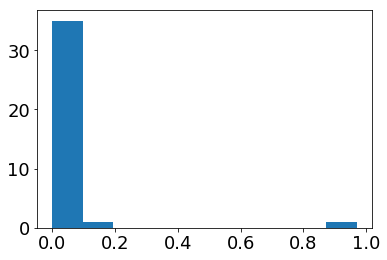

In [224]:
plt.hist(np.abs(overlap_tbl['period_1']-overlap_tbl['period_2'])/overlap_tbl['period_1'])

In [227]:
np.mean(np.abs(overlap_tbl['period_1']-overlap_tbl['period_2'])/overlap_tbl['period_1'])

0.04181875109839993

In [236]:
overlap_tbl[2]

<Row index=2>
        ra                 dec              source_id             l_1                b               parallax         parallax_error          pmra             pmra_error            pmdec            pmdec_error     ra_dec_corr ra_parallax_corr ra_pmra_corr ra_pmdec_corr dec_parallax_corr dec_pmra_corr dec_pmdec_corr parallax_pmra_corr parallax_pmdec_corr pmra_pmdec_corr phot_g_n_obs phot_g_mean_mag   bp_rp         proba       Cluster      Object       Icmag    Jmag    Hmag    Kmag    S/N      RV    vsini  logTeff  Nsp    pRV    pvsini       gaia_r          parallax_err    cluster  astrometric_gof_al astrometric_chi2_al astrometric_excess_noise astrometric_excess_noise_sig survey star_id sobject_id ndfclass field_id raj2000 dej2000   jmag    hmag    kmag  vmag_jk  e_jmag  e_hmag  e_kmag  snr_c1  snr_c2  snr_c3  snr_c4 rv_synt e_rv_synt rv_obst e_rv_obst rv_nogr_obst e_rv_nogr_obst chi2_cannon sp_label_distance flag_cannon        teff             e_teff         logg   e_logg   fe_h   e_fe_h   vmic   e_vmic      e_vsini       alpha_fe e_alpha_fe  li_fe  e_li_fe flag_li_fe   c_fe   e_c_fe flag_c_fe   o_fe   e_o_fe flag_o_fe  na_fe  e_na_fe flag_na_fe  mg_fe  e_mg_fe flag_mg_fe  al_fe  e_al_fe flag_al_fe  si_fe  e_si_fe flag_si_fe   k_fe   e_k_fe flag_k_fe  ca_fe  e_ca_fe flag_ca_fe  sc_fe  e_sc_fe flag_sc_fe  ti_fe  e_ti_fe flag_ti_fe   v_fe   e_v_fe flag_v_fe  cr_fe  e_cr_fe flag_cr_fe  mn_fe  e_mn_fe flag_mn_fe  co_fe  e_co_fe flag_co_fe  ni_fe  e_ni_fe flag_ni_fe  cu_fe  e_cu_fe flag_cu_fe  zn_fe  e_zn_fe flag_zn_fe   y_fe   e_y_fe flag_y_fe  ba_fe  e_ba_fe flag_ba_fe  la_fe  e_la_fe flag_la_fe  eu_fe  e_eu_fe flag_eu_fe       period             e_period         e_period_hwhm        e_period_mad         e_period_std     CDIPS classification        l_2       
     float64             float64              int64             float64           float64            float64             float64            float64             float64             float64             float64         float64       float64        float64       float64         float64         float64       float64          float64             float64           float64        int64         float64      float64       float64        str7       str16       float64 float64 float64 float64 float64 float64 float64 float64 int64 float64 float64      float64            float64         str8        float64             float64               float64                    float64             str5   str16    int64      str8    int64   float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64  float64  float64  float64    float64       float64       float64        float64         int64         float64           float64       float64 float64 float64 float64 float64 float64      float64       float64   float64   float64 float64   int64    float64 float64   int64   float64 float64   int64   float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64   float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64   float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64    float64 float64   int64   float64 float64   int64    float64 float64   int64    float64 float64   int64         float64             float64             float64             float64              float64        int64      str1           float64     
------------------ ------------------- ------------------- ----------------- ------------------ ------------------ ------------------- ------------------ -------------------- ------------------ ------------------- ----------- ---------------- ------------ ------------- ----------------- ------------- -------------- ------------------ ------------------- --------------- ------------ --------------- --------- -

In [243]:
combin_tbl.columns

<TableColumns names=('source_id','AV_SFD','AV_SandF','Cluster','E_B_V_SFD','E_B_V_SandF','Hmag','Icmag','Jmag','Kmag','Nsp','Object','RV','S/N','Survey','al_fe','alpha_fe','b','ba_fe','bp_rp','c_fe','ca_fe','chi2_cannon','classification','cluster','co_fe','cr_fe','cu_fe','cutout_size','dec','dec_parallax_corr','dec_pmdec_corr','dec_pmra_corr','dej2000','e_al_fe','e_alpha_fe','e_ba_fe','e_c_fe','e_ca_fe','e_co_fe','e_cr_fe','e_cu_fe','e_eu_fe','e_fe_h','e_hmag','e_jmag','e_k_fe','e_kmag','e_la_fe','e_li_fe','e_logg','e_mg_fe','e_mn_fe','e_na_fe','e_ni_fe','e_o_fe','e_rv_nogr_obst','e_rv_obst','e_rv_synt','e_sc_fe','e_si_fe','e_teff','e_ti_fe','e_v_fe','e_vmic','e_vsini','e_y_fe','e_zn_fe','errmsg','eu_fe','fe_h','field_id','flag_al_fe','flag_ba_fe','flag_c_fe','flag_ca_fe','flag_cannon','flag_co_fe','flag_cr_fe','flag_cu_fe','flag_eu_fe','flag_k_fe','flag_la_fe','flag_li_fe','flag_mg_fe','flag_mn_fe','flag_na_fe','flag_ni_fe','flag_o_fe','flag_sc_fe','flag_si_fe','flag_ti_fe','flag_v_fe

In [242]:
cdips_combin_tbl = joinperiods2[lastcuts]

In [162]:
cdips_combin_tbl.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/combin_tbl_CDIPS.dat',format='ascii')

In [244]:
overlap_tbl = join(cdips_combin_tbl,combin_tbl['source_id','astrometric_gof_al','astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig','exofast_r','r_hi_err','r_lo_err','exofast_teff','teff_hi_err','teff_lo_err'],keys='source_id')
                                               
                                               

In [82]:
#join(overlap_tbl,combin_difftbl,join_type='outer',keys='source_id')
vstk = vstack((overlap_tbl,combin_difftbl))

In [87]:
vstk.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/finalresults_cdips_42.dat',format='ascii')

In [64]:
#vstk.remove_columns(vstk.colnames[-16:-12])

In [79]:
overlap_tbl.rename_columns(['astrometric_gof_al_1','astrometric_chi2_al_1','astrometric_excess_noise_1','astrometric_excess_noise_sig_1'],['astrometric_gof_al','astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig'])





In [78]:
overlap_tbl.remove_columns(overlap_tbl.colnames[-10:-6])

In [48]:
#overlap_tbl.rename_column('astrometric_excess_noise_1','astrometric_excess_noise')

In [52]:
from astropy.table import vstack

In [86]:
#overlap_tbl.remove_row(2)
overlap_tbl = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/overlap_36_finalresults.dat')
#overlap_tbl.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/overlap_36_finalresults.dat',format='ascii',overwrite=True)

In [50]:
overlap_tbl

<Table length=36>
        ra                 dec         ... teff_hi_err teff_lo_err
     float64             float64       ...   float64     float64  
------------------ ------------------- ... ----------- -----------
119.58680314089415 -61.196060838358804 ...       170.0       170.0
119.62662452597256 -61.168576005207235 ...       150.0       150.0
119.65382340795934  -61.07613508250784 ...       160.0       160.0
119.64520129184184  -61.05329746749391 ...       130.0       130.0
119.59901513827423  -61.06229686480379 ...       120.0       120.0
  119.413059374995    -61.035912541367 ...       130.0       130.0
119.49029455268763  -60.89410066215391 ...       140.0       140.0
 118.8322405603062  -61.07213912553202 ...       190.0       190.0
118.77460824476587 -61.074813094956916 ...       140.0       140.0
119.00514621335617   -60.9573786495814 ...       140.0       140.0
               ...                 ... ...         ...         ...
120.35195969813897  -60.58772334905382 ...       140.0       140.0
119.64881348525311  -60.78119984139701 ...       130.0       130.0
119.80580283220925 -60.673281263545306 ...       140.0       140.0
120.13826831046497  -60.52314393476707 ...       160.0       160.0
120.34054291297917 -60.427906385756486 ...       170.0       170.0
120.12958796129628 -60.463474414749854 ...       150.0       150.0
 119.9654316150975  -60.36926980260596 ...       160.0       160.0
119.54578810711885  -60.41739304924166 ...       140.0       140.0
119.13311338979422  -60.46808812731028 ...       120.0       120.0
119.23937225765353 -60.298828098950274 ...       160.0       160.0

In [249]:
join(finalresults,overlap_tbl,keys='source_id')

<Table length=35>
     source_id       AV_SFD AV_SandF ... teff_hi_err_2 teff_lo_err_2
       int64        float64 float64  ...    float64       float64   
------------------- ------- -------- ... ------------- -------------
5290652938419483904  0.6338   0.5451 ...         170.0         170.0
5290653075858442752  0.6503   0.5593 ...         150.0         150.0
5290667472588665600  0.6362   0.5472 ...         160.0         160.0
5290667541308087168  0.6274   0.5396 ...         130.0         130.0
5290667713106775040  0.6342   0.5454 ...         120.0         120.0
5290669873469360512  0.6544   0.5628 ...         130.0         130.0
5290673348103622272  0.6453   0.5549 ...         140.0         140.0
5290710800218328192  0.7932   0.6822 ...         190.0         190.0
5290713652076611200  0.7971   0.6855 ...         140.0         140.0
5290715954179096320  0.7447   0.6405 ...         140.0         140.0
                ...     ...      ... ...           ...           ...
5290777522534884864  0.6158   0.5296 ...         140.0         140.0
5290814807146918016  0.6791    0.584 ...         130.0         130.0
5290817281048004736  0.6488    0.558 ...         140.0         140.0
5290824320493640576  0.6525   0.5612 ...         160.0         160.0
5290826558177392640  0.6134   0.5275 ...         170.0         170.0
5290826936134381440  0.6334   0.5448 ...         150.0         150.0
5290830097230075904  0.6169   0.5306 ...         160.0         160.0
5290838962037067648  0.6016   0.5174 ...         140.0         140.0
5290931561536172416  0.6142   0.5282 ...         120.0         120.0
5291030448862535808  0.5419   0.4661 ...         160.0         160.0

In [169]:
from astropy.table import setdiff

(array([9., 1., 1., 0., 0., 2., 2., 0., 0., 1.]),
 array([4036.45392968, 4403.42484619, 4770.3957627 , 5137.36667921,
        5504.33759572, 5871.30851223, 6238.27942874, 6605.25034525,
        6972.22126177, 7339.19217828, 7706.16309479]),
 <a list of 10 Patch objects>)

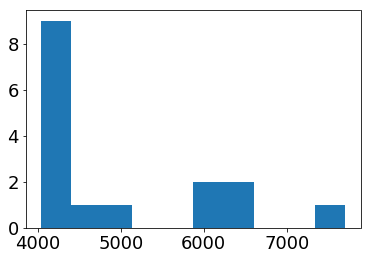

In [211]:
difftbl = setdiff(cdips_combin_tbl,combin_tbl,keys='source_id')
plt.hist(difftbl['teff'])

In [278]:
difftbl

<Table length=16>
        ra                 dec         ... CDIPS classification
     float64             float64       ... int64      str1     
------------------ ------------------- ... ----- --------------
119.69352745414736  -61.09960558716263 ...     1              C
119.62997956802782  -61.08969061592808 ...     1              C
119.33371932380165  -61.12049818566914 ...     1              C
118.96634354343598  -61.22241062296897 ...     1              C
119.25998129356094  -61.03465617585395 ...     1              C
 119.7312581599858  -60.93315783860372 ...     1              C
118.96424957852149   -60.9670225989847 ...     1              C
119.06029229768161 -60.908680837889335 ...     1              C
 119.4210732231115  -60.72733767006693 ...     1              C
118.86533058171912  -60.80378781179854 ...     1              C
 118.5485039558298  -60.79997209857641 ...     1              C
118.93239649193438  -60.63112177512871 ...     1              C
120.06859664295227  -60.77082477379771 ...     1              C
119.87081758061746  -60.66154951640272 ...     1              C
119.55207431338823   -60.6349200237026 ...     1              C
118.71507656825491 -60.425062330986215 ...     1              C

In [ ]:
setdiff(cdips_combin_tbl,combin_tbl,keys='source_id')

In [7]:
difftbl = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/setdiffs_14_trimmed.dat')
#.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/setdiffs_14_trimmed.dat',format='ascii')
#REMOVED 2 points from difftbl manually

In [210]:
join(cdips_combin_tbl,combin_tbl['source_id','l'],keys='source_id')#.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/join_37.dat',format='ascii')

<Table length=37>
        ra                 dec         ... classification        l_2        
     float64             float64       ...      str1           float64      
------------------ ------------------- ... -------------- ------------------
119.58680314089415 -61.196060838358804 ...              C 274.24034263679124
119.62662452597256 -61.168576005207235 ...              C 274.22422386291186
119.25664864134404 -61.052291499124074 ...              C  274.0311456752617
119.65382340795934  -61.07613508250784 ...              C 274.14532920587294
119.64520129184184  -61.05329746749391 ...              C 274.12227196413744
119.59901513827423  -61.06229686480379 ...              C 274.11980199367423
  119.413059374995    -61.035912541367 ...              C  274.0522222586128
119.49029455268763  -60.89410066215391 ...              C 273.93933422408287
 118.8322405603062  -61.07213912553202 ...              C 273.95206286504225
118.77460824476587 -61.074813094956916 ...              C  273.9413968800656
               ...                 ... ...            ...                ...
120.35195969813897  -60.58772334905382 ...              C  273.8628822281947
119.64881348525311  -60.78119984139701 ...              C 273.87252395111074
119.80580283220925 -60.673281263545306 ...              C  273.8104414359998
120.13826831046497  -60.52314393476707 ...              C 273.75231544107305
120.34054291297917 -60.427906385756486 ...              C 273.71418910399666
120.12958796129628 -60.463474414749854 ...              C 273.69563098543335
 119.9654316150975  -60.36926980260596 ...              C  273.5698048938381
119.54578810711885  -60.41739304924166 ...              C 273.51338327597443
119.13311338979422  -60.46808812731028 ...              C 273.46237443018174
119.23937225765353 -60.298828098950274 ...              C 273.33131325218216

In [201]:
join(cdips_combin_tbl,combin_tbl,keys='source_id')['source_id'].data.tofile('/Users/bhealy/Downloads/test.txt',sep='\n')

In [269]:
cdips_combin_tbl

<Table length=53>
        ra                 dec         ... CDIPS classification
     float64             float64       ... int64      str1     
------------------ ------------------- ... ----- --------------
119.58680314089415 -61.196060838358804 ...     1              C
119.62662452597256 -61.168576005207235 ...     1              C
119.69352745414736  -61.09960558716263 ...     1              C
119.62997956802782  -61.08969061592808 ...     1              C
119.33371932380165  -61.12049818566914 ...     1              C
118.96634354343598  -61.22241062296897 ...     1              C
119.25664864134404 -61.052291499124074 ...     1              C
119.25998129356094  -61.03465617585395 ...     1              C
119.65382340795934  -61.07613508250784 ...     1              C
119.64520129184184  -61.05329746749391 ...     1              C
               ...                 ... ...   ...            ...
119.80580283220925 -60.673281263545306 ...     1              C
119.55207431338823   -60.6349200237026 ...     1              C
120.13826831046497  -60.52314393476707 ...     1              C
120.34054291297917 -60.427906385756486 ...     1              C
120.12958796129628 -60.463474414749854 ...     1              C
 119.9654316150975  -60.36926980260596 ...     1              C
119.54578810711885  -60.41739304924166 ...     1              C
119.13311338979422  -60.46808812731028 ...     1              C
118.71507656825491 -60.425062330986215 ...     1              C
119.23937225765353 -60.298828098950274 ...     1              C

In [226]:
combin_tbl.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/combin_tbl_ultimate.dat',format='ascii',overwrite=True)

In [497]:
combin_tbl['e_vsini']

<Column name='e_vsini' dtype='float64' length=49>
               1.09
                9.0
                0.8
 0.7050000000000001
              0.408
              0.396
0.47200000000000003
              0.723
              0.948
              0.976
              0.444
 1.4300000000000002
                ...
              0.568
 0.5730000000000001
              2.345
 0.7050000000000001
 1.8800000000000001
 0.6400000000000001
 3.4000000000000004
              0.585
               1.26
              1.395
 0.9994989758678856
 0.8499990167459184

Text(0,0.5,'logL [Lsun]')

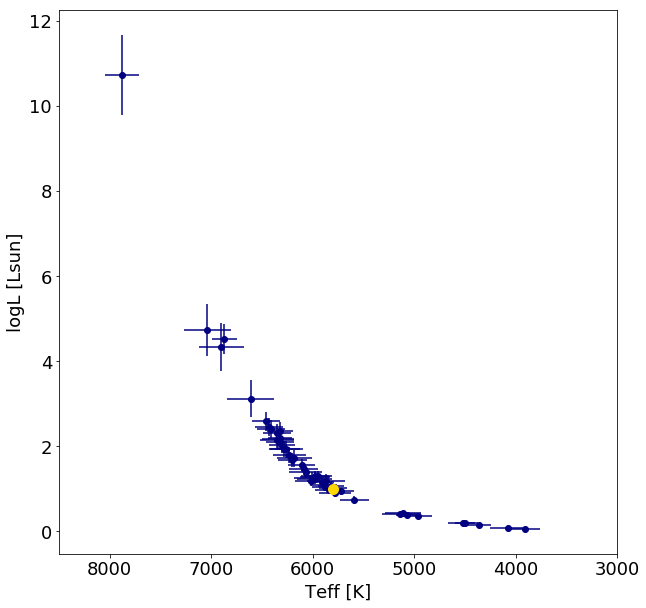

In [227]:
plt.figure(figsize=(10,10))
plt.scatter(combin_tbl['exofast_teff'],combin_tbl['lum'],color='navy')
plt.errorbar(combin_tbl['exofast_teff'],combin_tbl['lum'],xerr=combin_tbl['teff_hi_err'],yerr=combin_tbl['lumhierr'],linestyle='none',color='navy')
plt.scatter(5800,1,color='gold',s=100,zorder=3)
#plt.plot(centers,meds,linewidth=2,color='red')

#plt.xlim(12500,3000)
plt.xlim(8500,3000)
#plt.ylim(-2,2)
#plt.ylim(0,10)
plt.xlabel('Teff [K]')
plt.ylabel('logL [Lsun]')

Text(0,0.5,'Radius [Rsun]')

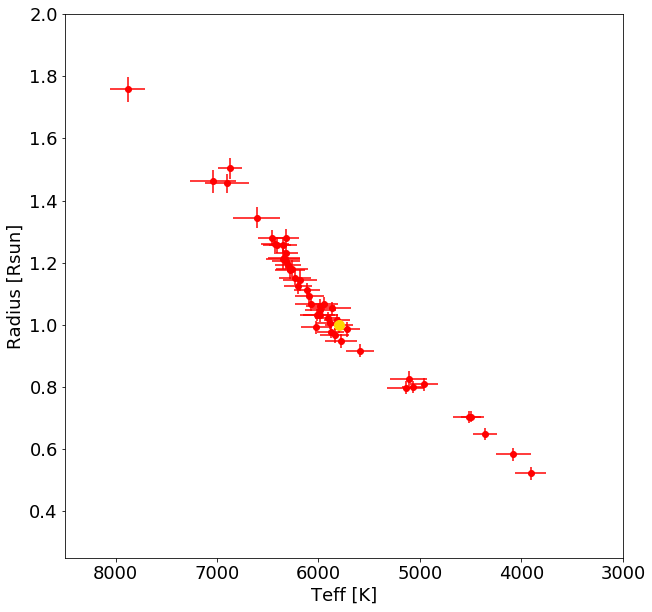

In [228]:
plt.figure(figsize=(10,10))
plt.scatter(combin_tbl['exofast_teff'],combin_tbl['exofast_r'],color='red')
plt.errorbar(combin_tbl['exofast_teff'],combin_tbl['exofast_r'],yerr=combin_tbl['r_hi_err'],xerr=combin_tbl['teff_hi_err'],linestyle='none',color='red')
plt.scatter(5800,1,color='gold',s=100,zorder=3)
plt.xlim(8500,3000)
plt.ylim(0.25,2)
plt.xlabel('Teff [K]')
plt.ylabel('Radius [Rsun]')

In [250]:
teff_lim = (combin_tbl['exofast_teff'] > 4000) & (combin_tbl['exofast_r'] > 0.6)  #4000 or 5200

In [251]:
Per = unumpy.uarray(combin_tbl[teff_lim]['period'],combin_tbl[teff_lim]['period_unc']) * 86400
Rad = unumpy.uarray(combin_tbl[teff_lim]['exofast_r'],combin_tbl[teff_lim]['r_hi_err']) * 7e8 #* .97
Vsini = unumpy.uarray(combin_tbl[teff_lim]['vsini'], combin_tbl[teff_lim]['e_vsini']) * 1e3

In [252]:
len(Per)

46

In [253]:

incnames = []
# Calculate sini and its uncertainty
#Sini = (Per*Vsini)/(2*np.pi*Rad)
Sini = (Per*Vsini)/(2*np.pi*Rad)
sini = np.zeros(len(Sini))
sini_fracerr = np.copy(sini)
for k in range(len(Sini)):
    incnames += [combin_tbl[teff_lim]['source_id'][k]]
    Sinik = Sini[k]
    nomval = Sinik.nominal_value
    print(nomval)
    std_dev = Sinik.std_dev
    print(std_dev)
    sini[k] = nomval
    sini_fracerr[k] = std_dev/nomval

# Calculate inclination from all sini values <= 1
Inclination = unumpy.arcsin(Sini[Sini<=1])

# Create separate arrays of inclination and uncertainty
fracerr = np.zeros(len(Inclination))
inc = np.copy(fracerr)
for j in range(len(Inclination)):
    Ij = Inclination[j]
    nomval = Ij.nominal_value
    std_dev = Ij.std_dev

    inc[j] = nomval
    fracerr[j] = std_dev/nomval
incnames = np.array(incnames)

1.0589627744730659
0.05758473784706773
0.9930104333687751
0.12245793268524993
0.6488732528551063
0.04583047883135232
0.8930843403751636
0.0492924229305805
0.4433661639400143
0.03912194044711508
0.6228626097865415
0.04173155507834106
0.7470102632186114
0.03644969171711072
0.9740444787250931
0.036796122769177896
1.003619496973396
0.07757798472425856
0.8430863649342073
0.07848696367575232
0.7841451956420878
0.04455313986640667
0.18841078838222802
0.01239062337820396
1.0621076598788717
0.05681364846267281
0.719889529843012
0.04933000673572909
0.7460096074291308
0.041288352085524394
0.9848837161770853
0.03929038527919246
0.5291303413023117
0.03159959666454921
0.8531893891435972
0.05249340085195059
0.8177283518522378
0.05060707199111209
0.8488241975753608
0.05603888518001745
0.8252270351861086
0.04451924226420142
0.5584626934713073
0.025573224029733516
0.4028896968142881
0.0186146471583544
0.8474153996825811
0.046918623564154806
0.7569815181250944
0.0431325749562733
0.5472040689171437
0.0383

In [254]:
for i in range(len(combin_tbl['period_unc'])):
    if combin_tbl['period_unc'][i] == 0.05 * combin_tbl['period'][i]:
        print(True)
        #combin_tbl['period_unc'][i] = 0.01 * combin_tbl['period'][i]

In [255]:
len(sini)

46

In [256]:
reasonable = (sini < 1.5) #& (sini >= 0.4)
unreasonable = ~reasonable
np.sum(unreasonable), len(sini)

(0, 46)

In [257]:
sini = sini[reasonable]
sini_fracerr = sini_fracerr[reasonable]
incnames = incnames[reasonable]

In [258]:
np.mean(combin_tbl[teff_lim][reasonable]['period_unc']/combin_tbl[teff_lim][reasonable]['period'])

0.01935924950691576

In [259]:
np.mean(combin_tbl[teff_lim][reasonable]['r_hi_err']/combin_tbl[teff_lim][reasonable]['exofast_r'])

0.022639469233020883

(0.5, 1.75)

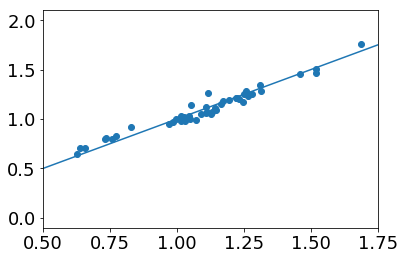

In [260]:
plt.scatter(combin_tbl[teff_lim][reasonable]['gaia_r'],combin_tbl[teff_lim][reasonable]['exofast_r'])
plt.plot([0,2],[0,2])
plt.xlim(.5,1.75)

In [261]:
np.mean(combin_tbl[teff_lim][reasonable]['e_vsini']/combin_tbl[teff_lim][reasonable]['vsini'])

0.048445877569277686

In [262]:
np.nanmean(combin_tbl[teff_lim][reasonable]['teff_hi_err']/combin_tbl[teff_lim][reasonable]['exofast_teff'])

0.025113049434198318

In [ ]:
#'/Users/bhealy/Documents/PhD_Thesis/NGC_2516/final_names_list.dat'

In [595]:
combin_tbl[teff_lim][reasonable]['source_id'].tofile('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/final_names_list.dat',sep='\n')

In [263]:
siniTbl = Table(data=[incnames,sini,sini_fracerr],names=['source_id','sini','sini_fracerr'])
siniTbl

<Table length=46>
     source_id              sini            sini_fracerr    
       int64              float64             float64       
------------------- ------------------- --------------------
5290652938419483904  1.0589627744730659  0.05437843447870166
5290653075858442752  0.9930104333687751  0.12331988524009055
5290655549759622144  0.6488732528551063  0.07063086454818979
5290664861248309760  0.8930843403751636   0.0551934690847607
5290667472588665600  0.4433661639400143  0.08823844404240132
5290667541308087168  0.6228626097865415  0.06699961503973195
5290667713106775040  0.7470102632186114  0.04879409763402912
5290669873469360512  0.9740444787250931   0.0377766350232174
5290673348103622272   1.003619496973396  0.07729820410843911
5290710800218328192  0.8430863649342073  0.09309480848012205
                ...                 ...                  ...
5290823568880135296  0.8654393403853942  0.04613414863438615
5290824320493640576   1.017884436232279  0.05511775749503779
5290826558177392640  0.5369852022025569   0.0659018683330901
5290826936134381440  1.0491785704177627  0.05481983008791418
5290830097230075904 0.38353067955702963  0.06528291157053544
5290838962037067648  0.8613752034952584 0.053505250129152936
5290931561536172416     0.4675203360234  0.03930443311566016
5291030448862535808  0.9464393977092692  0.05456675742057096
5291032132489758208  0.7354161893176953  0.03756258341956303
5291032613526130048  0.1546600385467842  0.05035215131314944

In [264]:
siniTbl.sort(keys='sini')

In [265]:
siniTbl

<Table length=46>
     source_id              sini            sini_fracerr    
       int64              float64             float64       
------------------- ------------------- --------------------
5291032613526130048  0.1546600385467842  0.05035215131314944
5290715507502414592 0.18841078838222802  0.06576387416344315
5290830097230075904 0.38353067955702963  0.06528291157053544
5290738356723303936  0.4028896968142881 0.046202837415658254
5290667472588665600  0.4433661639400143  0.08823844404240132
5290931561536172416     0.4675203360234  0.03930443311566016
5290723032285137024  0.5291303413023117 0.059719872776101475
5290826558177392640  0.5369852022025569   0.0659018683330901
5290754643245585792  0.5472040689171437  0.07011054867567784
5290737669533445248  0.5584626934713073  0.04579217972605258
                ...                 ...                  ...
5290721142499618816  0.9848837161770853 0.039893425623586935
5290653075858442752  0.9930104333687751  0.12331988524009055
5290673348103622272   1.003619496973396  0.07729820410843911
5290824320493640576   1.017884436232279  0.05511775749503779
5290758933911651584  1.0318892225970333 0.058424135378735094
5290826936134381440  1.0491785704177627  0.05481983008791418
5290814807146918016  1.0550112686962878  0.03990798996868303
5290770998480701184  1.0585493956093899  0.07393237695033213
5290652938419483904  1.0589627744730659  0.05437843447870166
5290715954179096320  1.0621076598788717 0.053491421452653995

In [266]:
finalresultstbl_47 = join(combin_tbl,siniTbl)

In [267]:
finalresultstbl_47

<Table length=46>
     source_id       AV_SFD ...         sini            sini_fracerr    
       int64        float64 ...       float64             float64       
------------------- ------- ... ------------------- --------------------
5290652938419483904  0.6338 ...  1.0589627744730659  0.05437843447870166
5290653075858442752  0.6503 ...  0.9930104333687751  0.12331988524009055
5290655549759622144  0.6359 ...  0.6488732528551063  0.07063086454818979
5290664861248309760  0.6484 ...  0.8930843403751636   0.0551934690847607
5290667472588665600  0.6362 ...  0.4433661639400143  0.08823844404240132
5290667541308087168  0.6274 ...  0.6228626097865415  0.06699961503973195
5290667713106775040  0.6342 ...  0.7470102632186114  0.04879409763402912
5290669873469360512  0.6544 ...  0.9740444787250931   0.0377766350232174
5290673348103622272  0.6453 ...   1.003619496973396  0.07729820410843911
5290710800218328192  0.7932 ...  0.8430863649342073  0.09309480848012205
                ...     ... ...                 ...                  ...
5290823568880135296  0.6462 ...  0.8654393403853942  0.04613414863438615
5290824320493640576  0.6525 ...   1.017884436232279  0.05511775749503779
5290826558177392640  0.6134 ...  0.5369852022025569   0.0659018683330901
5290826936134381440  0.6334 ...  1.0491785704177627  0.05481983008791418
5290830097230075904  0.6169 ... 0.38353067955702963  0.06528291157053544
5290838962037067648  0.6016 ...  0.8613752034952584 0.053505250129152936
5290931561536172416  0.6142 ...     0.4675203360234  0.03930443311566016
5291030448862535808  0.5419 ...  0.9464393977092692  0.05456675742057096
5291032132489758208  0.5223 ...  0.7354161893176953  0.03756258341956303
5291032613526130048  0.5443 ...  0.1546600385467842  0.05035215131314944

In [268]:
finalresultstbl_47.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/ngc2516finalresultstbl46_ultimate.dat',format='ascii')

In [269]:
incemp.x

NameError: name 'incemp' is not defined

In [270]:
incemp = emp.ECDF(sini)


In [271]:
siniTbl['sini']

<Column name='sini' dtype='float64' length=46>
 0.1546600385467842
0.18841078838222802
0.38353067955702963
 0.4028896968142881
 0.4433661639400143
    0.4675203360234
 0.5291303413023117
 0.5369852022025569
 0.5472040689171437
 0.5584626934713073
 0.6228626097865415
 0.6488732528551063
                ...
 0.9689658818189577
 0.9740444787250931
 0.9848837161770853
 0.9930104333687751
  1.003619496973396
  1.017884436232279
 1.0318892225970333
 1.0491785704177627
 1.0550112686962878
 1.0585493956093899
 1.0589627744730659
 1.0621076598788717

In [573]:
incemp.x

array([0.4034416 , 0.4034416 , 0.44336616, 0.46752034, 0.52912237,
       0.52994816, 0.54720407, 0.55677889, 0.62410461, 0.64673704,
       0.67566403, 0.67630375, 0.7219405 , 0.7337352 , 0.73744353,
       0.74670943, 0.74701026, 0.75771503, 0.8162759 , 0.82839186,
       0.84629812, 0.84635613, 0.84970381, 0.85318939, 0.86205938,
       0.86541553, 0.87263136, 0.89004324, 0.89484759, 0.90376742,
       0.9464394 , 0.95166881, 0.95578531, 0.96745423, 0.97317011,
       0.98196338, 0.98610742, 0.99442498, 1.01788444, 1.02691626,
       1.04828641, 1.05394128, 1.05589971, 1.05691251, 1.06509951])

(-0.05, 1.05)

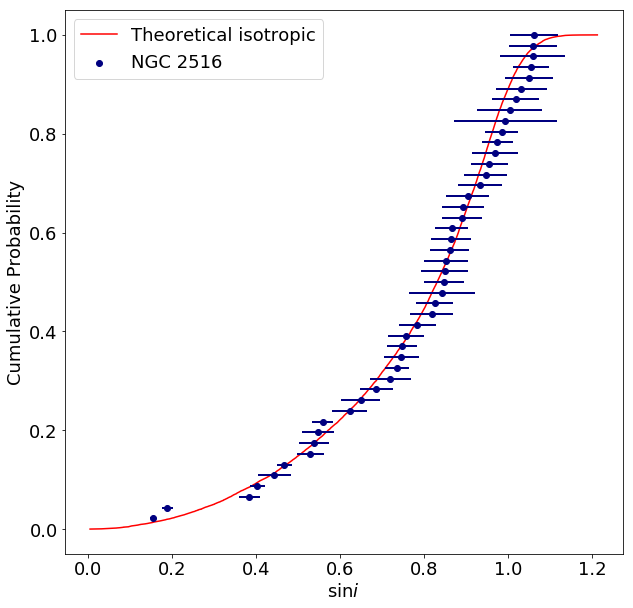

In [276]:
incemp = emp.ECDF(sini)

sini_n_obs = obs_sini_distrib(15,85,cutoff=0.,deltap = 0.019002070603299424, deltar = 0.02238870251272698, deltav = 0.04853328372952448)
#sini_n_obs = obs_sini_distrib(80,60,cutoff=0.4,deltap = 0.019002070603299424, deltar = 0.02238870251272698, deltav = 0.04853328372952448)

#sini_n_obs = obs_sini_distrib_specific(0,90,cutoff=0.3,deltap = 0.01876859799253639, deltar = 0.023341459762106866, deltav = 0.04973082377961253)

#sini_n_obs = obs_sini_distrib(25,75,cutoff=0.,deltap = 0.02, deltar = 0.035, deltav = 0.05)
#sini_n_obs = obs_sini_distrib(30,75,cutoff=0.,deltap = 0.02, deltar = 0.037, deltav = 0.052)

mcincemp = emp.ECDF(sini_n_obs)

fig1=plt.figure(figsize=(10,10))
#incemp = emp.ECDF(subNART['sini'])

#plt.scatter(incemp.x[1:],obs_sini_distrib_specific(0,90))

incemp.x[0] = 0.4#np.min(sini)

plt.plot(mcincemp.x,mcincemp.y,color='red',label='Theoretical isotropic',zorder=0)
plt.scatter(incemp.x[1:],incemp.y[1:],color='navy',label='NGC 2516')
plt.errorbar(incemp.x[1:],incemp.y[1:],xerr=siniTbl['sini_fracerr']*siniTbl['sini'],linestyle='none',linewidth=2,color='navy')

#plt.scatter(incemp.x[1:],np.interp(incemp.x[1:],mcincemp.x,mcincemp.y))

#plt.errorbar(incemp.x[0:],incemp.y[0:],xerr=sini_fracerr*sini,linestyle='none',linewidth=2,color='navy')

plt.legend()
plt.xlabel('$\sin i$')
plt.ylabel('Cumulative Probability')

plt.ylim(-0.05,1.05)
#plt.xlim(0.3,1.15)

In [353]:
from scipy.optimize import curve_fit

In [967]:
def true_sini_distrib_specific(alpha,lamda,n=50000):
    alpha *= np.pi/180
    lamda *= np.pi/180
    
    Rn = np.random.random(n)
    Rnp = np.random.random(n)
    
    theta_n = np.arccos(1 - Rn*(1-np.cos(lamda)))
    Ptheta = (1 - np.cos(theta_n))/(1 - np.cos(lamda))
    phi_n = 2*np.pi*Rnp
    
    cosi_n = np.sin(alpha)*np.sin(theta_n)*np.cos(phi_n) + np.cos(alpha)*np.cos(theta_n)
    sini_n = np.sin(np.arccos(np.abs(cosi_n)))
    
    sini_n = np.sort(sini_n)
    
    return sini_n

def obs_sini_distrib_specific(xdatapoints,alpha,lamda,deltap=0.019002070603299424,deltav=0.04853328372952448,deltar=0.02238870251272698,cutoff=0.4,n=50000):
    sini_n_true = true_sini_distrib_specific(alpha,lamda)
    
    U1 = np.random.normal(size=n)
    U2 = np.random.normal(size=n)
    
    deltapv = np.sqrt(deltap**2+deltav**2)
    
    sini_n_obs = sini_n_true * ((1 + deltapv*U1)/(1 + deltar*U2))
    
    cutoffmask = np.zeros(len(sini_n_obs),dtype=bool)
    for i in range(len(sini_n_obs)):
        if sini_n_obs[i] > cutoff:
            cutoffmask[i] = True
    
    sini_n_obs = sini_n_obs[cutoffmask]
    if len(sini_n_obs) != 0:
        mcincemp = emp.ECDF(sini_n_obs)
        mcincempx1 = mcincemp.x[1:]
        mcincempy1 = mcincemp.y[1:]
    else:
        mcincempy1 = np.zeros(len(xdatapoints)) + 1
        mcincempx1 = xdatapoints
        
    
    #sini_n_obs = np.interp(xdatapoints,mcincemp.x[1:],mcincemp.y[1:])
    sini_n_obs = np.interp(xdatapoints,mcincempx1,mcincempy1)

    
    return sini_n_obs

def obs_sini_distrib_onefunc(xdatapoints,alpha,lamda,deltap=0.019002070603299424,deltav=0.04853328372952448,deltar=0.02238870251272698,cutoff=0.4,n=50000):
    alpha *= np.pi/180
    lamda *= np.pi/180
    
    Rn = np.random.random(n)
    Rnp = np.random.random(n)
    
    theta_n = np.arccos(1 - Rn*(1-np.cos(lamda)))
    Ptheta = (1 - np.cos(theta_n))/(1 - np.cos(lamda))
    phi_n = 2*np.pi*Rnp
    
    cosi_n = np.sin(alpha)*np.sin(theta_n)*np.cos(phi_n) + np.cos(alpha)*np.cos(theta_n)
    sini_n = np.sin(np.arccos(np.abs(cosi_n)))
    
    sini_n = np.sort(sini_n)
    
    sini_n_true = sini_n #true_sini_distrib_specific(alpha,lamda)
    
    U1 = np.random.normal(size=n)
    U2 = np.random.normal(size=n)
    
    deltapv = np.sqrt(deltap**2+deltav**2)
    
    sini_n_obs = sini_n_true * ((1 + deltapv*U1)/(1 + deltar*U2))
    
    cutoffmask = np.zeros(len(sini_n_obs),dtype=bool)
    for i in range(len(sini_n_obs)):
        if sini_n_obs[i] > cutoff:
            cutoffmask[i] = True
    
    sini_n_obs = sini_n_obs[cutoffmask]
    mcincemp = emp.ECDF(sini_n_obs)
    
    sini_n_obs = np.interp(xdatapoints,mcincemp.x[1:],mcincemp.y[1:])
    
    return sini_n_obs

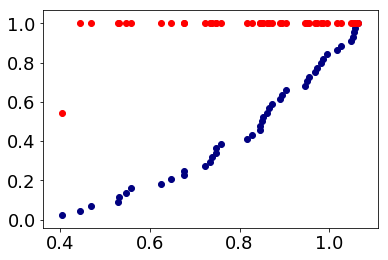

In [977]:
plt.scatter(incemp.x[1:],incemp.y[1:],color='navy')
#plt.scatter(incemp.x[1:],obs_sini_distrib_specific(incemp.x[1:],40,20),color='red')
#plt.scatter(incemp.x[1:],obs_sini_distrib_specific(incemp.x[1:],0,90),color='red')
#plt.scatter(incemp.x[1:],obs_sini_distrib_specific(incemp.x[1:],41,65),color='red')
#plt.scatter(incemp.x[1:],obs_sini_distrib_specific(incemp.x[1:],80,10),color='red')
plt.scatter(incemp.x[1:],obs_sini_distrib_specific(incemp.x[1:],10,10),color='red')




In [984]:
import sys
eps = sys.float_info.epsilon
eps=0

alpha_vec = np.arange(0+eps,91-eps,1)
lamda_vec = np.arange(0+eps,91-eps,1)
chi2 = np.zeros((len(alpha_vec),len(lamda_vec)))

for i in range(len(alpha_vec)):
    for j in range(len(lamda_vec)):
        #print(alpha_vec[i],lamda_vec[j])
        #try:
        chi2[j,i] = np.sum((incempy1 - obs_sini_distrib_specific(incempx1,alpha_vec[i],lamda_vec[j]))**2 / obs_sini_distrib_specific(incempx1,alpha_vec[i],lamda_vec[j]))
        #except ZeroDivisionError:
        #    chi2[j,i] = np.ma.masked
            
            
            
            

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [804]:
np.sum((incempy1 - obs_sini_distrib_specific(incempx1,0,90))**2 / obs_sini_distrib_specific(incempx1,0,90))
                                                                                                                 
                                                                                                                 
                                                                                                                 
                                                                                                                 
                                                                                                                 

0.7073590352372999

In [838]:
np.sum((incempy1 - obs_sini_distrib_specific(incempx1,40,20))**2 / obs_sini_distrib_specific(incempx1,40,20))

4.764177134007913

In [816]:
chi2[1,-2]

0.5896712558531454

In [983]:
alpha_vec

array([2.22044605e-16, 1.00000000e+00, 2.00000000e+00, 3.00000000e+00,
       4.00000000e+00, 5.00000000e+00, 6.00000000e+00, 7.00000000e+00,
       8.00000000e+00, 9.00000000e+00, 1.00000000e+01, 1.10000000e+01,
       1.20000000e+01, 1.30000000e+01, 1.40000000e+01, 1.50000000e+01,
       1.60000000e+01, 1.70000000e+01, 1.80000000e+01, 1.90000000e+01,
       2.00000000e+01, 2.10000000e+01, 2.20000000e+01, 2.30000000e+01,
       2.40000000e+01, 2.50000000e+01, 2.60000000e+01, 2.70000000e+01,
       2.80000000e+01, 2.90000000e+01, 3.00000000e+01, 3.10000000e+01,
       3.20000000e+01, 3.30000000e+01, 3.40000000e+01, 3.50000000e+01,
       3.60000000e+01, 3.70000000e+01, 3.80000000e+01, 3.90000000e+01,
       4.00000000e+01, 4.10000000e+01, 4.20000000e+01, 4.30000000e+01,
       4.40000000e+01, 4.50000000e+01, 4.60000000e+01, 4.70000000e+01,
       4.80000000e+01, 4.90000000e+01, 5.00000000e+01, 5.10000000e+01,
       5.20000000e+01, 5.30000000e+01, 5.40000000e+01, 5.50000000e+01,
      

In [982]:
lamda_vec

array([2.22044605e-16, 1.00000000e+00, 2.00000000e+00, 3.00000000e+00,
       4.00000000e+00, 5.00000000e+00, 6.00000000e+00, 7.00000000e+00,
       8.00000000e+00, 9.00000000e+00, 1.00000000e+01, 1.10000000e+01,
       1.20000000e+01, 1.30000000e+01, 1.40000000e+01, 1.50000000e+01,
       1.60000000e+01, 1.70000000e+01, 1.80000000e+01, 1.90000000e+01,
       2.00000000e+01, 2.10000000e+01, 2.20000000e+01, 2.30000000e+01,
       2.40000000e+01, 2.50000000e+01, 2.60000000e+01, 2.70000000e+01,
       2.80000000e+01, 2.90000000e+01, 3.00000000e+01, 3.10000000e+01,
       3.20000000e+01, 3.30000000e+01, 3.40000000e+01, 3.50000000e+01,
       3.60000000e+01, 3.70000000e+01, 3.80000000e+01, 3.90000000e+01,
       4.00000000e+01, 4.10000000e+01, 4.20000000e+01, 4.30000000e+01,
       4.40000000e+01, 4.50000000e+01, 4.60000000e+01, 4.70000000e+01,
       4.80000000e+01, 4.90000000e+01, 5.00000000e+01, 5.10000000e+01,
       5.20000000e+01, 5.30000000e+01, 5.40000000e+01, 5.50000000e+01,
      

In [986]:
np.argwhere(np.exp(-chi2/2) == np.nanmax(np.exp(-chi2/2)))

array([[64, 40]])

In [987]:
alpha_vec[41], lamda_vec[64]

(41, 64)

In [830]:
np.nanmedian(chi2), np.nanstd(chi2)

(3.5162095839268095, 8438.777100149438)

In [845]:
np.nanmin(chi2)

0.18992139161554455

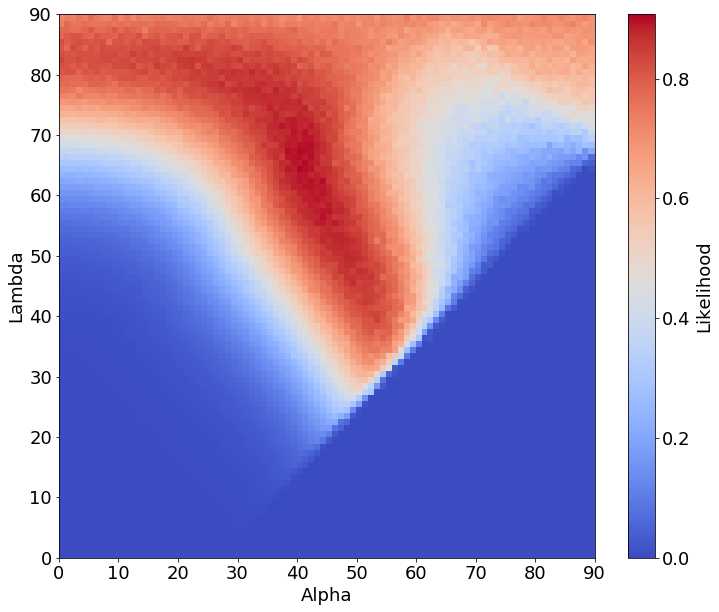

In [985]:
plt.figure(figsize=(12,10))
A, L = np.meshgrid(alpha_vec,lamda_vec)
plt.pcolor(alpha_vec,lamda_vec,np.exp(-chi2/2),cmap='coolwarm')

#plt.pcolor(alpha_vec,lamda_vec,np.log(chi2),cmap='coolwarm_r')
plt.colorbar(label='Likelihood')
plt.xlabel('Alpha')
plt.ylabel('Lambda')
#plt.xlim(0,20)
#plt.ylim(70,90)
plt.show()

(array([ 23.,  43.,  53.,  71., 118., 146., 187., 196., 164., 105.]),
 array([0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]),
 <a list of 10 Patch objects>)

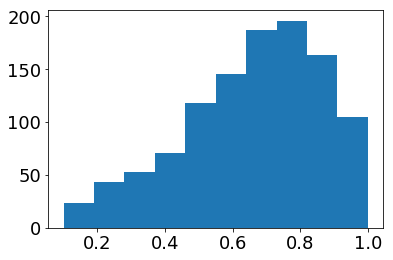

In [936]:
plt.hist(allmems['proba'])

(array([8., 9., 9., 5., 6., 2., 0., 0., 2., 3.]),
 array([ 5.1 , 12.09, 19.08, 26.07, 33.06, 40.05, 47.04, 54.03, 61.02,
        68.01, 75.  ]),
 <a list of 10 Patch objects>)

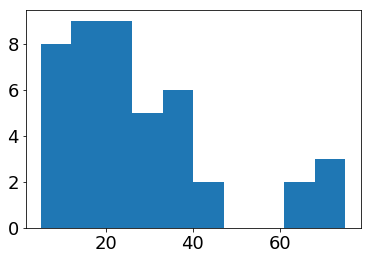

In [905]:
plt.hist(finalresultstbl['vsini'])

(array([3., 6., 5., 4., 4., 8., 2., 8., 2., 2.]),
 array([0.39047597, 0.77331101, 1.15614605, 1.5389811 , 1.92181614,
        2.30465118, 2.68748622, 3.07032126, 3.4531563 , 3.83599134,
        4.21882639]),
 <a list of 10 Patch objects>)

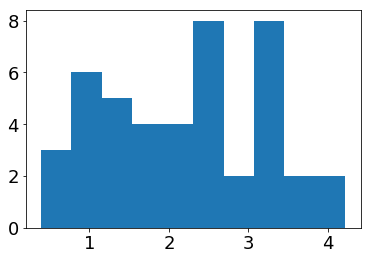

In [906]:
plt.hist(finalresultstbl['period'])

(array([ 3.,  3.,  2.,  5., 11.,  6.,  6.,  4.,  1.,  3.]),
 array([0.647 , 0.7327, 0.8184, 0.9041, 0.9898, 1.0755, 1.1612, 1.2469,
        1.3326, 1.4183, 1.504 ]),
 <a list of 10 Patch objects>)

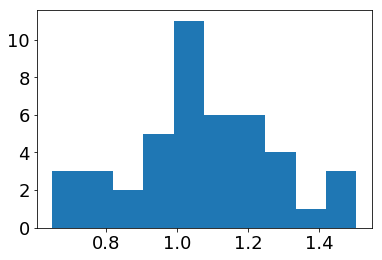

In [907]:
plt.hist(finalresultstbl['exofast_r'])

(array([15.,  9.,  3.,  3.,  5.,  2.,  0.,  2.,  3.,  2.]),
 array([11.50290756, 18.78740405, 26.07190053, 33.35639702, 40.6408935 ,
        47.92538999, 55.20988647, 62.49438296, 69.77887944, 77.06337593,
        84.34787241]),
 <a list of 10 Patch objects>)

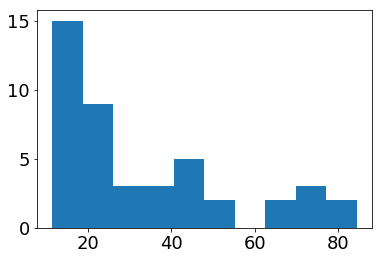

In [914]:
vcalc = 2*np.pi*finalresultstbl['exofast_r']*7e8/(finalresultstbl['period']*24*3600)/1e3
plt.hist(vcalc)

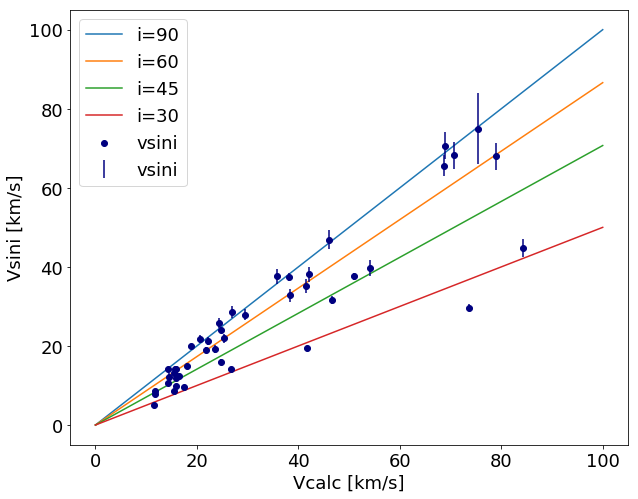

In [935]:
plt.figure(figsize=(10,8))

plt.xlabel('Vcalc [km/s]')
plt.ylabel('Vsini [km/s]')
plt.plot([0,100],[0,100],label='i=90')
plt.plot([0,100],[0,86.6],label='i=60')
plt.plot([0,100],[0,70.7],label='i=45')
plt.plot([0,100],[0,50],label='i=30')
plt.scatter(vcalc,finalresultstbl['vsini'],color='navy',zorder=5)
plt.errorbar(vcalc,finalresultstbl['vsini'],yerr=finalresultstbl['e_vsini'],color='navy',linestyle='none',zorder=5)
plt.legend()

In [831]:
chi2copy = chi2.copy()

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Warning: converting a masked element to nan.
  """


Text(0,0.5,'Lambda')

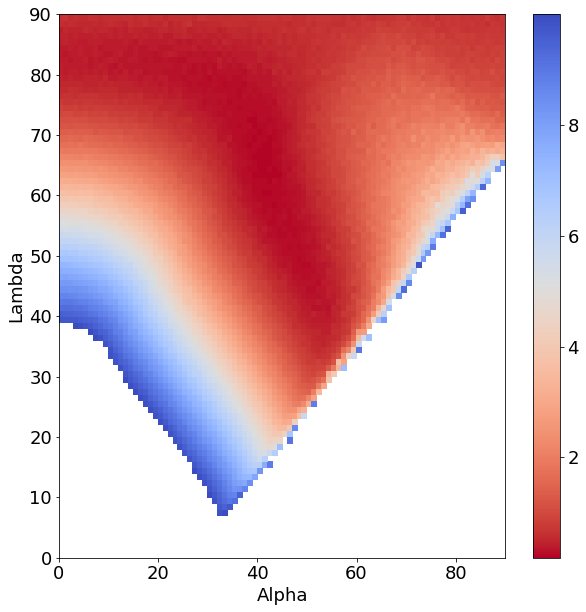

In [843]:
chi2copy = chi2.copy()
for i in range(len(chi2copy)):
    for j in range(len(chi2copy[0])):
        if chi2copy[i,j] >= 10:
            chi2copy[i,j] = np.ma.masked

plt.figure(figsize=(10,10))
A, L = np.meshgrid(alpha_vec,lamda_vec)
plt.pcolor(alpha_vec,lamda_vec,chi2copy,cmap='coolwarm_r')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Lambda')
#plt.xlim(0,20)
#plt.ylim(70,90)

In [730]:
np.sum((siniTbl['sini'] - obs_sini_distrib_specific(incemp.x[1:],40,20))**2/(siniTbl['sini_fracerr']*siniTbl['sini'])**2)





1575.0362504941465

In [772]:
np.sum((incempy1 - obs_sini_distrib_specific(incempx1,40,20))**2 / obs_sini_distrib_specific(incempx1,40,20))

4.809801616372829

In [758]:
obs_sini_distrib_specific(incemp.x[1:],0,90)

array([0.00169962, 0.02295402, 0.03741585, 0.0762469 , 0.07677539,
       0.08928791, 0.09624364, 0.14994526, 0.17062   , 0.19958976,
       0.20025293, 0.24971989, 0.2645112 , 0.26919467, 0.28158784,
       0.28190172, 0.29699215, 0.38436417, 0.40534529, 0.43634992,
       0.43644516, 0.44387083, 0.4507898 , 0.46843461, 0.47542402,
       0.49136321, 0.53086015, 0.54264544, 0.56680067, 0.69388728,
       0.71001516, 0.72288988, 0.75958761, 0.77786699, 0.80356417,
       0.81604232, 0.83953646, 0.89708265, 0.91631164, 0.9507271 ,
       0.95831198, 0.96047053, 0.96169384, 0.96997079])

In [669]:
#curve_fit(obs_sini_distrib_specific,incemp.x[1:],incemp.y[1:],p0=[0.5,89.5],sigma=sini_fracerr*sini,bounds=((0,0),(90,90)),verbose=2,ftol=None,xtol=None)
incempx1 = incemp.x[1:]
incempy1 = incemp.y[1:]


curve_fit(obs_sini_distrib_specific,incempx1,incempy1,p0=[0.5,89.5],bounds=((0,0),(90,90)),verbose=2)




   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5991e-02                                    1.85e+07    
       1              2         2.5034e-02      9.57e-04       1.08e-05       1.27e+06    
       2              3         2.2987e-02      2.05e-03       2.02e-07       1.03e+05    
`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 2.5991e-02, final cost 2.2987e-02, first-order optimality 1.03e+05.


(array([ 0.50000013, 89.49998941]), array([[ 2.98555659e-16, -4.40029246e-14],
        [-4.40029246e-14,  2.22691826e-11]]))

In [667]:
obs_sini_distrib_onefunc(incemp.x[1:],10,80)

array([0.05076415, 0.07420181, 0.09047593, 0.13761969, 0.1379134 ,
       0.15330785, 0.16166328, 0.22811208, 0.25108394, 0.28292369,
       0.28349525, 0.34014   , 0.35701802, 0.36254907, 0.37589287,
       0.37633992, 0.39091603, 0.48965602, 0.51400813, 0.55069577,
       0.55078695, 0.55863458, 0.56579765, 0.58532221, 0.59295858,
       0.60879261, 0.65298783, 0.66503088, 0.69008051, 0.80548602,
       0.81841064, 0.82873398, 0.85782116, 0.87114854, 0.88904433,
       0.89609651, 0.91240111, 0.94771228, 0.95925762, 0.9769196 ,
       0.98071669, 0.98178736, 0.98237912, 0.98751887])

In [658]:
incemp.y.dtype

dtype('float64')

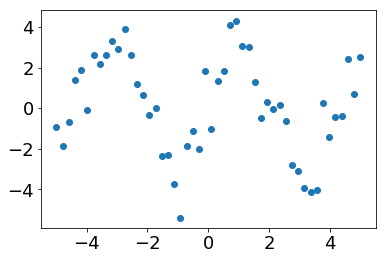

In [642]:
np.random.seed(0)

x_data = np.linspace(-5, 5, num=50)
y_data = 2.9 * np.sin(1.5 * x_data) + np.random.normal(size=50)

# And plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data)

In [644]:
from scipy import optimize

def test_func(x, a, b):
    return a * np.sin(b * x)

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[2, 2])

print(params)

[3.05931973 1.45754553]


In [645]:
params_covariance

array([[ 0.05345449, -0.00044557],
       [-0.00044557,  0.00055201]])

(18.5, 5.5)

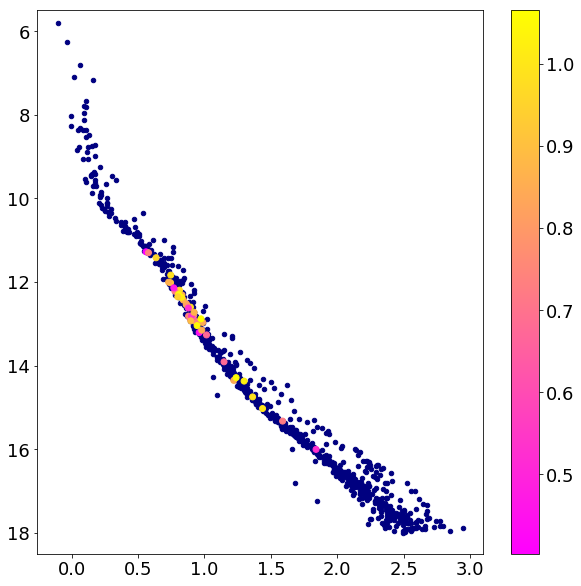

In [900]:
plt.figure(figsize=(10,10))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='navy',s=20)
#plt.scatter(allmems[highprob][ssms_indx]['bp_rp'],allmems[highprob][ssms_indx]['phot_g_mean_mag'],color='orange',s=20)

#plt.scatter(finalresultstbl['bp_rp'],finalresultstbl['phot_g_mean_mag'],color='cyan',edgecolors='navy')
plt.scatter(finalresultstbl['bp_rp'],finalresultstbl['phot_g_mean_mag'],c=finalresultstbl['sini'],cmap='spring')
plt.colorbar()

plt.ylim(18.5,5.5)
#plt.xlim(.25,1.25)

In [601]:
incemp.x

array([0.4       , 0.4034416 , 0.44336616, 0.46752034, 0.52912237,
       0.52994816, 0.54720407, 0.55677889, 0.62410461, 0.64673704,
       0.67566403, 0.67630375, 0.7219405 , 0.7337352 , 0.73744353,
       0.74670943, 0.74701026, 0.75771503, 0.8162759 , 0.82839186,
       0.84629812, 0.84635613, 0.84970381, 0.85318939, 0.86205938,
       0.86541553, 0.87263136, 0.89004324, 0.89484759, 0.90376742,
       0.9464394 , 0.95166881, 0.95578531, 0.96745423, 0.97317011,
       0.98196338, 0.98610742, 0.99442498, 1.01788444, 1.02691626,
       1.04828641, 1.05394128, 1.05589971, 1.05691251, 1.06509951])

In [602]:
incemp.y

array([0.        , 0.02272727, 0.04545455, 0.06818182, 0.09090909,
       0.11363636, 0.13636364, 0.15909091, 0.18181818, 0.20454545,
       0.22727273, 0.25      , 0.27272727, 0.29545455, 0.31818182,
       0.34090909, 0.36363636, 0.38636364, 0.40909091, 0.43181818,
       0.45454545, 0.47727273, 0.5       , 0.52272727, 0.54545455,
       0.56818182, 0.59090909, 0.61363636, 0.63636364, 0.65909091,
       0.68181818, 0.70454545, 0.72727273, 0.75      , 0.77272727,
       0.79545455, 0.81818182, 0.84090909, 0.86363636, 0.88636364,
       0.90909091, 0.93181818, 0.95454545, 0.97727273, 1.        ])

In [617]:
obs_sini_distrib_specific(incemp.x[1:],0,90)

array([0.03931075, 0.06143338, 0.07429745, 0.11174851, 0.11213628,
       0.12457388, 0.13186989, 0.18866515, 0.20806373, 0.23486928,
       0.23559826, 0.28583159, 0.29879159, 0.30301855, 0.31481629,
       0.3149907 , 0.32686982, 0.40977226, 0.42843259, 0.45727408,
       0.45740616, 0.46429866, 0.47103309, 0.48872685, 0.49548309,
       0.51153605, 0.54926017, 0.56055826, 0.58279156, 0.70510909,
       0.72155745, 0.73517568, 0.76979619, 0.78736631, 0.81211063,
       0.82374198, 0.84536563, 0.89869264, 0.91679117, 0.95025623,
       0.9571791 , 0.95905065, 0.96042607, 0.96861267])

In [926]:
len(obs_sini_distrib_specific(20,70))

55

In [937]:
sini_fracerr

array([0.05974912, 0.07361391, 0.0584281 , 0.09060436, 0.06968776,
       0.05058344, 0.04489627, 0.04365909,        nan,        nan,
       0.05042523, 0.09928521, 0.06181302, 0.0592969 , 0.05757662,
              nan, 0.06038821,        nan, 0.06526177, 0.06772659,
       0.06804172, 0.06899569, 0.05912276, 0.10340025, 0.04980846,
              nan, 0.05895868, 0.07539436, 0.06180672, 0.07368087,
       0.05481841, 0.11305433, 0.08875536, 0.0699043 , 0.05803497,
       0.06348093, 0.06080685, 0.04551791, 0.05418048, 0.06282645,
       0.06064567,        nan, 0.05933114, 0.05721562, 0.04927537,
       0.06193983, 0.07096836, 0.06153828, 0.07037292,        nan,
       0.05887465, 0.04575889, 0.06186042,        nan,        nan])

(array([ 4.,  6.,  4., 13., 15., 19., 13.,  3.,  0.,  5.]),
 array([2.31358438, 2.33738167, 2.36117895, 2.38497624, 2.40877353,
        2.43257081, 2.4563681 , 2.48016538, 2.50396267, 2.52775995,
        2.55155724]),
 <a list of 10 Patch objects>)

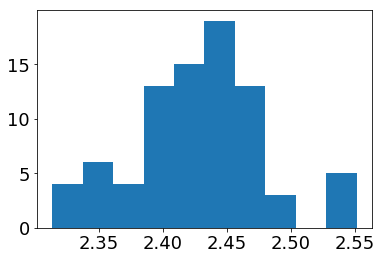

In [846]:
plt.hist(combin_tbl['parallax'])

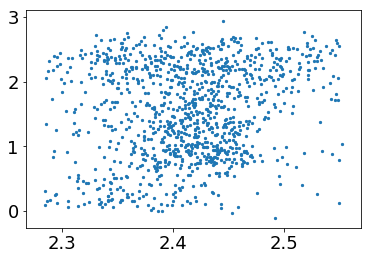

In [850]:
plt.scatter(allmems['parallax'],allmems['bp_rp'],s=5)

In [851]:
np.nanmean(allmems['parallax_error']/allmems['parallax'])

0.01920084702848909

In [852]:
np.nanmean(allmems['pmdec']), np.nanmean(allmems['pmra'])

(11.170830705947349, -4.672017153718026)

Text(0,0.5,'G')

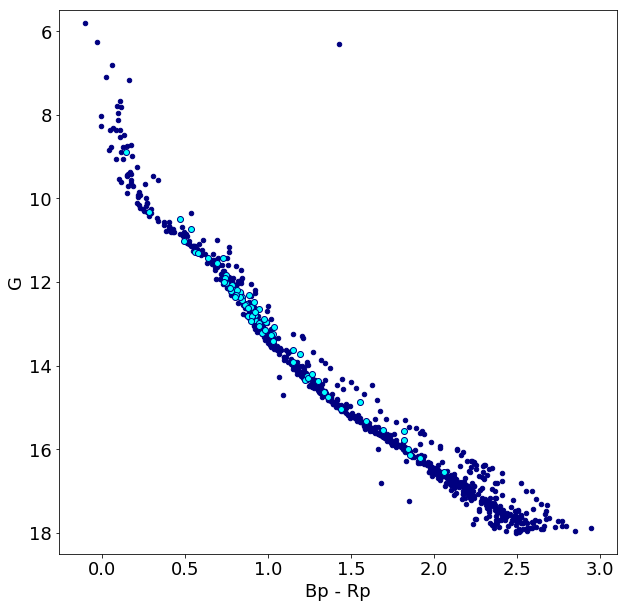

In [847]:
plt.figure(figsize=(10,10))
plt.scatter(allmems[highprob]['bp_rp'],allmems[highprob]['phot_g_mean_mag'],color='navy',s=20)
plt.scatter(combin_tbl[teff_lim]['bp_rp'],combin_tbl[teff_lim]['phot_g_mean_mag'],color='cyan',edgecolors='navy')
plt.ylim(18.5,5.5)
plt.xlabel('Bp - Rp')
plt.ylabel('G')

In [741]:
Inclination * 180/np.pi

<Column name='period' dtype='object' length=51>
              37.9+/-3.3
                  60+/-6
              25.4+/-2.5
              37.0+/-3.0
              46.7+/-3.1
                  69+/-7
              38.9+/-2.0
 8.302145866370982+/-nan
15.380358151746202+/-nan
                  64+/-6
                  57+/-9
              26.7+/-1.8
                     ...
                  59+/-5
                  57+/-4
                 76+/-14
              29.9+/-2.3
             (9+/-8)e+01
              21.4+/-1.6
14.231427831084593+/-nan
                  55+/-5
              26.5+/-1.3
                  64+/-7
43.798829730397216+/-nan
 7.774222831077527+/-nan

In [743]:
np.nanmean(fracerr)

0.11162000301773085

In [681]:
GESindx = combin_tbl['Survey'] == 'GES'

In [1482]:
for i in range(len(ges_galah_targets_slice_merged)):
    if ges_galah_targets_slice_merged['Survey'][i] == 'GES':
        ges_galah_targets_slice_merged['e_vsini'] = ges_galah_targets_slice_merged['pvsini'] * ges_galah_targets_slice_merged['vsini']

In [248]:
ind = np.where((restbl['teff'] < 4500) & (restbl['r'] > 1.2))[0]
ind

array([23, 32])

In [268]:
galahind = ges_galah_targets['Survey'] == 'Galah'

In [467]:
ges_galah_targets[galahind]

<Table length=12>
     source_id      cutout_size E_B_V_SandF ...  pvsini  gaia_r parallax_err
       int64          float64     float64   ... float64 float64   float64   
------------------- ----------- ----------- ... ------- ------- ------------
5290704306227620992         5.0      0.2258 ...      --      --           --
5290706711409106304         5.0       0.214 ...      --      --           --
5290719115275116288         5.0      0.1943 ...      --      --           --
5290721142499618816         5.0       0.189 ...      --      --           --
5290721383017776896         5.0      0.1901 ...      --      --           --
5290726914930519424         5.0      0.2311 ...      --      --           --
5290738356723303936         5.0      0.1694 ...      --      --           --
5290820029826947968         5.0      0.1656 ...      --      --           --
5290833189601524480         5.0      0.1619 ...      --      --           --
5290933829278574208         5.0      0.1753 ...      --      --           --
5291032132489758208         5.0      0.1449 ...      --      --           --
5291032613526130048         5.0       0.151 ...      --      --           --

In [357]:
names = []
for i in range(len(ges_galah_targets[galahind])):
    names += ['Gaia DR2 ' + np.str(ges_galah_targets[galahind]['source_id'][i])]
names = np.array(names)

In [364]:
Table([names],names=['#gaia_ids']).write('/Users/bhealy/Downloads/galah_gaia_names.txt',format='ascii')

In [435]:
newres = pd.read_csv('/Users/bhealy/Downloads/1582307045936O-result.csv')
newres

source_id          ra  ra_error        dec  dec_error  parallax  \
0   5290704306227620992  118.540252  0.019088 -60.974217   0.018702  2.462491   
1   5290706711409106304  118.304350  0.033440 -60.935718   0.039008  2.335697   
2   5290719115275116288  119.199284  0.022928 -60.947133   0.025253  2.495559   
3   5290721142499618816  119.521837  0.023829 -60.794476   0.020323  2.438522   
4   5290721383017776896  119.368626  0.037472 -60.839959   0.035288  2.406234   
5   5290726914930519424  118.674914  0.026412 -60.963516   0.029645  2.462357   
6   5290738356723303936  119.354284  0.031465 -60.654773   0.046003  2.415329   
7   5290820029826947968  119.628850  0.030175 -60.629528   0.025218  2.313584   
8   5290833189601524480  119.507863  0.027722 -60.547311   0.030937  2.338389   
9   5290933829278574208  118.797866  0.016893 -60.477072   0.019573  2.402029   
10  5291032132489758208  119.254037  0.021914 -60.196015   0.025113  2.439007   
11  5291032613526130048  119.394330  0.024592 -60.206700   0.025693  2.344104   

    parallax_error  phot_g_mean_mag     bp_rp  radial_velocity  \
0         0.018811        11.437655  0.724256        36.298722   
1         0.033538         8.893855  0.140327              NaN   
2         0.024729        10.739327  0.532367              NaN   
3         0.022971        11.835120  0.746092        26.649440   
4         0.037466         9.875088  0.329376              NaN   
5         0.028668        10.996720  0.692768        21.827089   
6         0.040146        11.277639  0.559865        27.404486   
7         0.029840        10.495101  0.467788              NaN   
8         0.032736        11.025987  0.492721              NaN   
9         0.018509        12.045277  0.896680        28.638971   
10        0.024174        11.298716  0.578474        23.813533   
11        0.026707        10.333562  0.279601              NaN   

         ...         a_g_val radius_val                     target_id  \
0        ...          0.8583   1.480085  Gaia DR2 5290704306227620992   
1        ...             NaN        NaN  Gaia DR2 5290706711409106304   
2        ...             NaN   1.640898  Gaia DR2 5290719115275116288   
3        ...          0.3300   1.310366  Gaia DR2 5290721142499618816   
4        ...          0.7155   2.109599  Gaia DR2 5290721383017776896   
5        ...             NaN   1.944416  Gaia DR2 5290726914930519424   
6        ...          0.2558   1.518670  Gaia DR2 5290738356723303936   
7        ...             NaN   1.903160  Gaia DR2 5290820029826947968   
8        ...          0.6620   1.514990  Gaia DR2 5290833189601524480   
9        ...          0.5200   1.539966  Gaia DR2 5290933829278574208   
10       ...             NaN   1.458426  Gaia DR2 5291032132489758208   
11       ...          0.3850   1.688003  Gaia DR2 5291032613526130048   

     target_ra  target_dec target_parallax  target_pm_ra  target_pm_dec  \
0   118.540288  -60.974267          2.4625        -3.919         10.317   
1   118.304383  -60.935765          2.3357        -3.678         10.839   
2   119.199308  -60.947183          2.4956        -2.722         11.560   
3   119.521877  -60.794525          2.4385        -4.544         11.387   
4   119.368652  -60.840008          2.4062        -3.014         11.385   
5   118.674960  -60.963563          2.4624        -3.761         10.762   
6   119.354324  -60.654820          2.4153        -4.587         11.121   
7   119.628892  -60.629583          2.3136        -4.776         12.809   
8   119.507903  -60.547358          2.3384        -4.542         10.800   
9   118.797907  -60.477119          2.4020        -4.683         10.949   
10  119.254081  -60.196065          2.4390        -4.403          9.857   
11  119.394367  -60.206748          2.3441        -4.180         11.320   

    target_radial_velocity  target_distance  
0                    36.30     5.292457e-06  
1                     0.00     3.927718e-09  
2                     0.00     6.3066

In [398]:
#join(ges_galah_targets,Table(newres[['source_id','radius_val']].as_matrix(),names=['source_id','gaia_r'],dtype=(int,float)))
TBL = Table(newres[['source_id','radius_val']].values,names=['source_id','gaia_r'],dtype=(int,float))
TBL





<Table length=12>
     source_id            gaia_r      
       int64             float64      
------------------- ------------------
5290704306227620864 1.4800848999999998
5290706711409105920                nan
5290719115275116544           1.640898
5290721142499618816          1.3103662
5290721383017777152 2.1095990000000002
5290726914930519040 1.9444156000000004
5290738356723304448 1.5186703000000001
5290820029826948096 1.9031596000000002
5290833189601524736          1.5149896
5290933829278574592 1.5399658999999999
5291032132489758720          1.4584261
5291032613526129664           1.688003

In [399]:
TBL.remove_row(1)
TBL

<Table length=11>
     source_id            gaia_r      
       int64             float64      
------------------- ------------------
5290704306227620864 1.4800848999999998
5290719115275116544           1.640898
5290721142499618816          1.3103662
5290721383017777152 2.1095990000000002
5290726914930519040 1.9444156000000004
5290738356723304448 1.5186703000000001
5290820029826948096 1.9031596000000002
5290833189601524736          1.5149896
5290933829278574592 1.5399658999999999
5291032132489758720          1.4584261
5291032613526129664           1.688003

In [425]:
newres[['source_id','radius_val']]

source_id  radius_val
0   5290704306227620992    1.480085
1   5290706711409106304         NaN
2   5290719115275116288    1.640898
3   5290721142499618816    1.310366
4   5290721383017776896    2.109599
5   5290726914930519424    1.944416
6   5290738356723303936    1.518670
7   5290820029826947968    1.903160
8   5290833189601524480    1.514990
9   5290933829278574208    1.539966
10  5291032132489758208    1.458426
11  5291032613526130048    1.688003

In [502]:
GGT = ges_galah_targets.to_pandas()

/anaconda3/envs/astroconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted column 'errmsg' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted column 'sobject_id' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted column 'field_id' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted column 'flag_cannon' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: TableReplaceWarning: converted colu

In [440]:
newres = newres.rename(columns={'radius': 'gaia_r'})

In [469]:
newres

source_id          ra  ra_error        dec  dec_error  parallax  \
0   5290704306227620992  118.540252  0.019088 -60.974217   0.018702  2.462491   
1   5290706711409106304  118.304350  0.033440 -60.935718   0.039008  2.335697   
2   5290719115275116288  119.199284  0.022928 -60.947133   0.025253  2.495559   
3   5290721142499618816  119.521837  0.023829 -60.794476   0.020323  2.438522   
4   5290721383017776896  119.368626  0.037472 -60.839959   0.035288  2.406234   
5   5290726914930519424  118.674914  0.026412 -60.963516   0.029645  2.462357   
6   5290738356723303936  119.354284  0.031465 -60.654773   0.046003  2.415329   
7   5290820029826947968  119.628850  0.030175 -60.629528   0.025218  2.313584   
8   5290833189601524480  119.507863  0.027722 -60.547311   0.030937  2.338389   
9   5290933829278574208  118.797866  0.016893 -60.477072   0.019573  2.402029   
10  5291032132489758208  119.254037  0.021914 -60.196015   0.025113  2.439007   
11  5291032613526130048  119.394330  0.024592 -60.206700   0.025693  2.344104   

    parallax_error  phot_g_mean_mag     bp_rp  radial_velocity  \
0         0.018811        11.437655  0.724256        36.298722   
1         0.033538         8.893855  0.140327              NaN   
2         0.024729        10.739327  0.532367              NaN   
3         0.022971        11.835120  0.746092        26.649440   
4         0.037466         9.875088  0.329376              NaN   
5         0.028668        10.996720  0.692768        21.827089   
6         0.040146        11.277639  0.559865        27.404486   
7         0.029840        10.495101  0.467788              NaN   
8         0.032736        11.025987  0.492721              NaN   
9         0.018509        12.045277  0.896680        28.638971   
10        0.024174        11.298716  0.578474        23.813533   
11        0.026707        10.333562  0.279601              NaN   

         ...         a_g_val    gaia_r                     target_id  \
0        ...          0.8583  1.480085  Gaia DR2 5290704306227620992   
1        ...             NaN       NaN  Gaia DR2 5290706711409106304   
2        ...             NaN  1.640898  Gaia DR2 5290719115275116288   
3        ...          0.3300  1.310366  Gaia DR2 5290721142499618816   
4        ...          0.7155  2.109599  Gaia DR2 5290721383017776896   
5        ...             NaN  1.944416  Gaia DR2 5290726914930519424   
6        ...          0.2558  1.518670  Gaia DR2 5290738356723303936   
7        ...             NaN  1.903160  Gaia DR2 5290820029826947968   
8        ...          0.6620  1.514990  Gaia DR2 5290833189601524480   
9        ...          0.5200  1.539966  Gaia DR2 5290933829278574208   
10       ...             NaN  1.458426  Gaia DR2 5291032132489758208   
11       ...          0.3850  1.688003  Gaia DR2 5291032613526130048   

     target_ra  target_dec target_parallax  target_pm_ra  target_pm_dec  \
0   118.540288  -60.974267          2.4625        -3.919         10.317   
1   118.304383  -60.935765          2.3357        -3.678         10.839   
2   119.199308  -60.947183          2.4956        -2.722         11.560   
3   119.521877  -60.794525          2.4385        -4.544         11.387   
4   119.368652  -60.840008          2.4062        -3.014         11.385   
5   118.674960  -60.963563          2.4624        -3.761         10.762   
6   119.354324  -60.654820          2.4153        -4.587         11.121   
7   119.628892  -60.629583          2.3136        -4.776         12.809   
8   119.507903  -60.547358          2.3384        -4.542         10.800   
9   118.797907  -60.477119          2.4020        -4.683         10.949   
10  119.254081  -60.196065          2.4390        -4.403          9.857   
11  119.394367  -60.206748          2.3441        -4.180         11.320   

    target_radial_velocity  target_distance  
0                    36.30     5.292457e-06  
1                     0.00     3.927718e-09  
2                     0.00     6.306694e-09  
3   

In [459]:
GGT[galahind]['gaia_r'] = newres['gaia_r'].values

/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [492]:
GGT.update(newres[['source_id','gaia_r']])

In [491]:
newres[['source_id','gaia_r']]

source_id    gaia_r
0   5290704306227620992  1.480085
1   5290706711409106304       NaN
2   5290719115275116288  1.640898
3   5290721142499618816  1.310366
4   5290721383017776896  2.109599
5   5290726914930519424  1.944416
6   5290738356723303936  1.518670
7   5290820029826947968  1.903160
8   5290833189601524480  1.514990
9   5290933829278574208  1.539966
10  5291032132489758208  1.458426
11  5291032613526130048  1.688003

In [503]:
GGT = GGT.set_index('source_id')
small = newres[['source_id','gaia_r']].set_index('source_id')

In [509]:
test=GGT.combine_first(small)

In [519]:
test = test.reset_index()

In [566]:
ges_galah_targets_updated = Table(data=test.values,names=test.columns,dtype=test.dtypes)

In [568]:
ges_galah_targets_updated.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/ges_galah_targets_updated.dat',format='ascii',overwrite=True)




In [569]:
ges_galah_targets_updated

<Table length=136>
     source_id       AV_SFD ...         y_fe                zn_fe        
       int64        float64 ...       float64              float64       
------------------- ------- ... -------------------- --------------------
5289994502751632384  0.5786 ...                  nan                  nan
5289996182079618560  0.5698 ...                  nan                  nan
5290028725050999296  0.5746 ...                  nan                  nan
5290642046382523008  0.6609 ...                  nan                  nan
5290652938419483904  0.6338 ...                  nan                  nan
5290653075858442752  0.6503 ...                  nan                  nan
5290653350736340736  0.6313 ...                  nan                  nan
5290655481040144256  0.6445 ...                  nan                  nan
5290655549759622144  0.6359 ...                  nan                  nan
5290655687198404864   0.643 ...                  nan                  nan
                ...     ... ...                  ...                  ...
5290932386169704320  0.5921 ...                  nan                  nan
5290933829278574208   0.632 ... -0.26762175379899084  0.09370089667559302
5290933863638628096  0.6334 ...                  nan                  nan
5290934791351568384  0.6232 ...                  nan                  nan
5290934997509679232  0.6142 ...                  nan                  nan
5290935375466863104  0.6005 ...                  nan                  nan
5290935993942419840   0.589 ...                  nan                  nan
5291030448862535808  0.5419 ...                  nan                  nan
5291032132489758208  0.5223 ...  0.19331992342500084  -0.2576873848476148
5291032613526130048  0.5443 ...   0.5269308711192091 -0.20193542411127877

In [337]:
for i in range(len(ges_galah_targets[galahind])):
    tgt = ges_galah_targets[galahind]['source_id'][i]
    qry = Gaia.query_object('Gaia DR2 '+np.str(tgt),radius=.005*u.deg)
    #qry0 = qry[0]

HTTPError: Error 500: 
Cannot parse query '
      TOP 2000            SELECT
                  *,
                  DISTANCE(
                    POINT('ICRS', ra, dec),
                    POINT('ICRS', 118.54029482879844, -60.974272833762825)
                  ) AS dist
                FROM
                  gaiadr2.gaia_source
                WHERE
                  1 = CONTAINS(
                    POINT('ICRS', ra, dec),
                    CIRCLE('ICRS', 118.54029482879844, -60.974272833762825, 0.005)
                  )
                ORDER BY
                  dist ASC
                ' for job '1582306663074O':  Encountered "TOP". Was expecting: "SELECT" 
